In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import gym
import numpy as np
from IPython.display import display, clear_output   
from time import sleep

In [ ]:
import networkx as nx
G=nx.Graph()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
nodes = np.arange(25)
G.add_nodes_from(list(nodes))

In [ ]:
edges = [(0,1),(0,5),(1,6),(2,7),(2,3),(3,4),(3,8),(4,9),(5,6),(5,10),(6,11),(7,12),(7,8),(8,13),(8,9),(9,14),(10,11),(10,15),(11,12),(11,16),(12,13),(12,17),(13,14),(14,19),(10,15),(11,16),(12,17),(13,18),(15,20),(16,17),(16,21),(17,22),(18,19),(18,23),(19,24),(21,22),(23,24)]
G.add_edges_from(edges)

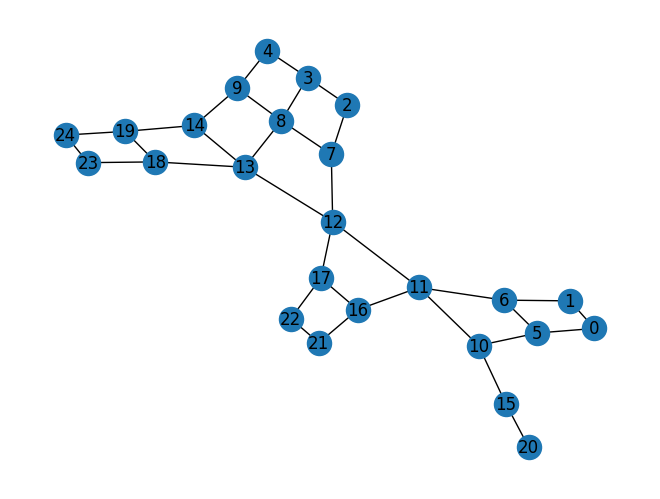

In [ ]:
nx.draw(G,with_labels = True)

In [ ]:
#Bottle necks identified  are 12 and 11

#define policies reaching 12 and 11


'''0: move south

1: move north

2: move east

3: move west

4: pickup passenger

5: drop off passenger'''



policy_11 = np.array([[0,0,0,0,0],
                      [0,0,0,0,0],
                      [2,0,3,3,3],
                      [1,1,1,1,1],
                      [1,1,1,1,1]])


policy_12 = np.array([[0,0,0,0,0],
                      [0,0,0,0,0],
                      [2,2,0,3,3],
                      [1,1,1,1,1],
                      [1,1,1,1,1]])

In [ ]:
actions = [0,1,2,3,4,5,6,7]
action_policy = {6:policy_11,7: policy_12}

In [ ]:
env = gym.make("Taxi-v3")

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
def SMDP_Q_learning(ALPHA,GAMMA,EPS,NUM_EPS):
  actions = [0,1,2,3,4,5,6,7]
  action_policy = {6:policy_11,7: policy_12}
  termination_dict = {6:11,7:12}
  Q_SMDP = np.zeros((env.observation_space.n,len(actions))) 
  Update_Frequency_SMDP_q_learning = np.zeros((env.observation_space.n,len(actions)))
  alpha = ALPHA
  gamma = GAMMA
  cumul_reward_SMDP = []
  ep_steps = []

  def average_episode_time(Q):
    steps = []
    trajectories_ep = []
    for i in range(1000):
      state = env.reset()
      done = False
      t = 0
      trajectory = []
      while not done:
        action = np.argmax(Q[state])
        
        if action<6:
          next_state,reward,done,_ = env.step(action)
          trajectory.append([state,action,next_state,reward,False])
          state = next_state
          t+=1
        if action>=6:
          optdone = False
          while not optdone:

            row_t,col_t,_,_ = env.decode(state)
            optaction = action_policy[action][row_t][col_t] 
            next_state,reward,done,_ = env.step(optaction)
            trajectory.append([state,optaction,next_state,reward,True])
            t+=1
            state= next_state
            row_t_1,col_t_1,_,_ = env.decode(next_state)
            next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
            if next_state_is_terminal:
              optdone = True
            state = next_state
      steps.append(t)
      trajectories_ep.append(trajectory)
    return np.array(steps).mean(), steps,trajectories_ep


  def return_action(state,epsilon,Q):
    if np.random.rand()>epsilon:
      return np.argmax(Q[state])
    else:
      return np.random.choice(np.arange((len(actions))),1)[0]

  
  for ep in range(int(NUM_EPS)):
  #print(ep)
    done = False
    state = env.reset()
    r = 0
    t = 0
    while not done:
      eps = max((0.99**ep)*0.9,EPS)
      action = return_action(state,eps,Q_SMDP)
      if action <6:
        next_state, reward, done,_ = env.step(action)
        r+=reward
        t+=1
        update = reward + gamma * max(Q_SMDP[next_state]) - Q_SMDP[state][action]
        Q_SMDP[state][action] +=  alpha*(update)
        Update_Frequency_SMDP_q_learning[state][action] += 1
        state = next_state
      
      if action >= 6:
        optdone = False
        tau = 0
        reward_bar = 0
        current_state = state
        termination = termination_dict[action]
        while not optdone:
          taxi_row,taxi_col,_,_  = env.decode(state)
          optaction = action_policy[action][taxi_row][taxi_col]
          next_state,reward,done,_ = env.step(optaction)
          tau +=1
          t+=1
          reward_bar = reward_bar + (gamma**(tau-1))*reward
          state = next_state
          row_t_1,col_t_1,_,_ = env.decode(next_state)
          next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination  else False
          if next_state_is_terminal:
            optdone = True
        update = reward_bar + (gamma**tau) * max(Q_SMDP[state]) - Q_SMDP[current_state][action]
        Q_SMDP[current_state][action] +=  alpha * update
        r+=reward_bar
        Update_Frequency_SMDP_q_learning[current_state][action] += 1
    cumul_reward_SMDP.append(r) 
    ep_steps.append(t)

  plt.figure(figsize = (15,15))
  sns.heatmap(Update_Frequency_SMDP_q_learning,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Update_frequency_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  plt.figure(figsize = (15,15))
  sns.heatmap(Q_SMDP,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Intra_option ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(cumul_reward_SMDP)
  plt.xlabel("Number of episodes")
  plt.ylabel("Cummulative reward")
  plt.savefig(str("Reward_SMDP ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(ep_steps)
  plt.xlabel("Number of episodes")
  plt.ylabel("Number of steps taken to solve the environment")
  plt.savefig(str("time_steps_SMDP ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()

  mean_steps,_,_ =  average_episode_time(Q_SMDP)
  return mean_steps


In [ ]:
def Q_intra_option_Q_learning(ALPHA,GAMMA,EPS,NUM_EPS):
  actions = [0,1,2,3,4,5,6,7]
  action_policy = {6:policy_11,7: policy_12}
  termination_dict = {6:11,7:12}
  Q_intra_option_Q = np.zeros((env.observation_space.n,len(actions))) 
  Update_Frequency_intra_q_learning = np.zeros((env.observation_space.n,len(actions)))
  alpha = ALPHA
  gamma = GAMMA
  cumul_reward_intra = []
  ep_steps = []

  def average_episode_time(Q):
    steps = []
    trajectories_ep = []
    for i in range(1000):
      state = env.reset()
      done = False
      t = 0
      trajectory = []
      while not done:
        action = np.argmax(Q[state])
        
        if action<6:
          next_state,reward,done,_ = env.step(action)
          trajectory.append([state,action,next_state,reward,False])
          state = next_state
          t+=1
        if action>=6:
          optdone = False
          while not optdone:

            row_t,col_t,_,_ = env.decode(state)
            optaction = action_policy[action][row_t][col_t] 
            next_state,reward,done,_ = env.step(optaction)
            trajectory.append([state,optaction,next_state,reward,True])
            t+=1
            state= next_state
            row_t_1,col_t_1,_,_ = env.decode(next_state)
            next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
            if next_state_is_terminal:
              optdone = True
            state = next_state
      steps.append(t)
      trajectories_ep.append(trajectory)
    return np.array(steps).mean(), steps,trajectories_ep
  def return_action(state,epsilon,Q):
    if np.random.rand()>epsilon:
      return np.argmax(Q[state])
    else:
      return np.random.choice(np.arange((len(actions))),1)[0]

  def update_intraoption_action(state,action,next_state,reward): #here action is a primitive action
    Q_intra_option_Q[state][action] += alpha*(reward + gamma*max(Q_intra_option_Q[next_state]) - Q_intra_option_Q[state][action])
    Update_Frequency_intra_q_learning[state][action] +=1 
    row_t,col_t,_,_ = env.decode(state)
    row_t_1,col_t_1,_,_ = env.decode(next_state)
    
    for option in range(6,8):
      #print(option,termination_dict[option])
      optaction_  = action_policy[option][row_t][col_t]
      next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[option] else False 
      if optaction_ == action:
        if next_state_is_terminal == False:
          Q_intra_option_Q[state][option] += alpha*(reward + (gamma * Q_intra_option_Q[next_state][option]) - Q_intra_option_Q[state][option])
          Update_Frequency_intra_q_learning[state][option] += 1  
        else:
          Q_intra_option_Q[state][option] += alpha*(reward + gamma * max(Q_intra_option_Q[next_state]) - Q_intra_option_Q[state][option])
          Update_Frequency_intra_q_learning[state][option] += 1  

  for ep in range(int(NUM_EPS)):
    state = env.reset()
    done = False
    t = 0
    r = 0
    while not done:
      eps = max((0.99**ep)*0.9,EPS)
      action = return_action(state,eps,Q_intra_option_Q)
      #print(state,action)
      if action <6:
        next_state,reward,done,_ = env.step(action)
        r+=  reward
        t+=1
        update_intraoption_action(state,action,next_state,reward)
        state = next_state
        #print(state,action,next_state,reward)
      if action>=6:
        #print("current_option: ",action)
        optdone = False
        while not optdone:

          row_t,col_t,_,_ = env.decode(state)
          optaction = action_policy[action][row_t][col_t] 
          next_state,reward,done,_ = env.step(optaction) 
          r+= reward
          t+=1
          update_intraoption_action(state,optaction,next_state,reward)
          state= next_state
          row_t_1,col_t_1,_,_ = env.decode(next_state)
          next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
          #print(state,optaction,next_state,reward,termination_dict[action])
          if next_state_is_terminal:
            optdone = True
    cumul_reward_intra.append(r)
    ep_steps.append(t)

  plt.figure(figsize = (15,15))
  sns.heatmap(Update_Frequency_intra_q_learning,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Update_frequency_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  plt.figure(figsize = (15,15))
  sns.heatmap(Q_intra_option_Q,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Intra_option ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(cumul_reward_intra)
  plt.xlabel("Number of episodes")
  plt.ylabel("Cummulative reward")
  plt.savefig(str("Reward_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(ep_steps)
  plt.xlabel("Number of episodes")
  plt.ylabel("Number of steps taken to solve the environment")
  plt.savefig(str("time_steps_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()

  mean_steps,_,_ =  average_episode_time(Q_intra_option_Q)
  return mean_steps


In [ ]:
!pip install wandb 
import wandb
!wandb login --relogin

import pprint
import numpy as np

sweep_config = {
    'method': 'bayes'
}

metric = {
    'name' : 'Average steps SMDP Q learning',
    'goal' : 'minimize'
}
sweep_config['metric'] = metric

parameters_dict ={
    'NUM_EPISODES': {
      'values': [1e3,1e4,5e4,1e5]
    }

    }
sweep_config['parameters'] = parameters_dict

import math
parameters_dict.update({
    'LR': {
      'values': [1e-2,1e-1,0.2,0.3,0.5,0.8]
      },
    'EPS': {
      'distribution': 'uniform',
      'max': 0.3,
      'min': 0.05
      }
  
    })

pprint.pprint(sweep_config)

sweep_id = wandb.sweep(sweep_config, project="SMDP_Q Learning")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=4c5bd6e1e3eeff852dc7f44b32e7f8098d38bc586e20ada208c4815e81b61e03
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or pr

In [ ]:
def train_intra_Q(config = None):
  with wandb.init(config = config):
    config = wandb.config
    LR = config.LR               ## learning rate 
    NUM_EPS = config.NUM_EPISODES
    EPS = config.EPS
    num_steps = Q_intra_option_Q_learning(LR,0.9,EPS,NUM_EPS)
    wandb.log({'Average steps Intra option Q learning':num_steps})

wandb: Agent Starting Run: b19gxxax with config:
wandb: 	EPS: 0.07094425713152018
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 100000
wandb: Currently logged in as: me19b190. Use `wandb login --relogin` to force relogin


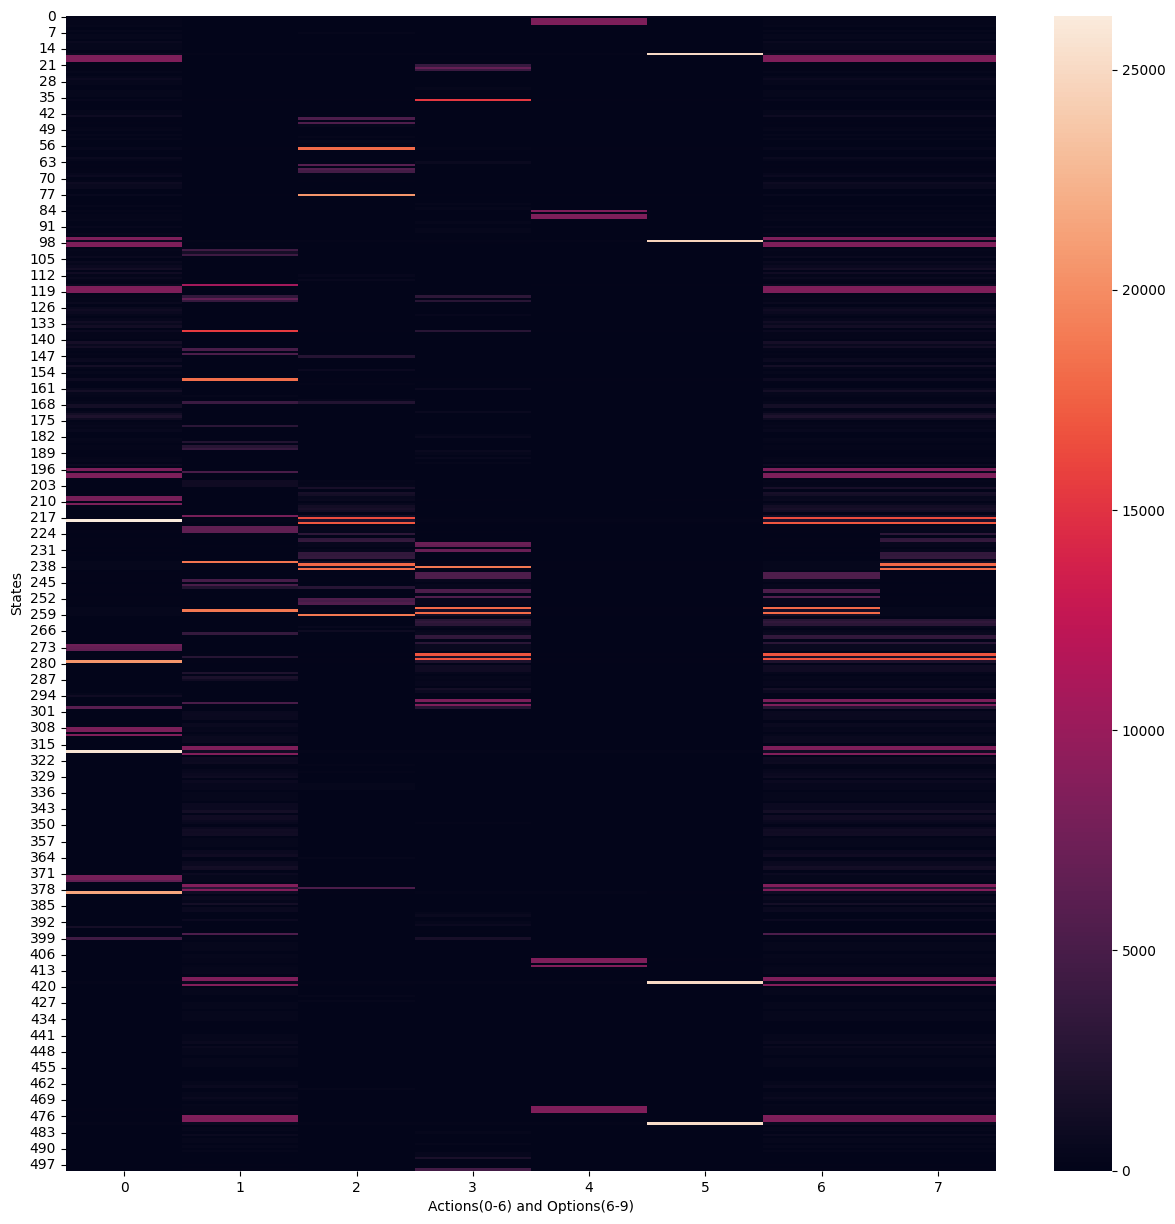

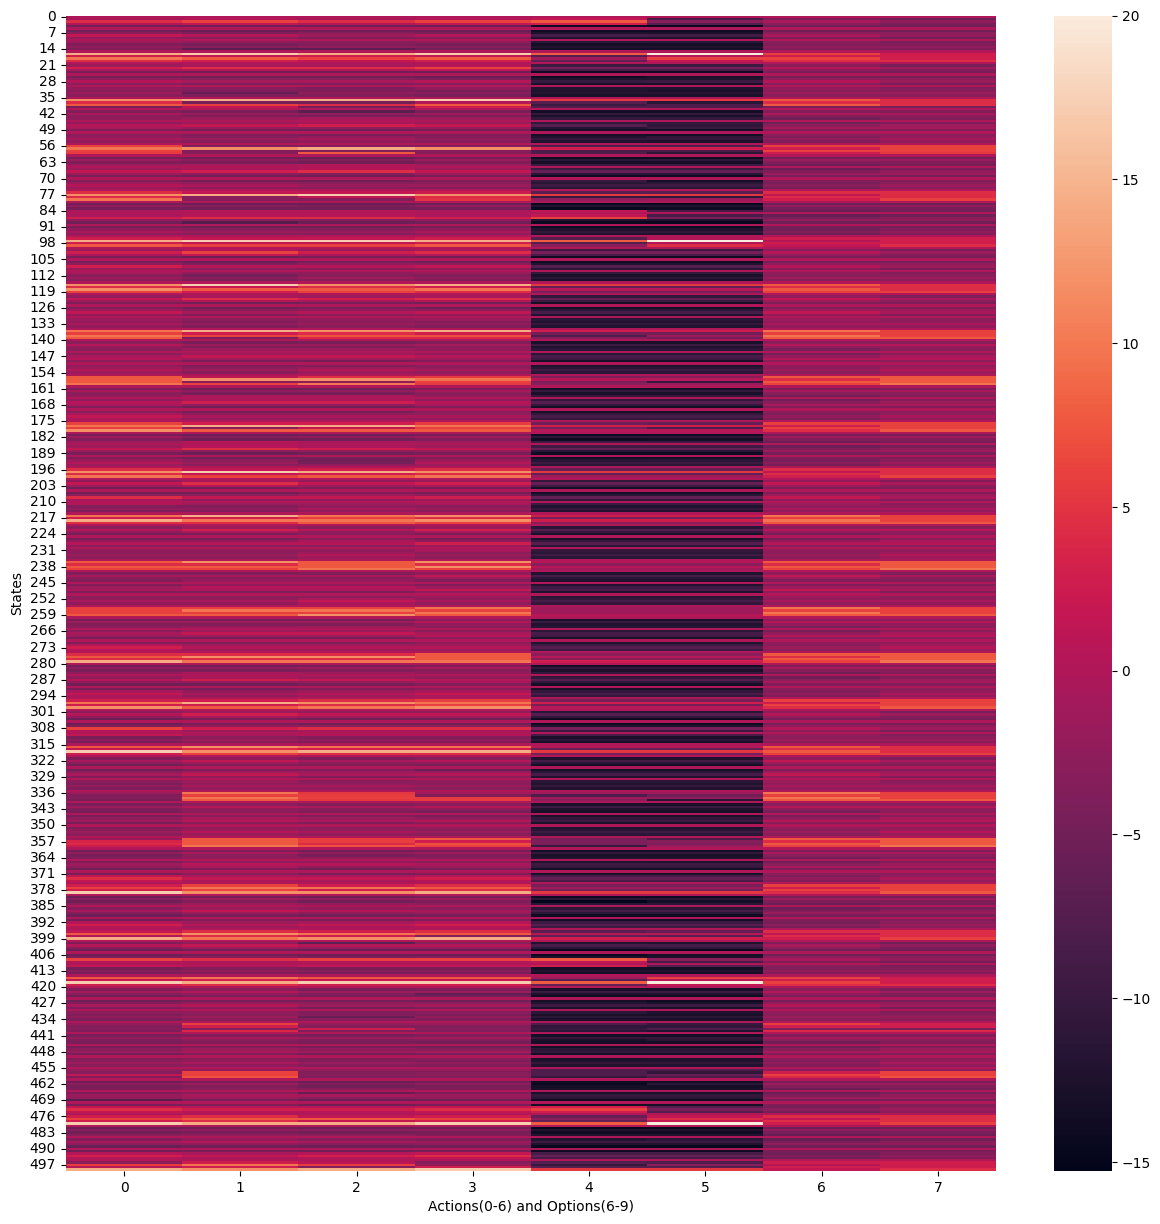

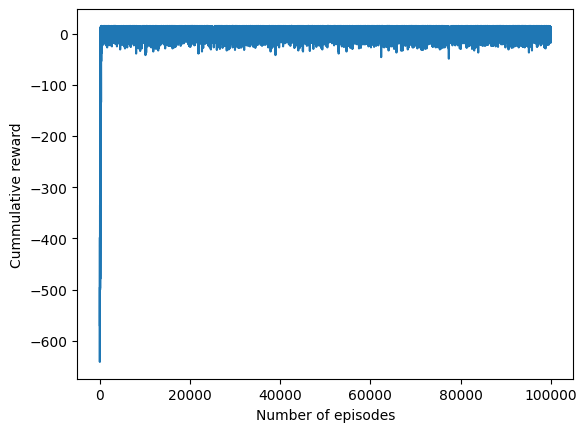

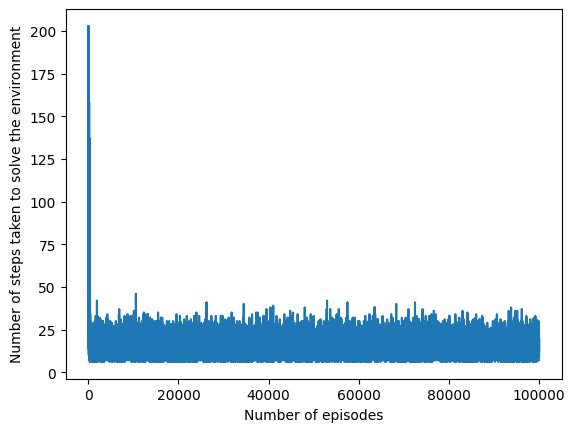

wandb: Agent Starting Run: ic728fjg with config:
wandb: 	EPS: 0.26455276819926815
wandb: 	LR: 0.5
wandb: 	NUM_EPISODES: 200000


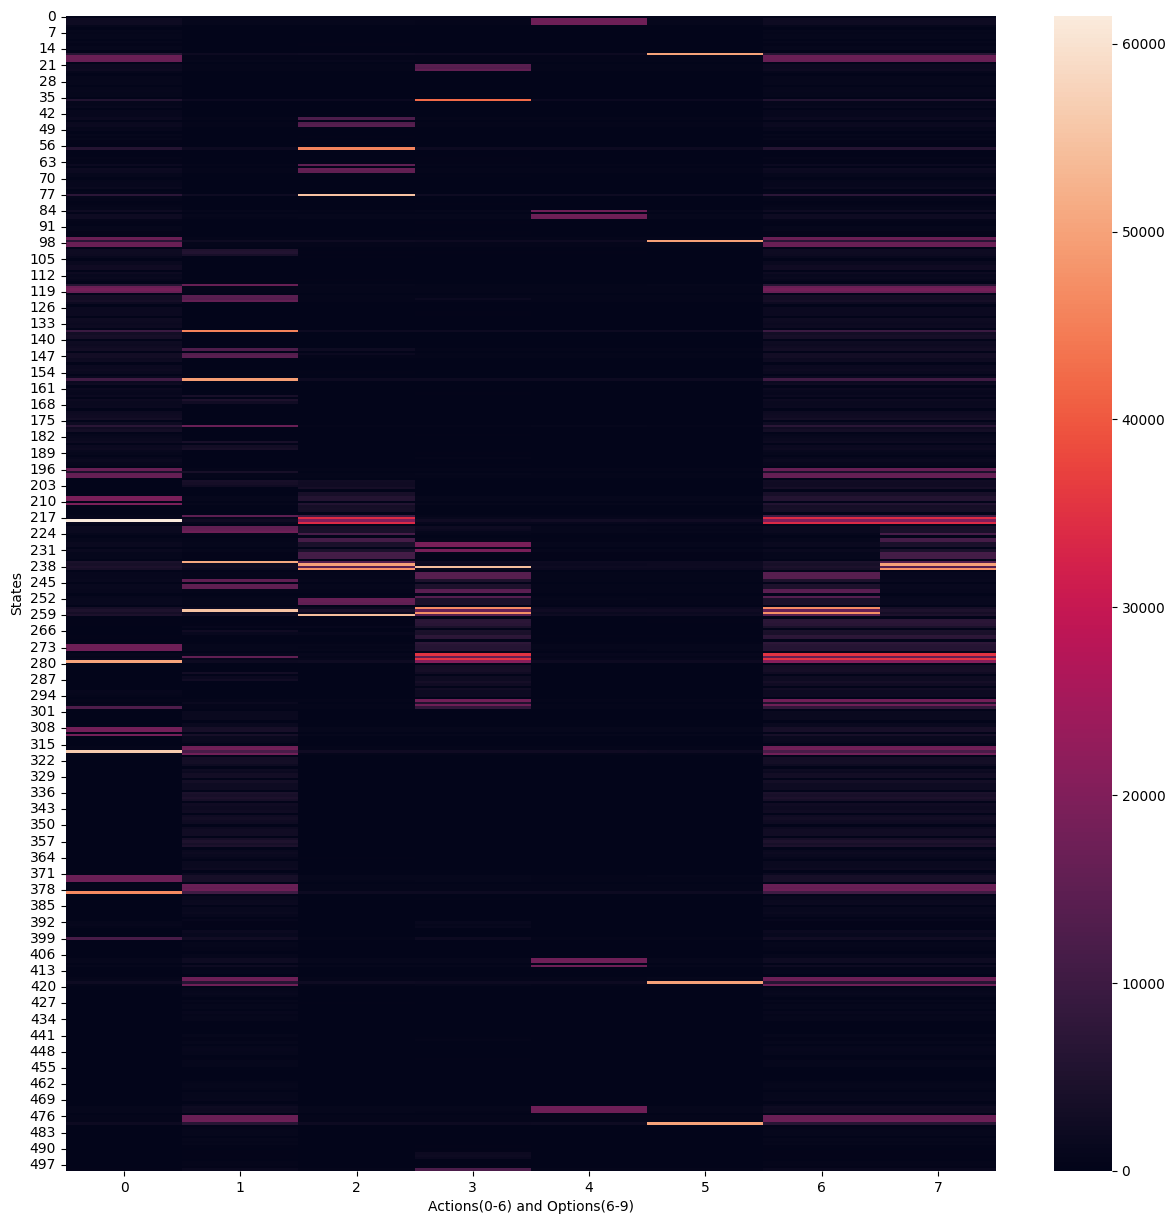

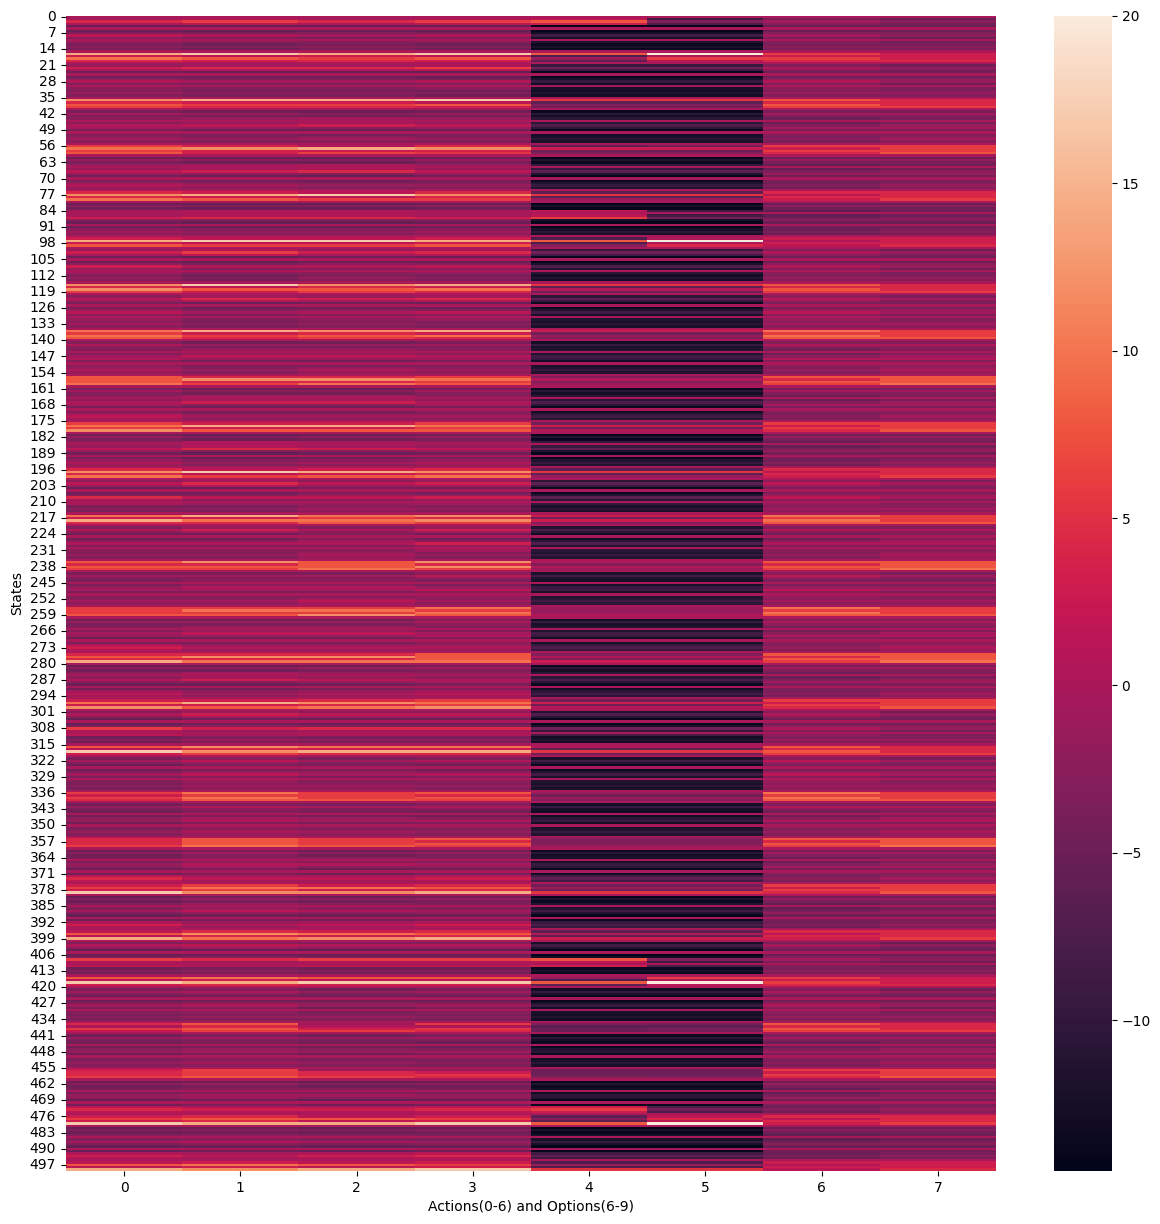

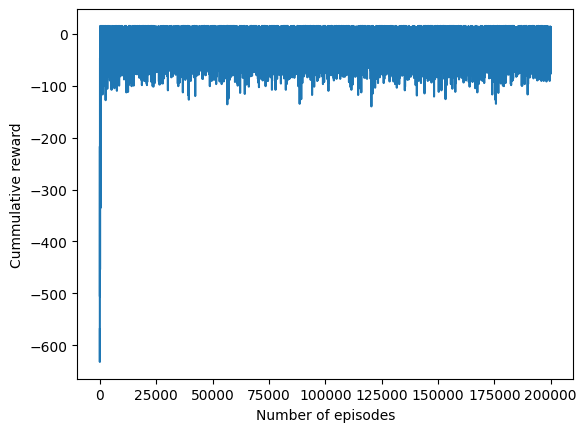

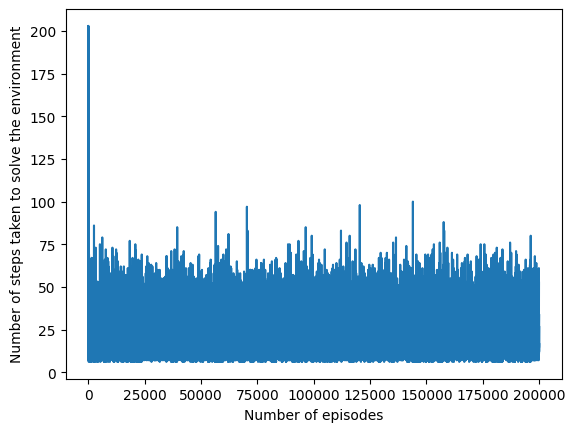

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v6txavcm with config:
wandb: 	EPS: 0.2296493648587654
wandb: 	LR: 0.5
wandb: 	NUM_EPISODES: 100000


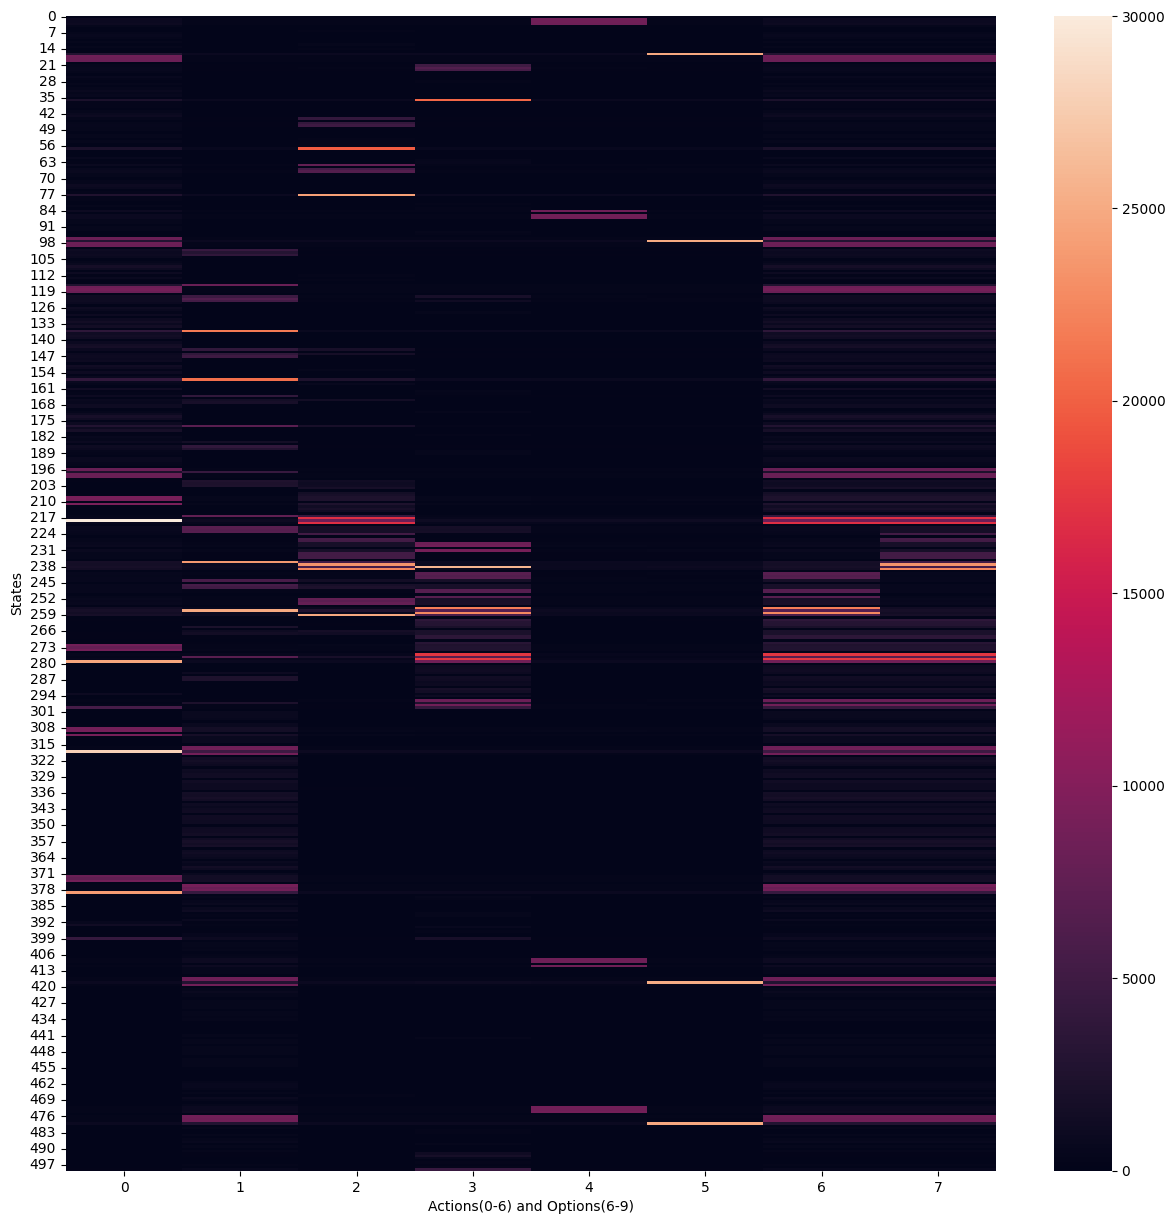

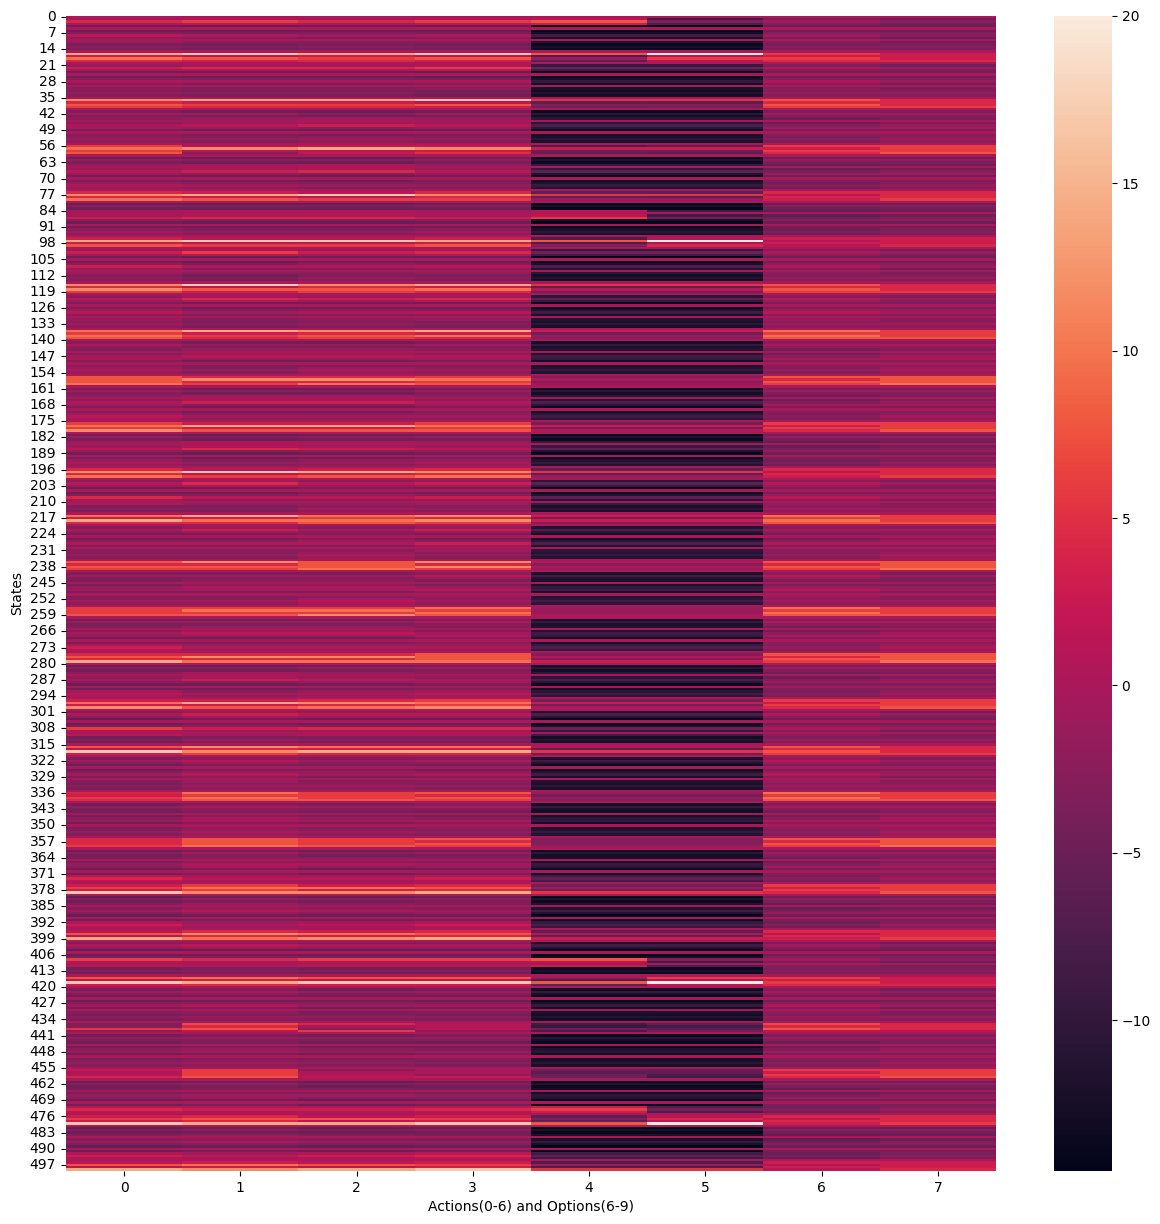

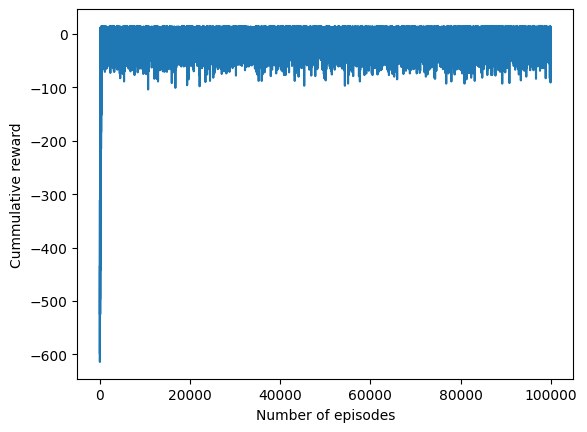

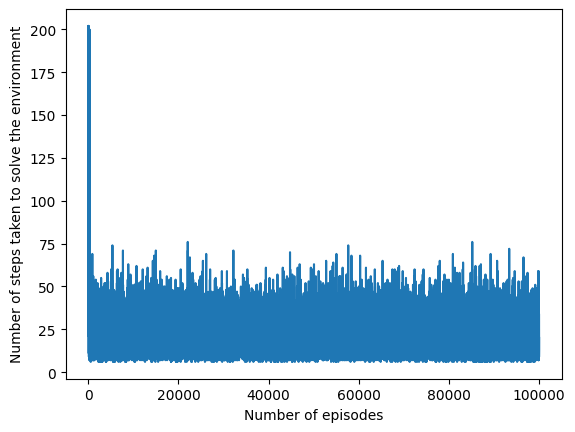

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0p0c7ihd with config:
wandb: 	EPS: 0.2638720630419195
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 100000


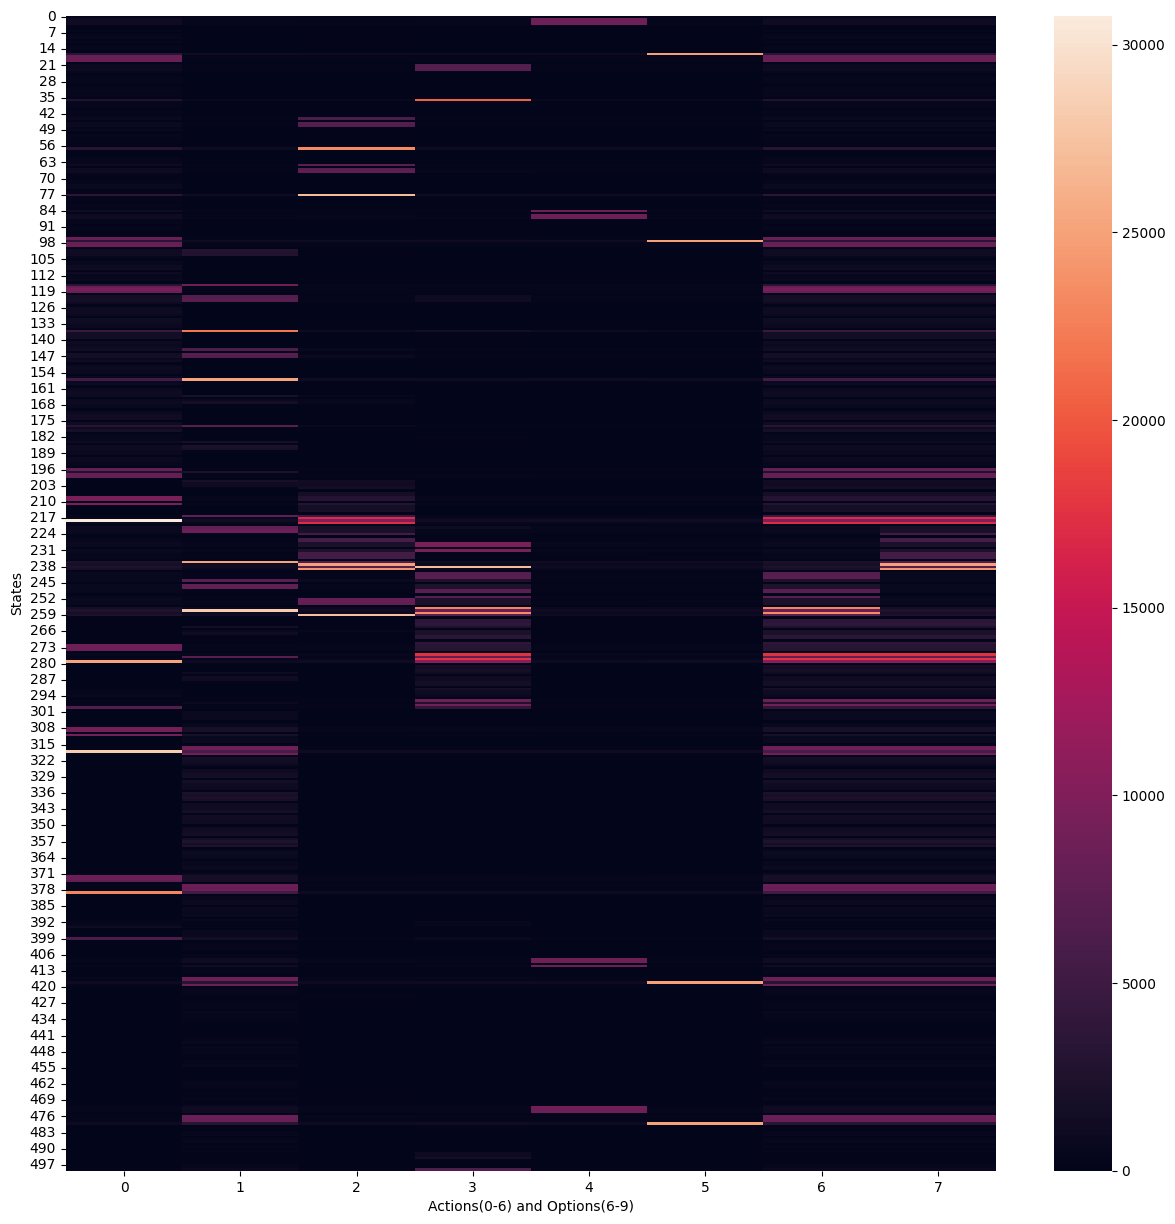

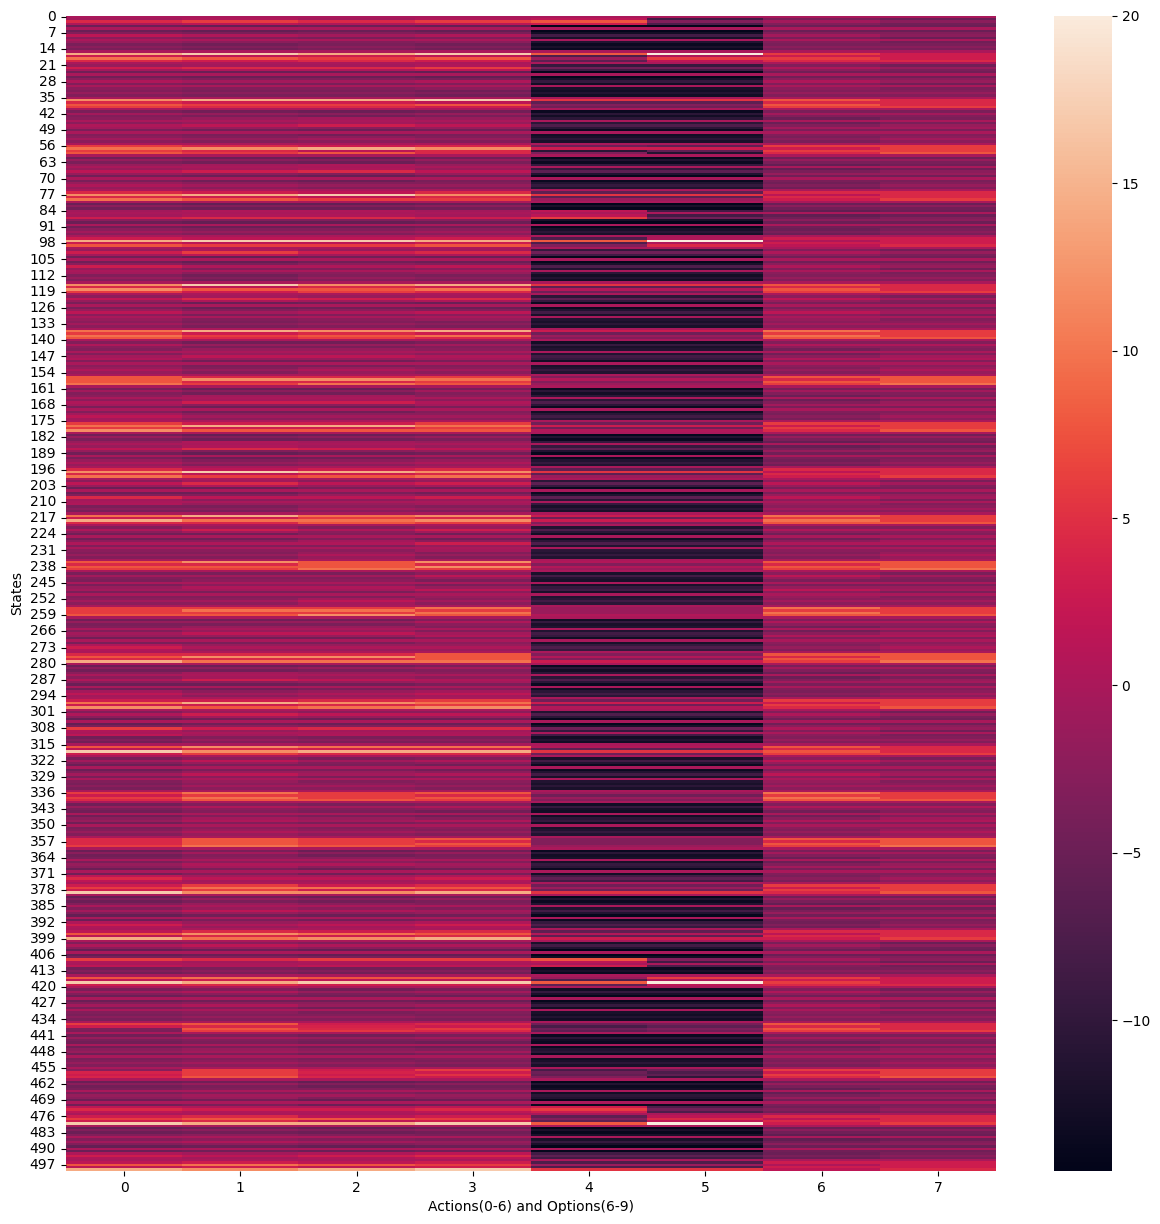

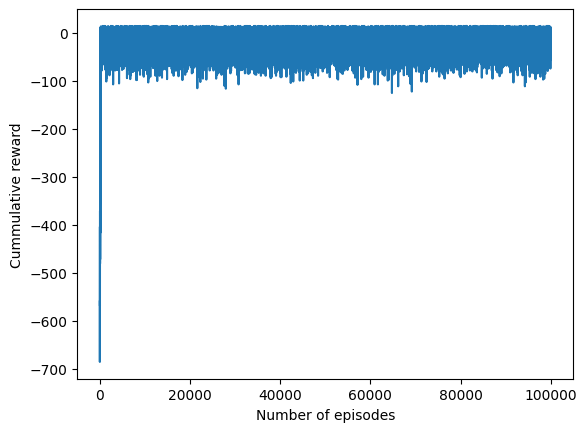

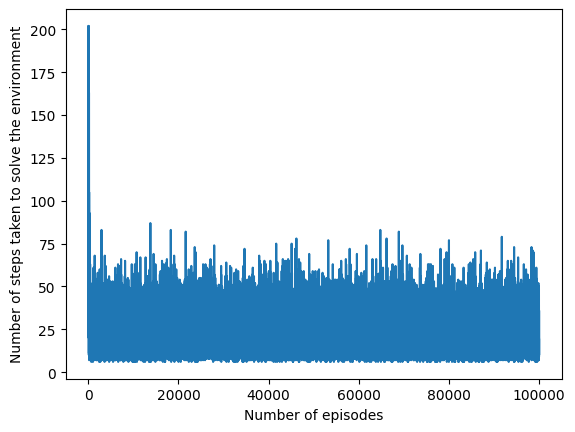

wandb: Agent Starting Run: dboqv11u with config:
wandb: 	EPS: 0.297738243328277
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 50000


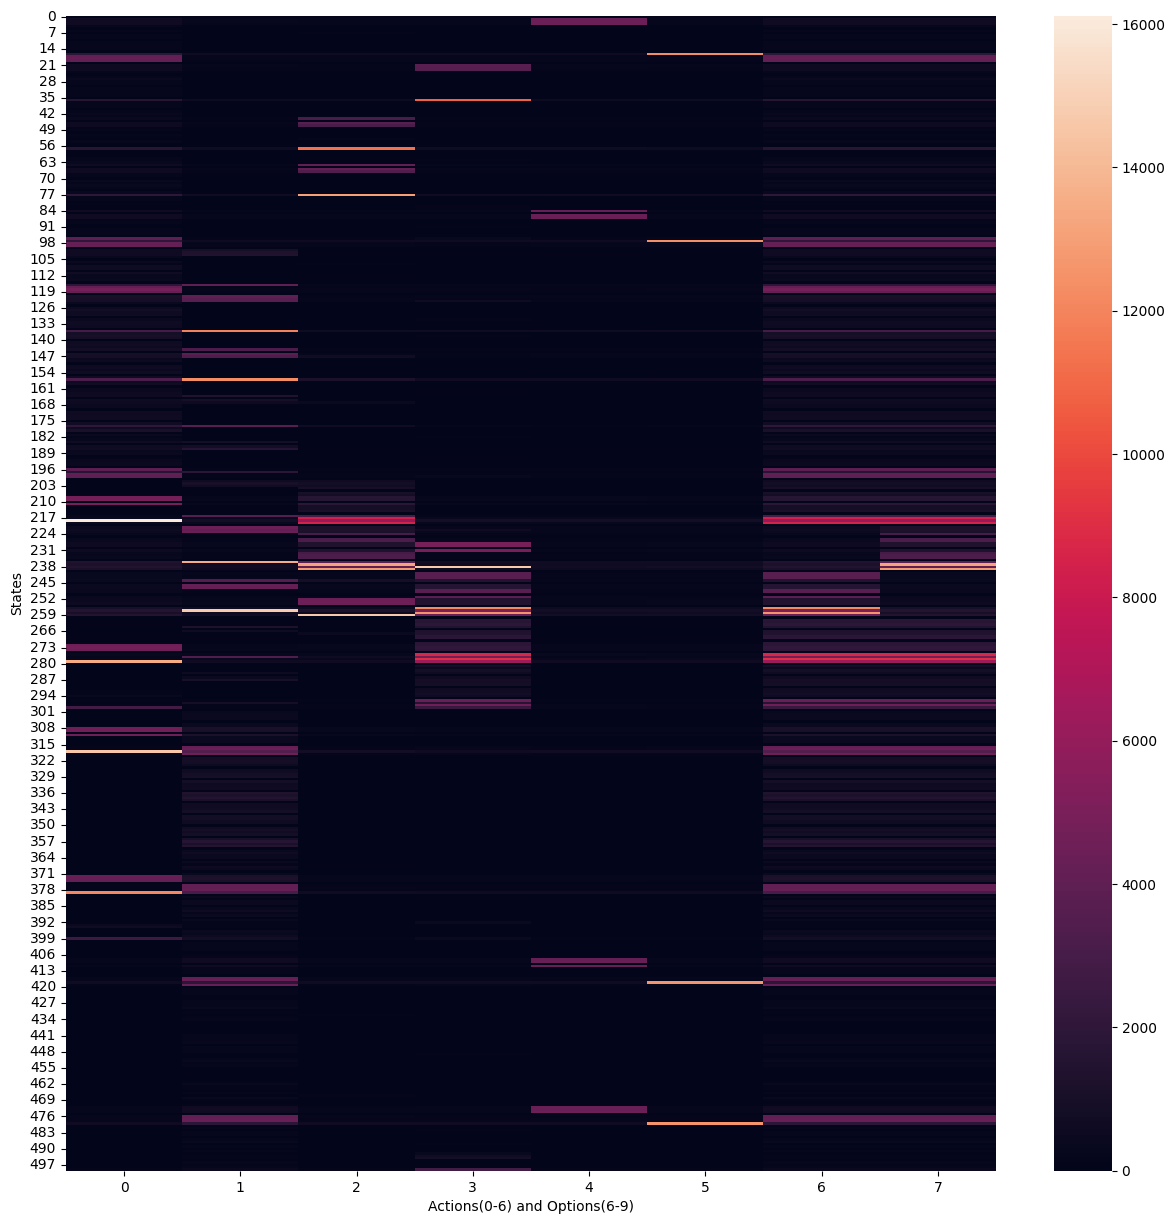

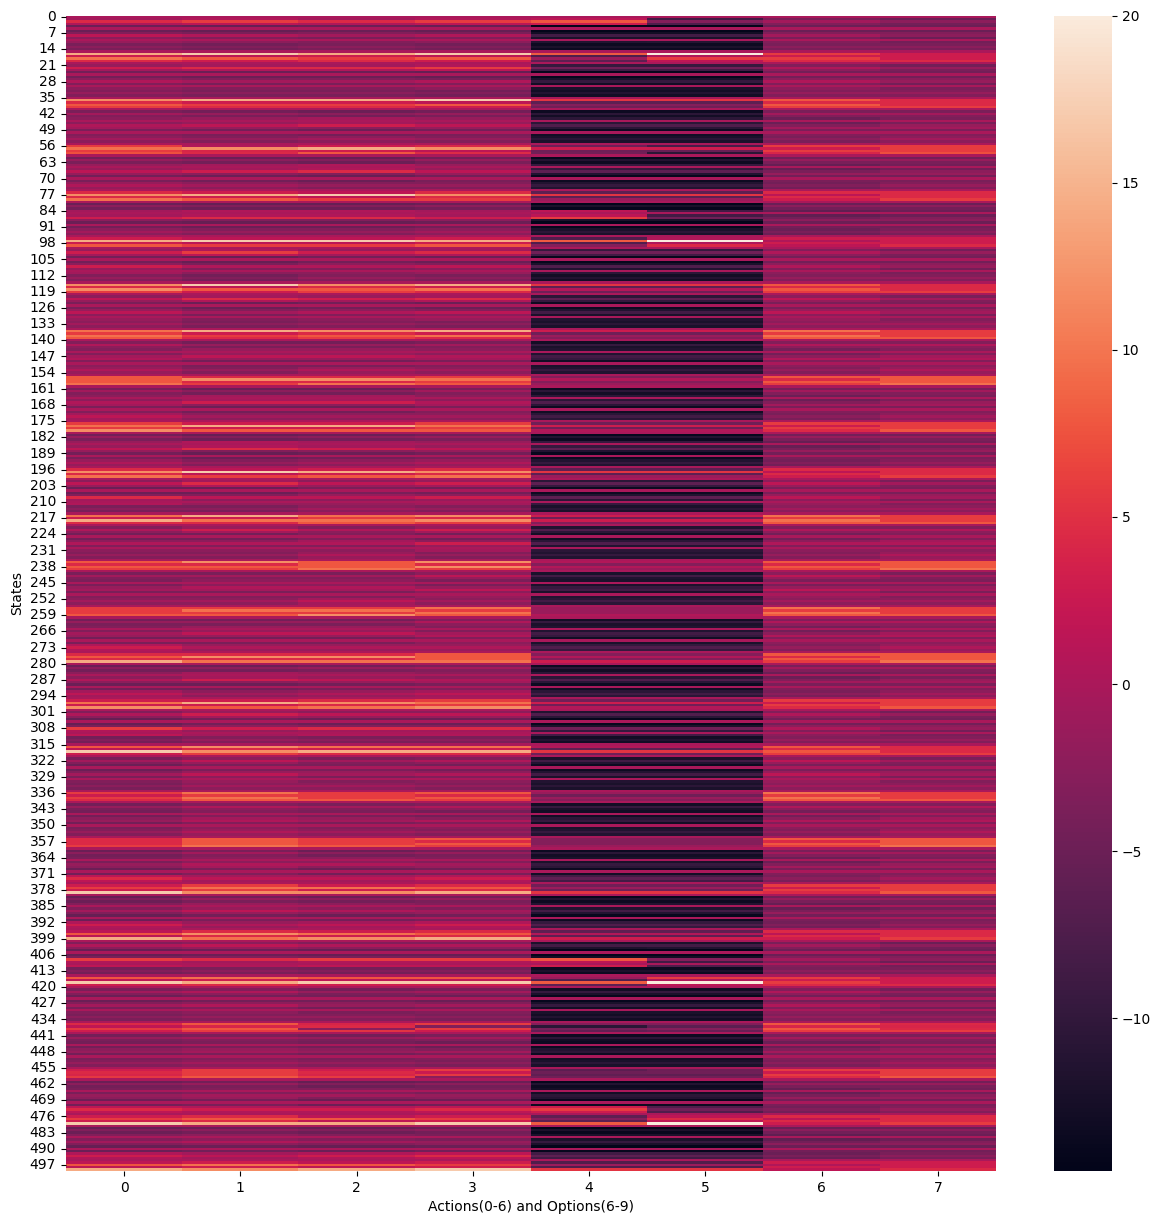

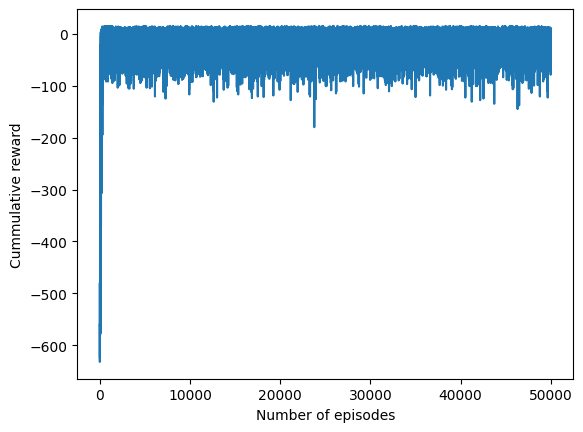

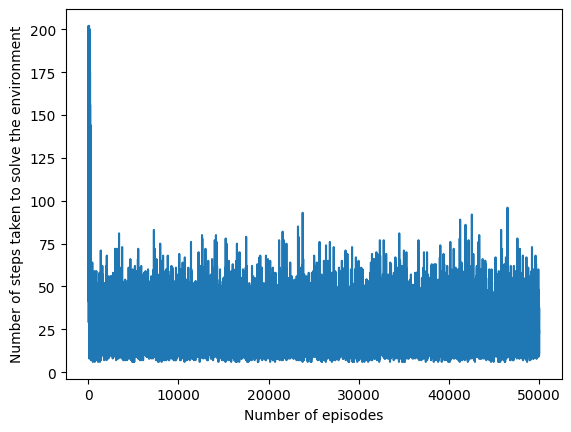

wandb: Agent Starting Run: 1kl4918l with config:
wandb: 	EPS: 0.17041686739445938
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 100000


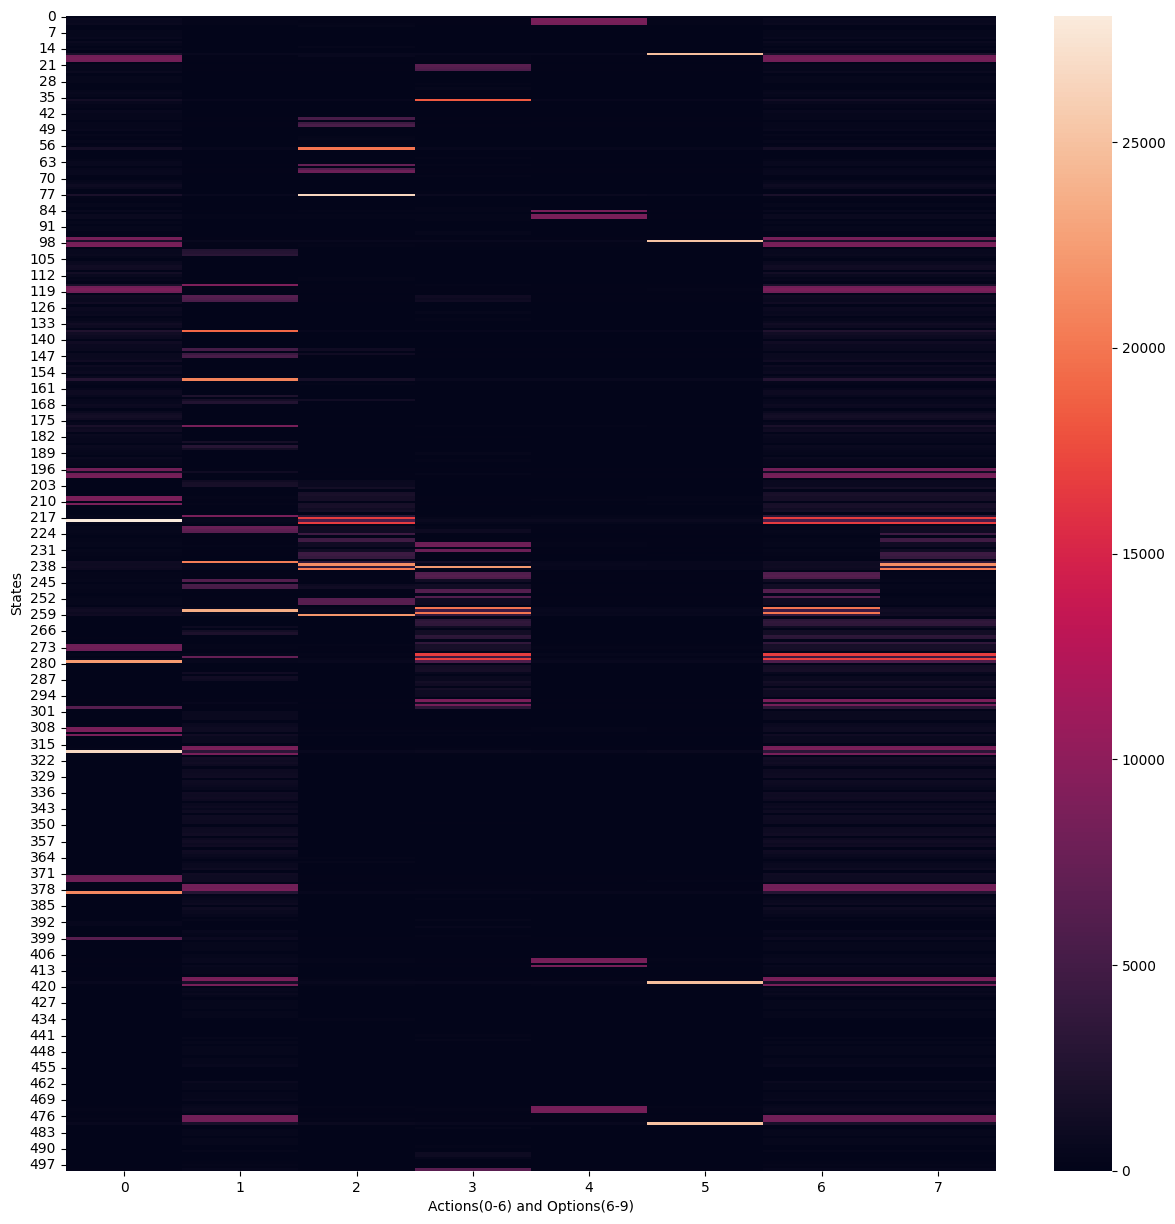

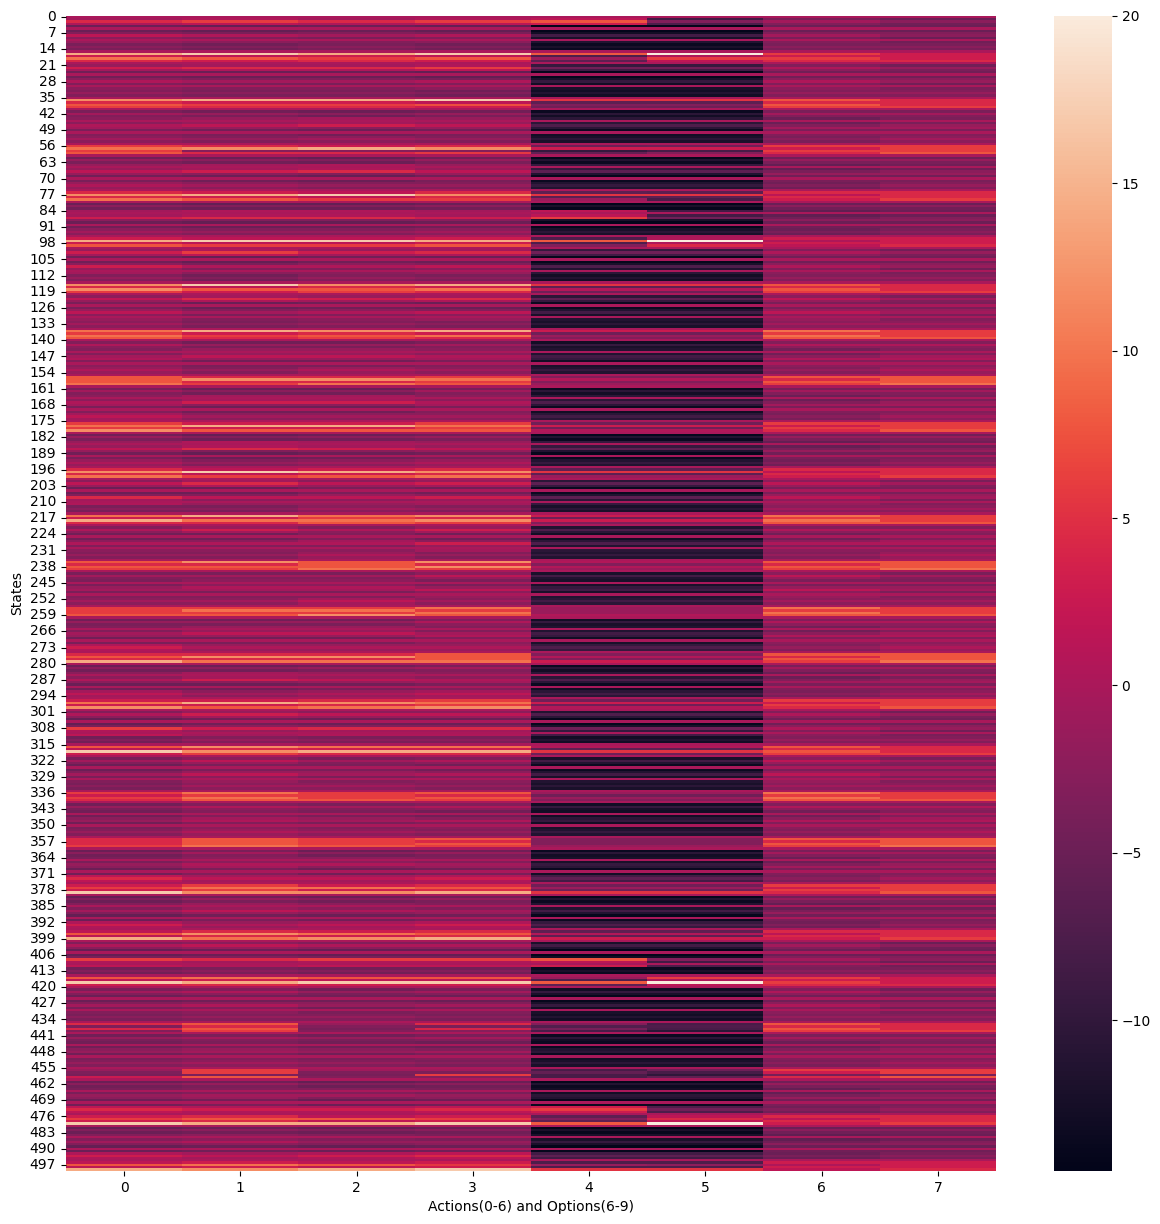

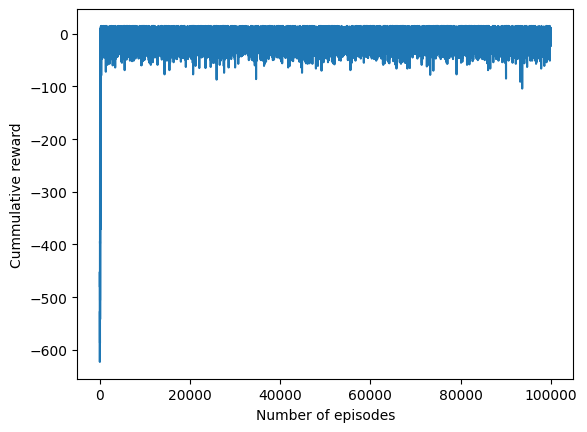

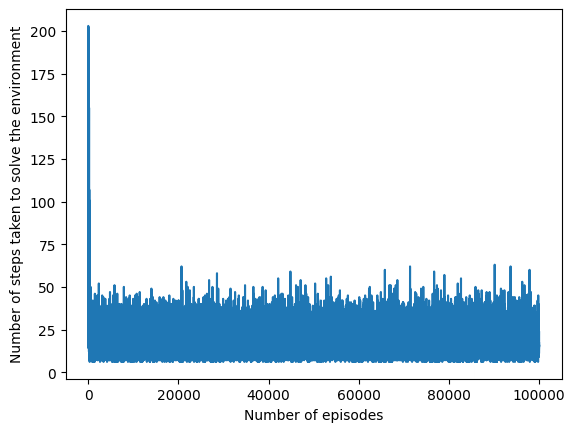

wandb: Agent Starting Run: fjc473fq with config:
wandb: 	EPS: 0.205314968847352
wandb: 	LR: 0.3
wandb: 	NUM_EPISODES: 10000


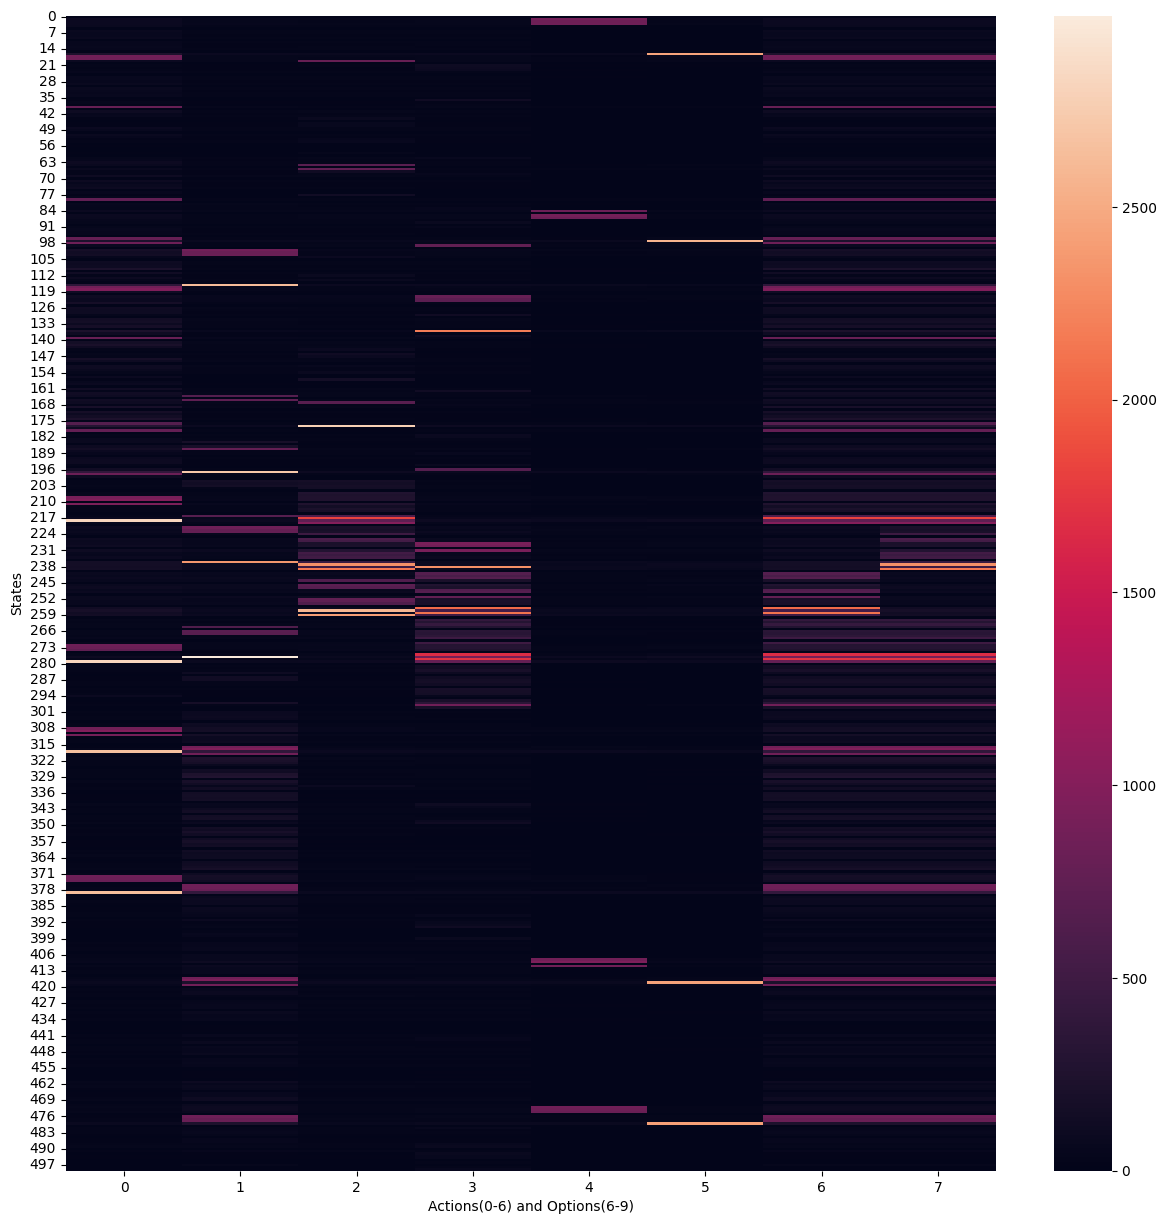

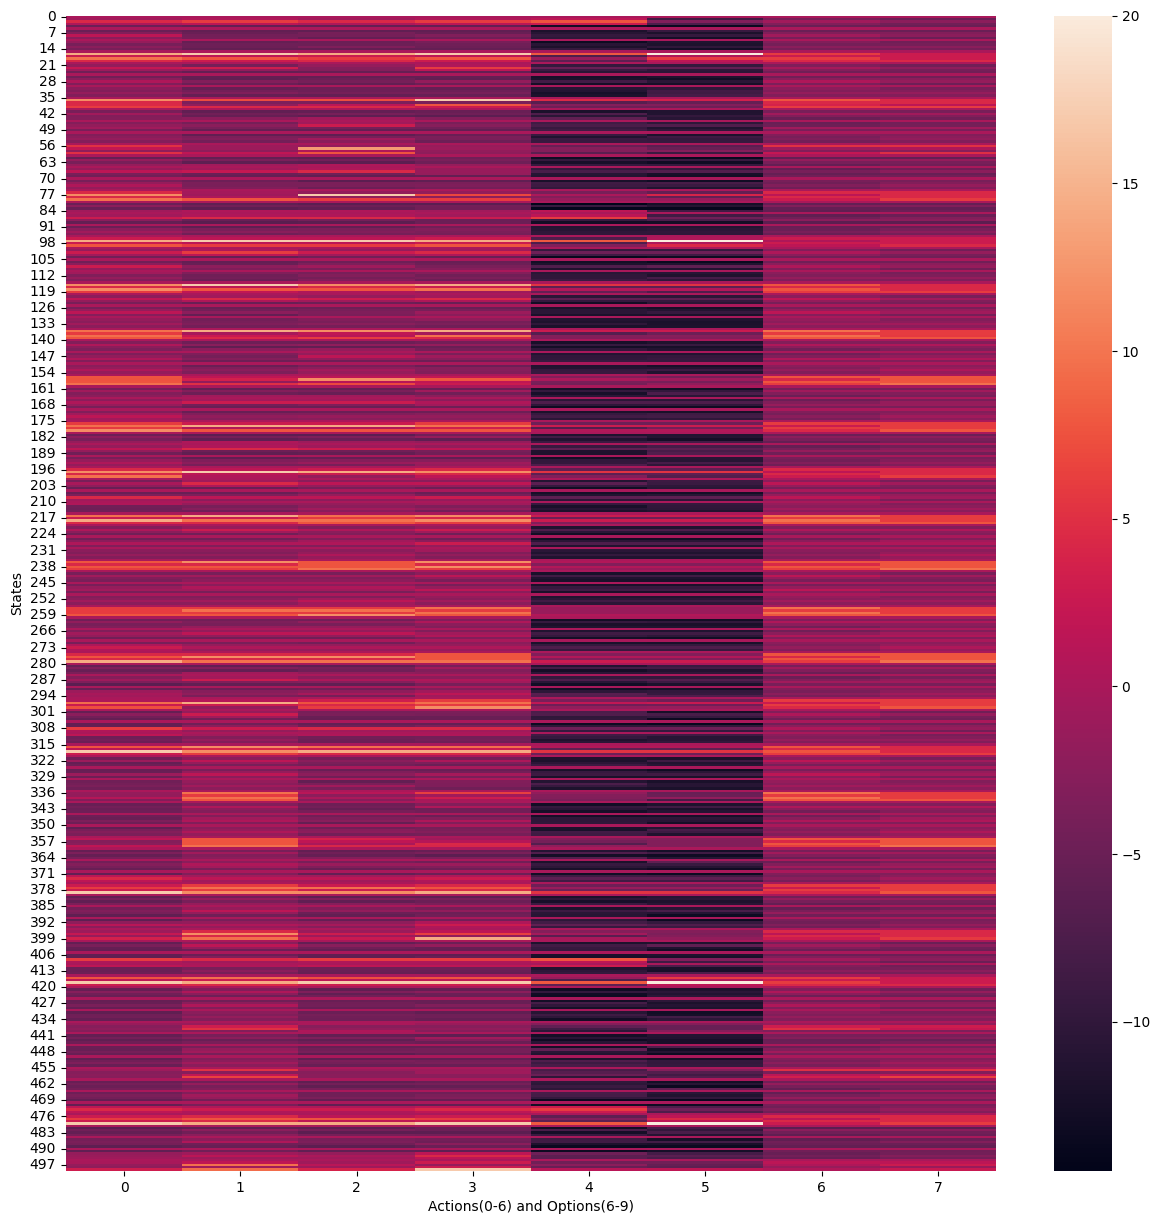

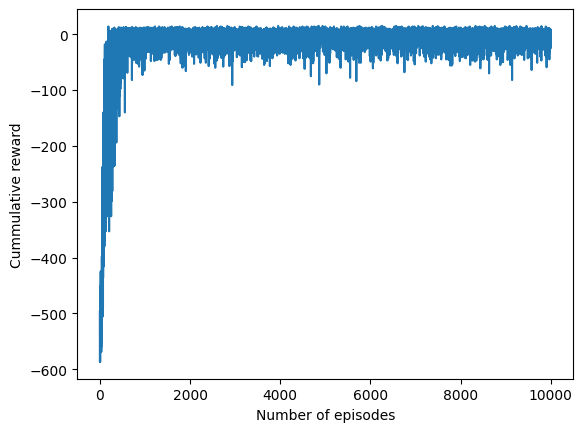

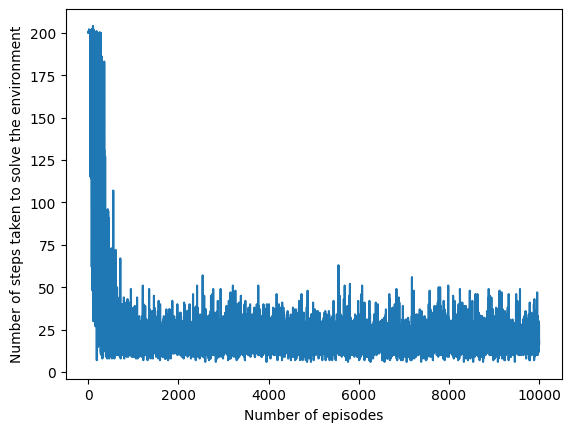

wandb: Agent Starting Run: q7dkbsp5 with config:
wandb: 	EPS: 0.10826981956758128
wandb: 	LR: 0.5
wandb: 	NUM_EPISODES: 100000


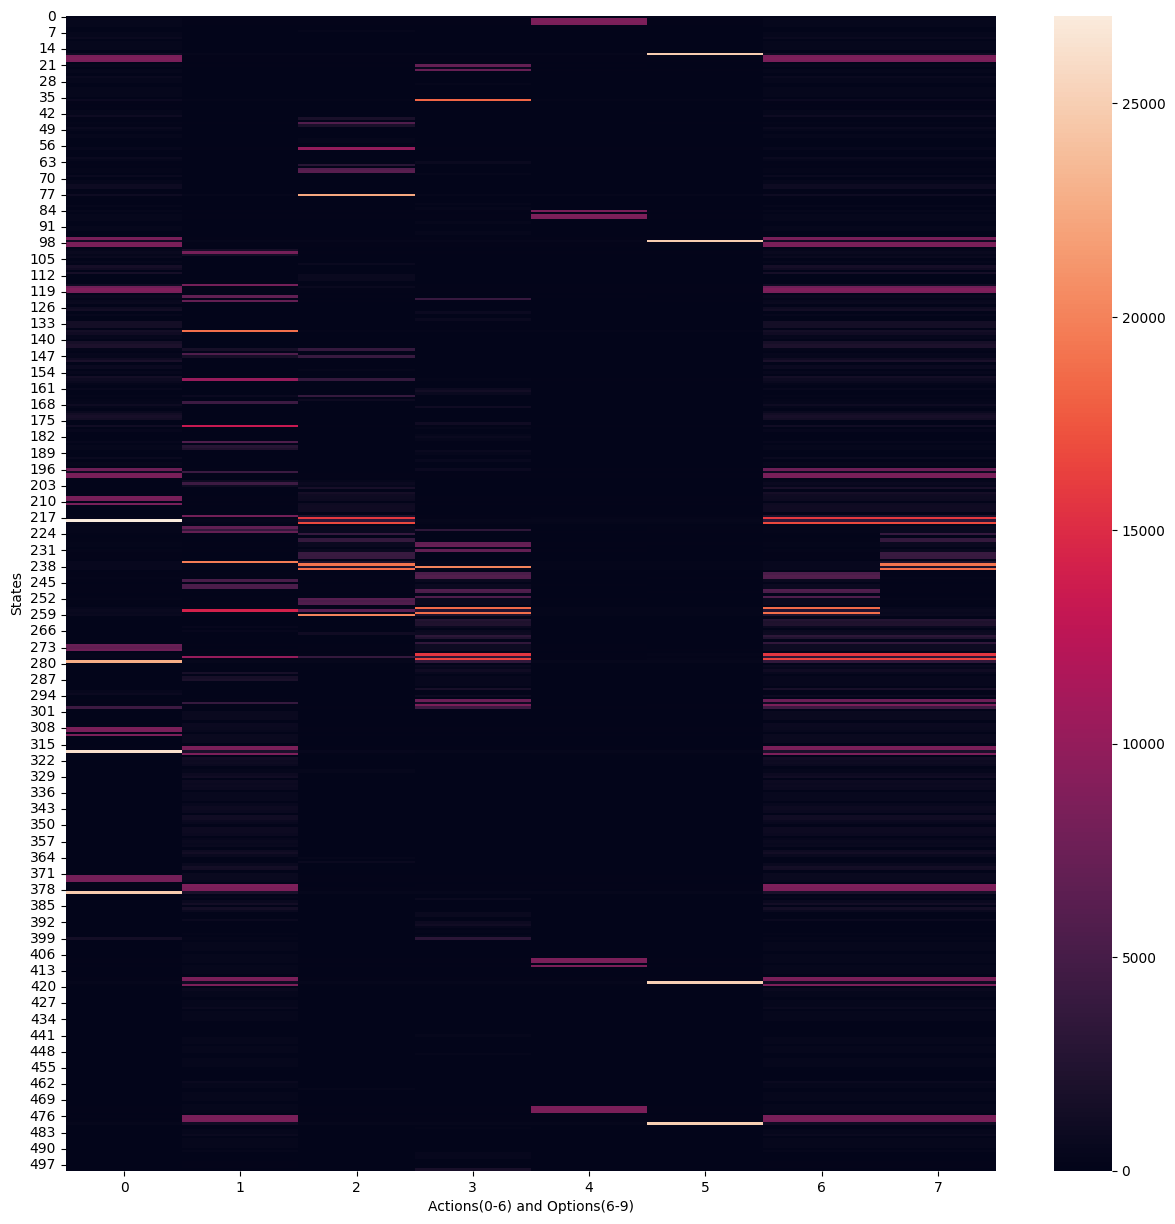

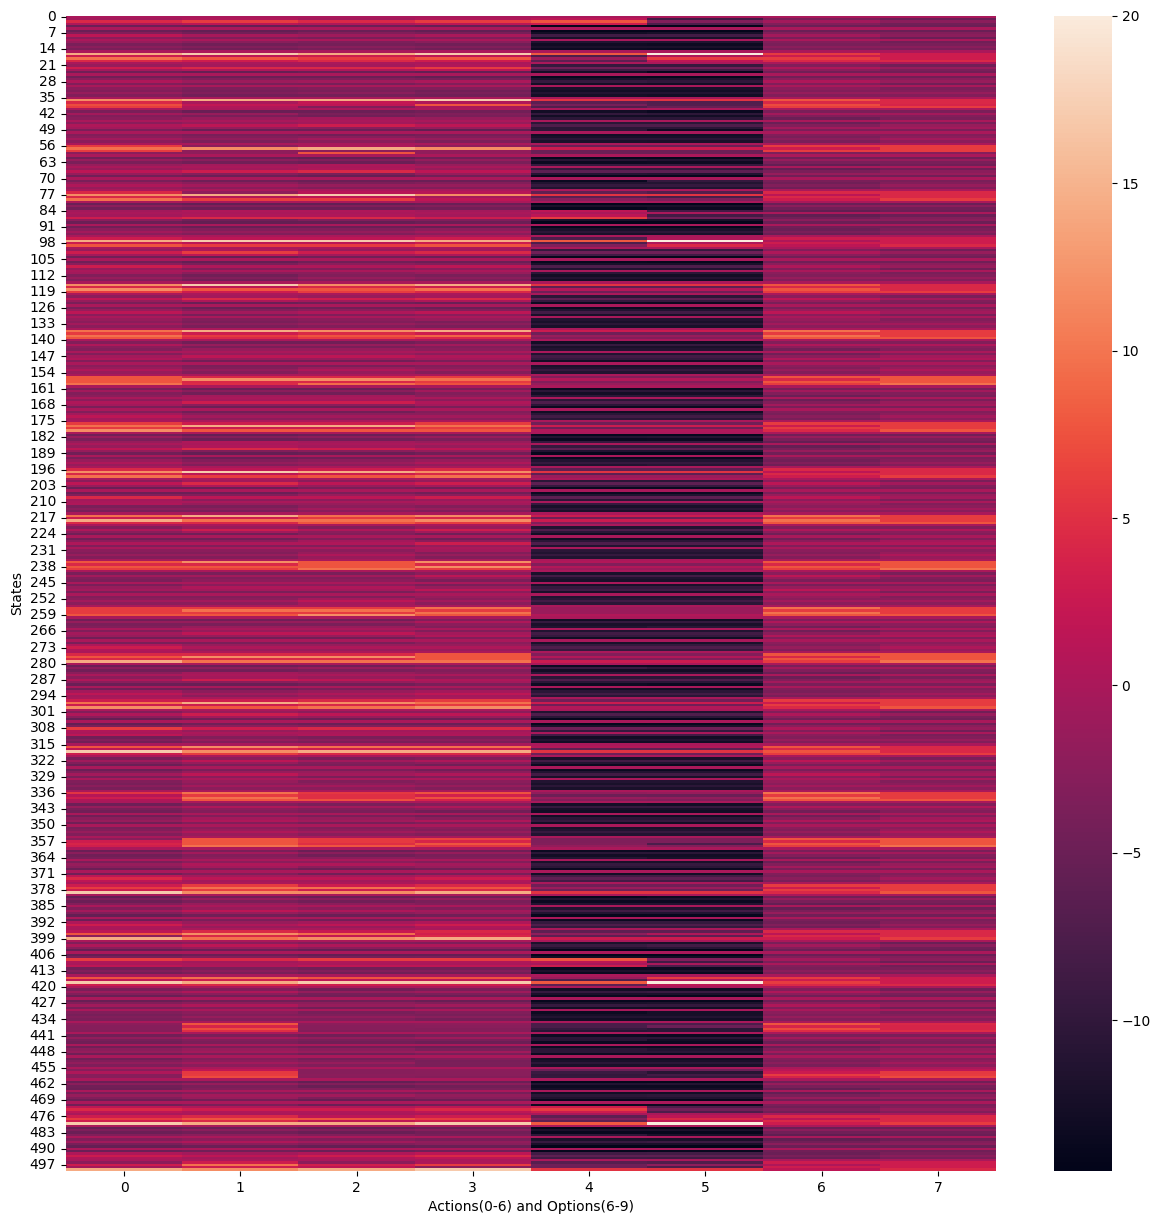

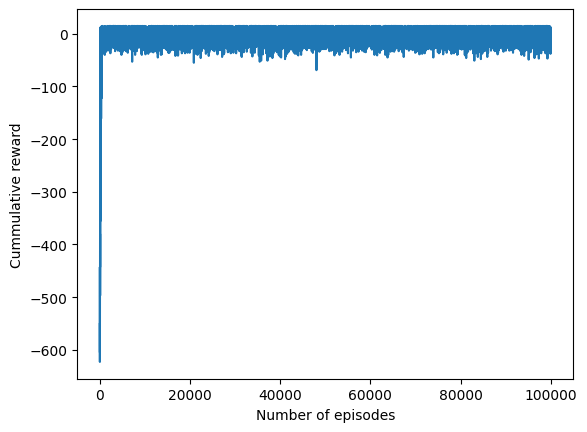

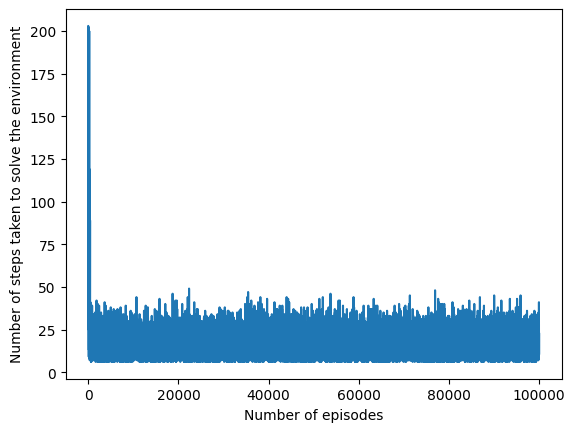

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3bkmoyvr with config:
wandb: 	EPS: 0.2486894213340537
wandb: 	LR: 0.3
wandb: 	NUM_EPISODES: 10000


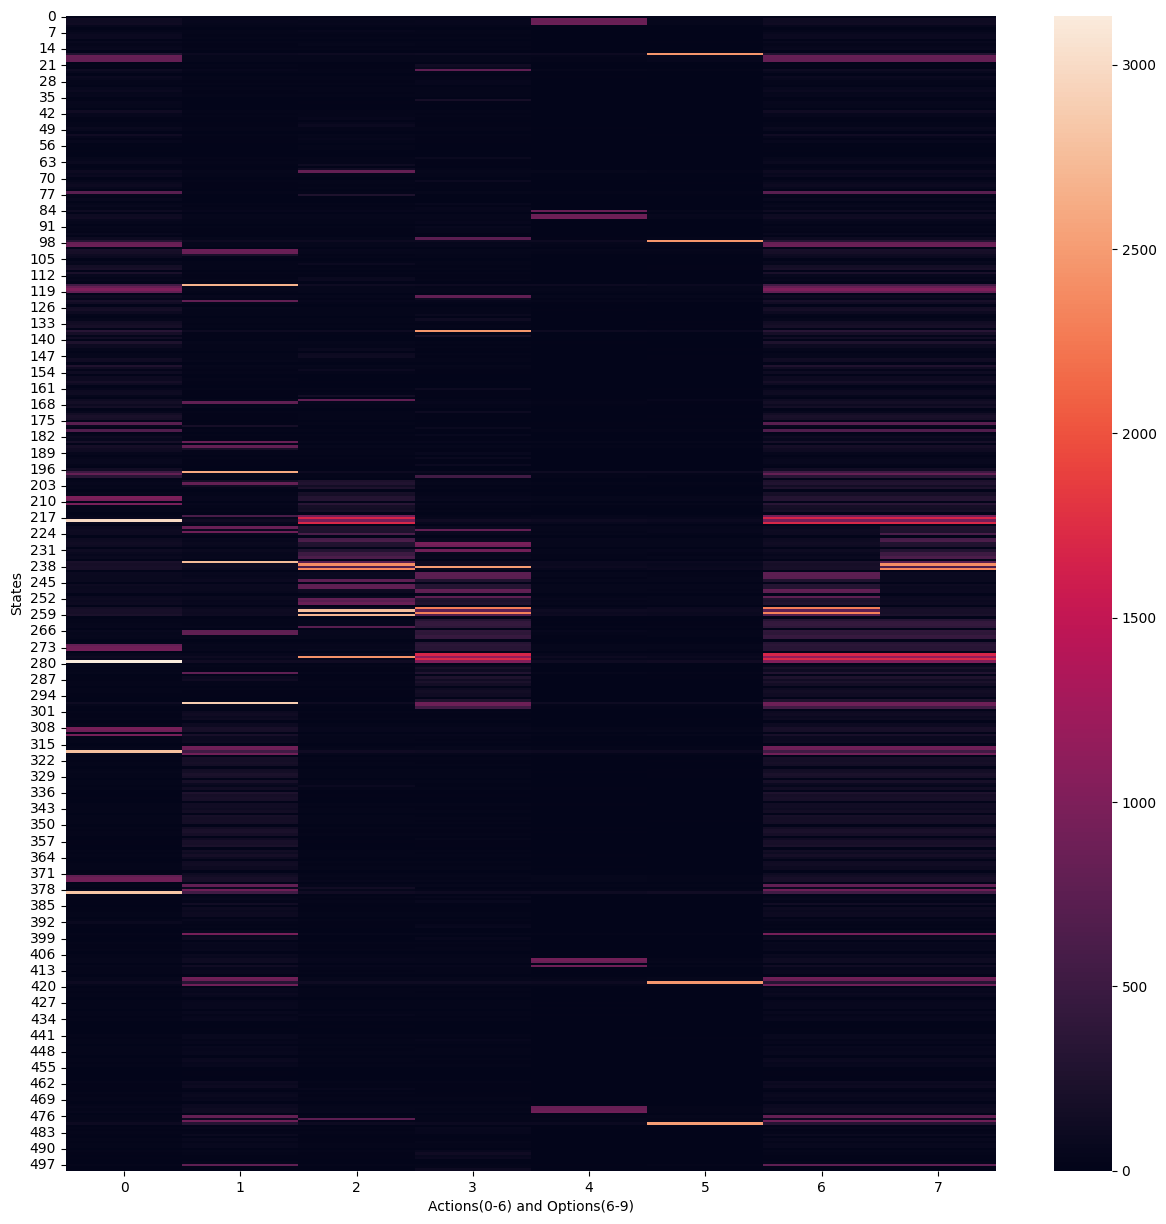

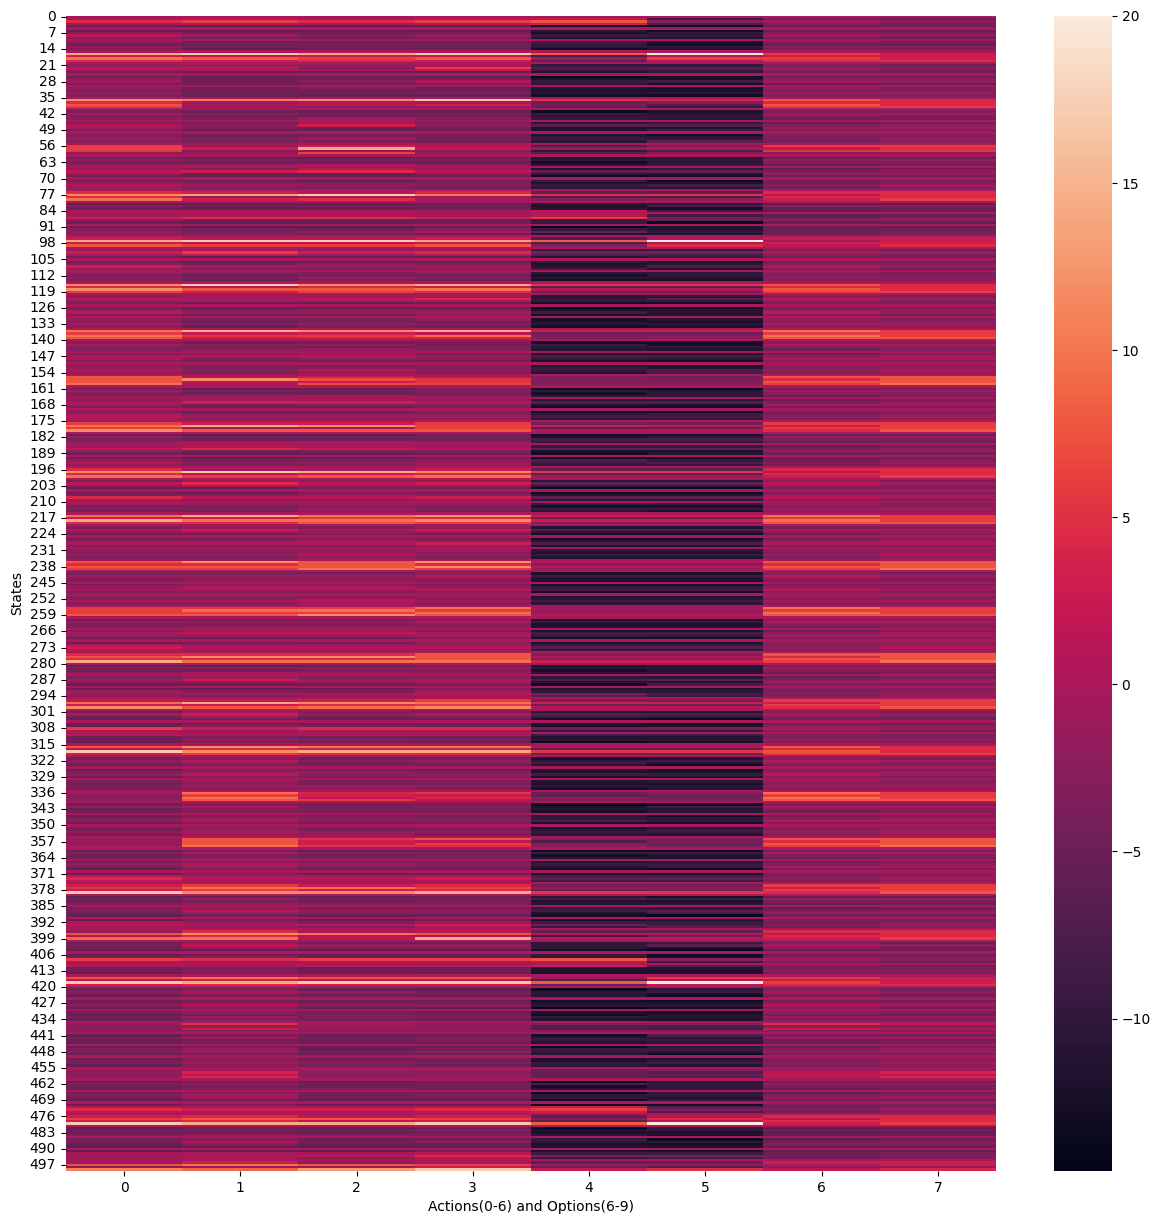

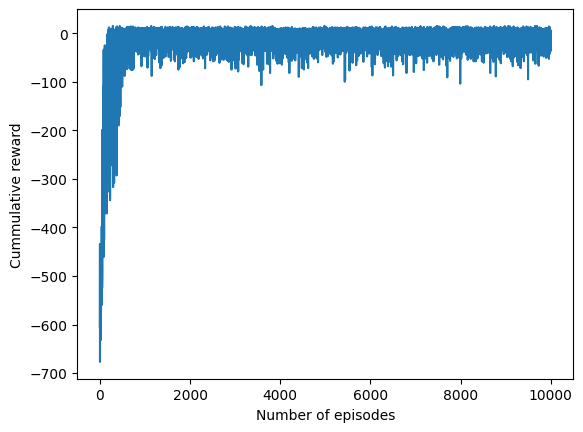

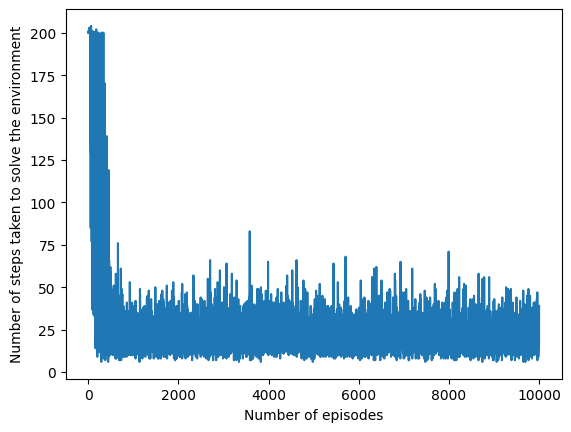

wandb: Agent Starting Run: y59bme77 with config:
wandb: 	EPS: 0.19436868714026104
wandb: 	LR: 0.3
wandb: 	NUM_EPISODES: 10000


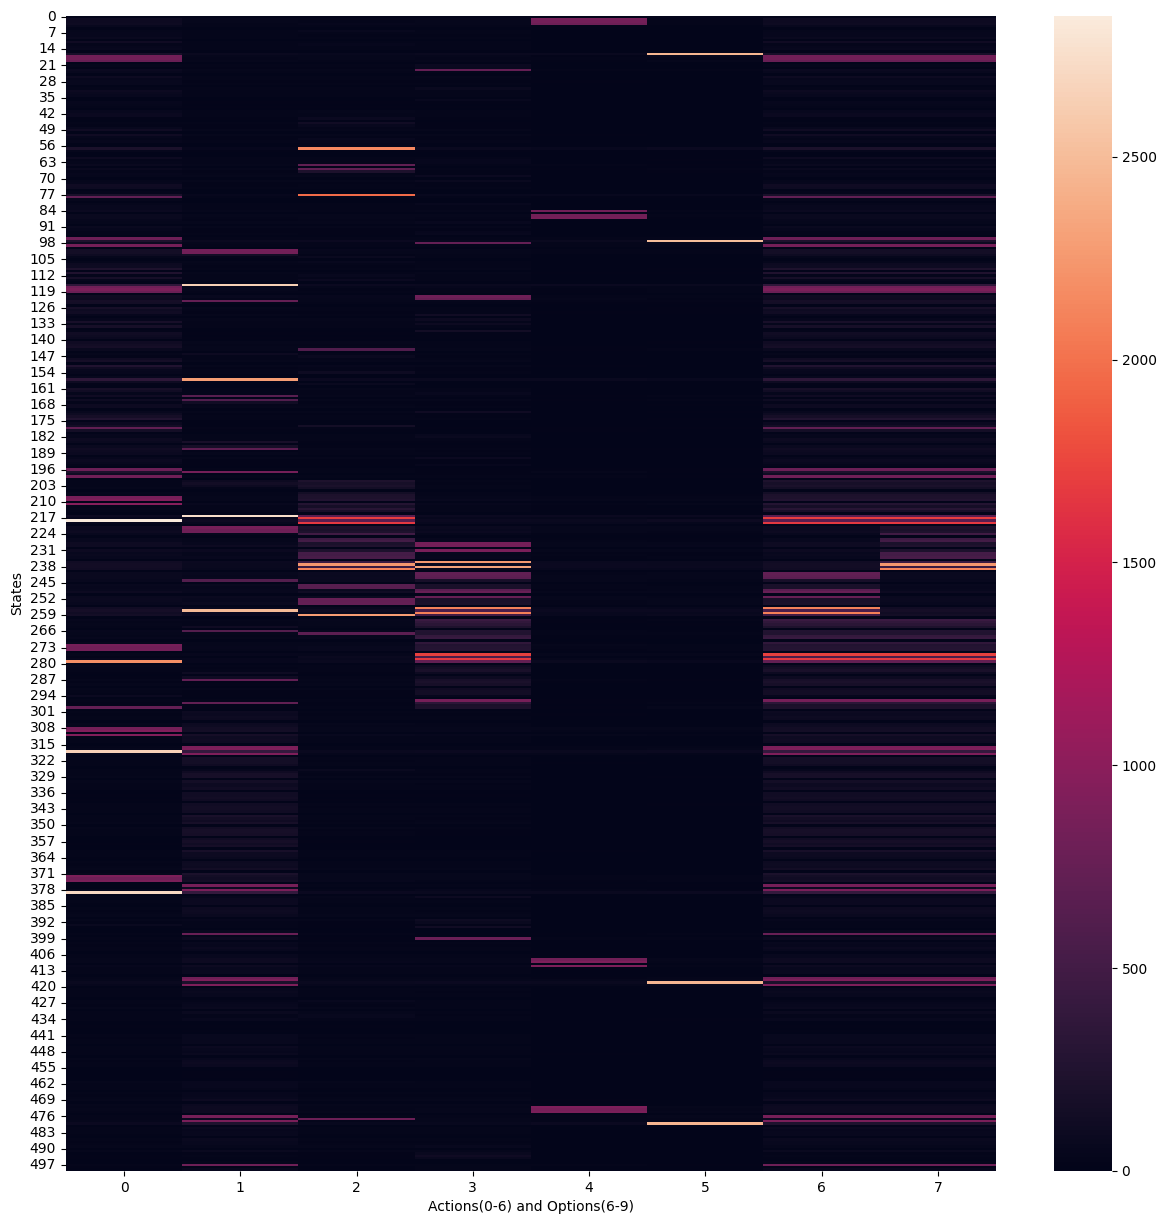

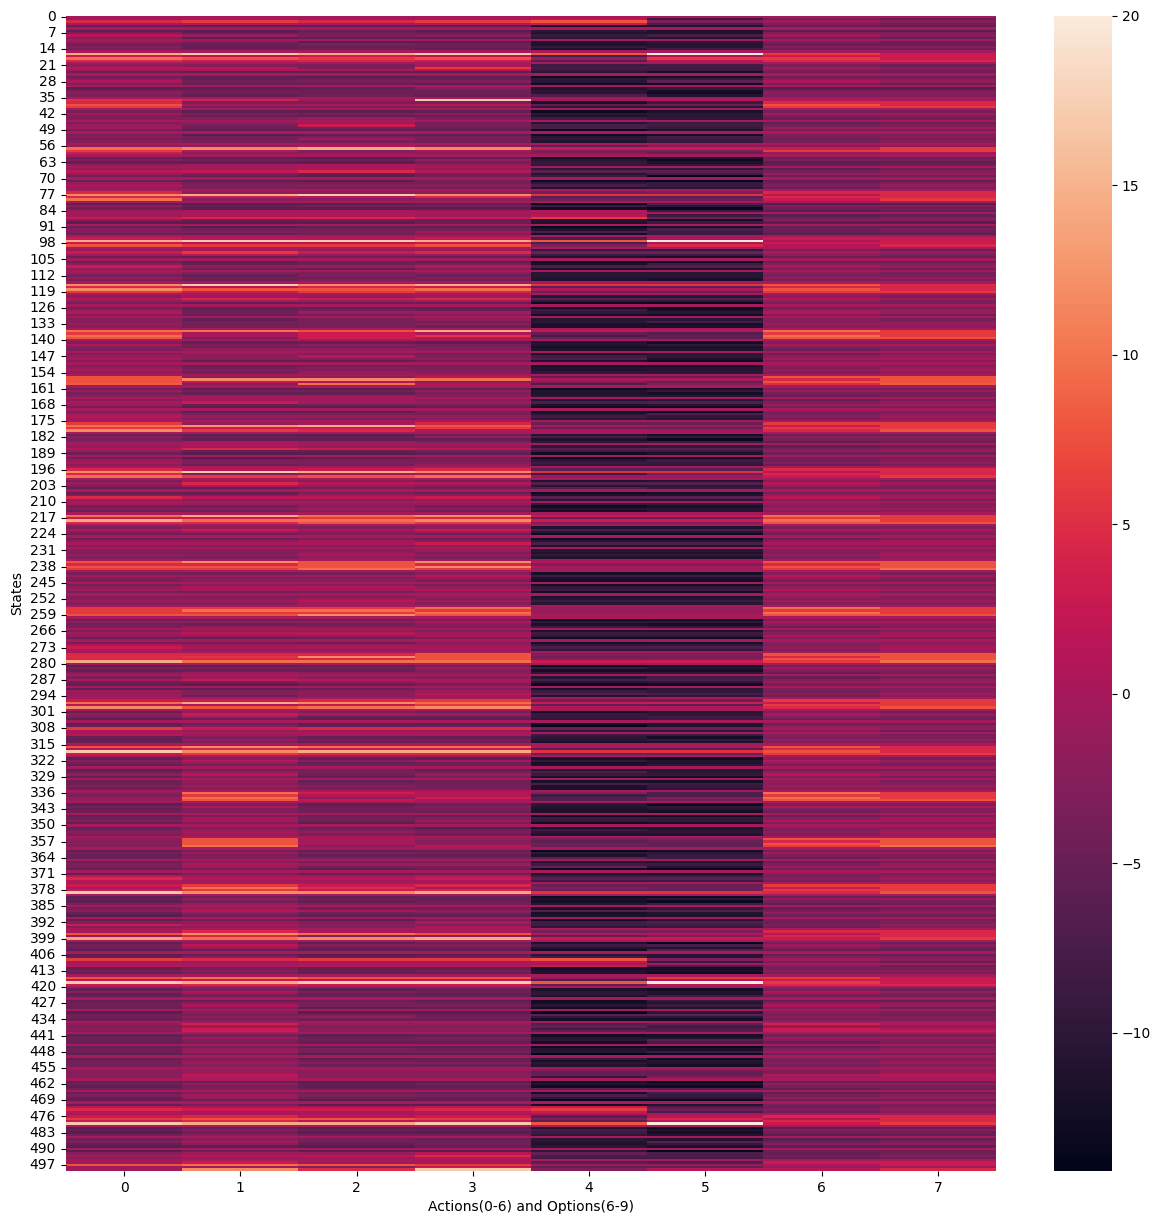

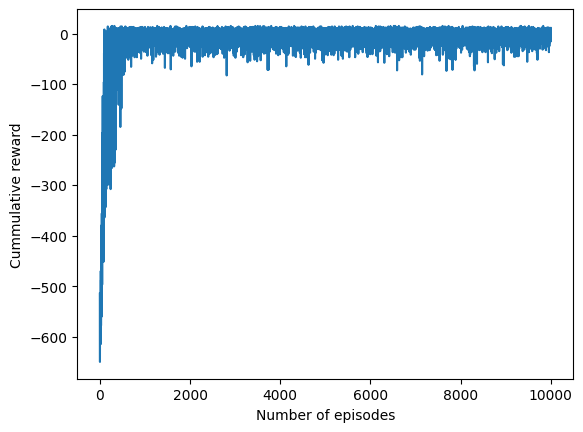

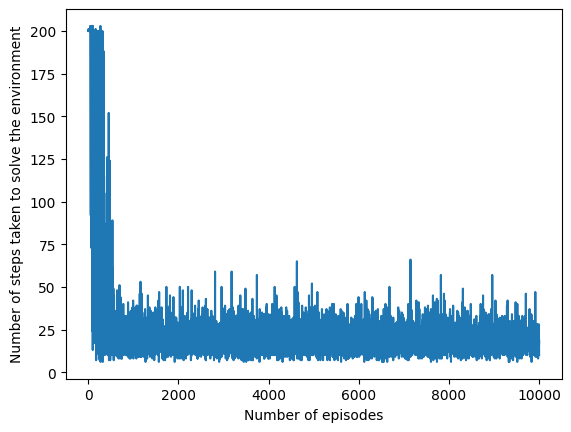

wandb: Agent Starting Run: 4klumtvt with config:
wandb: 	EPS: 0.16177878439932258
wandb: 	LR: 0.01
wandb: 	NUM_EPISODES: 50000


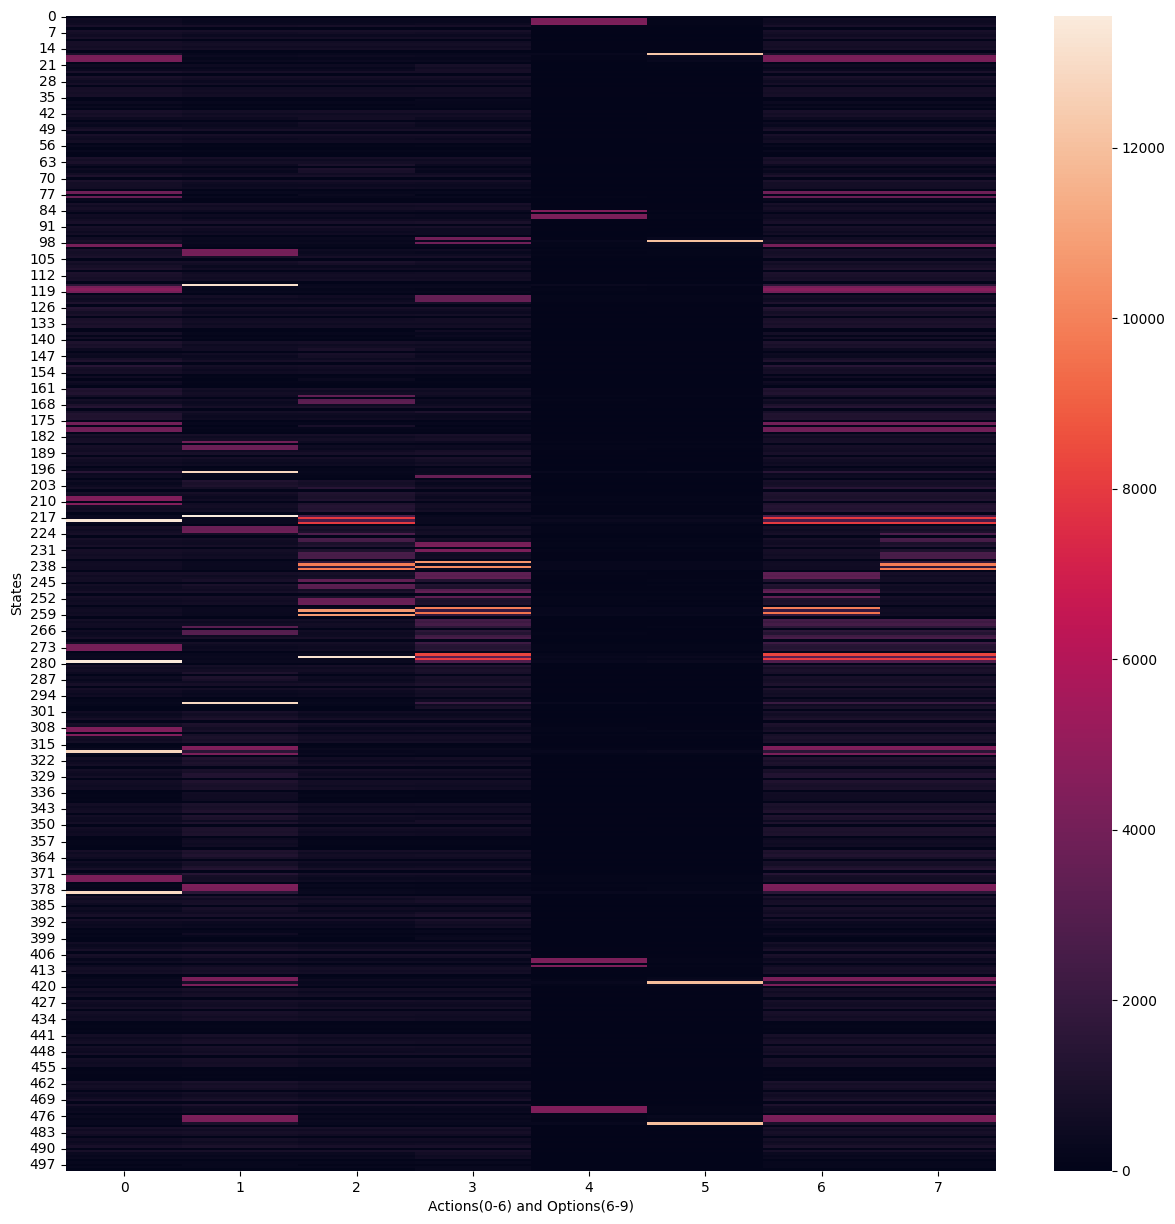

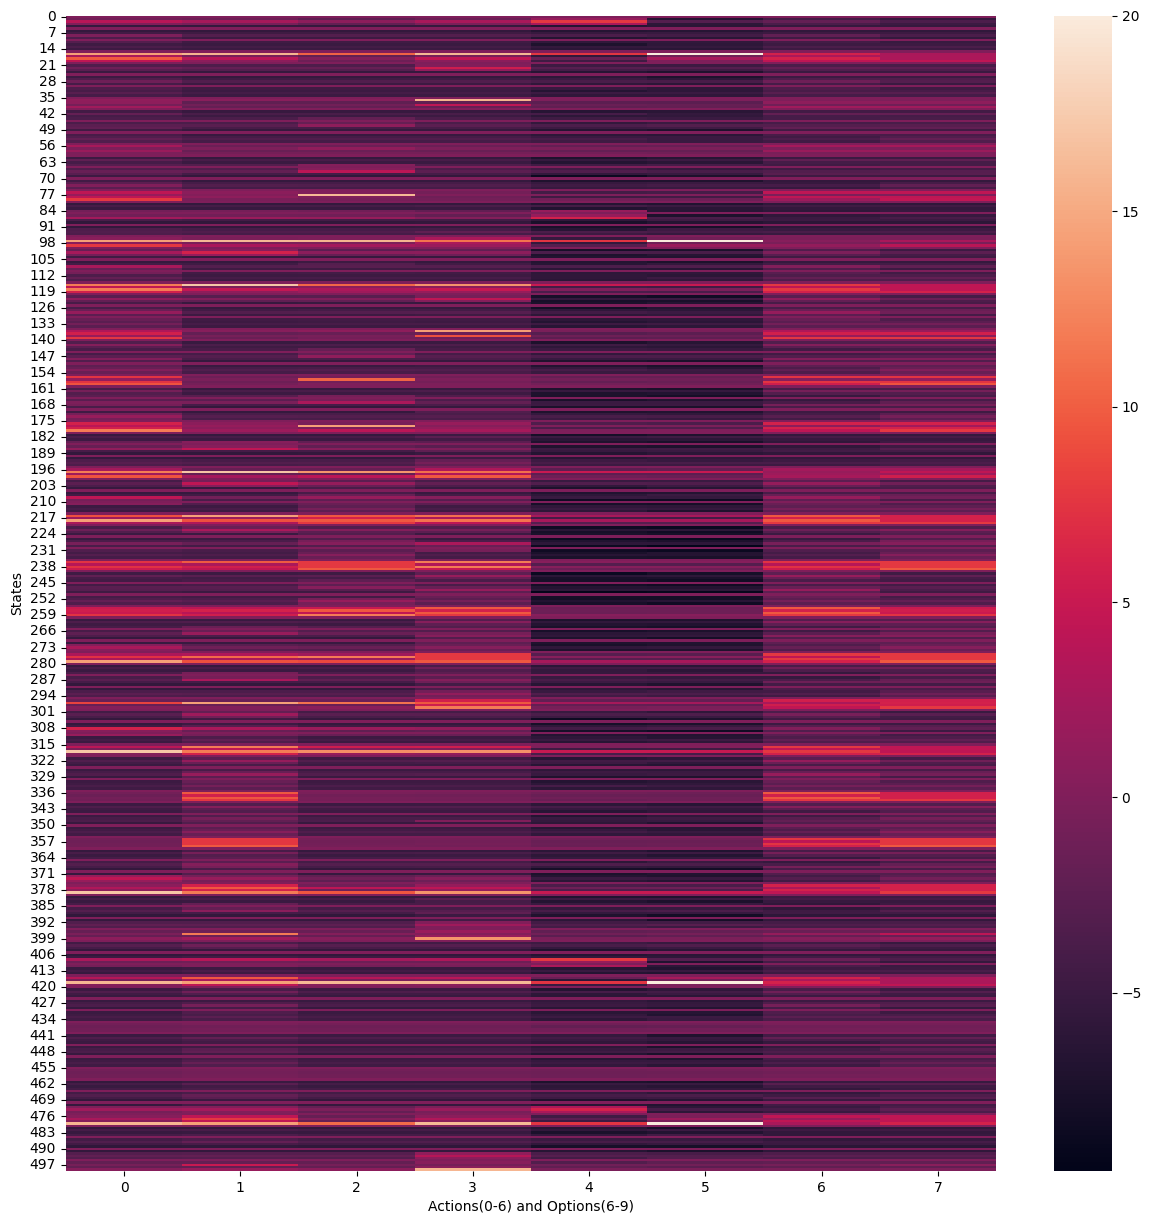

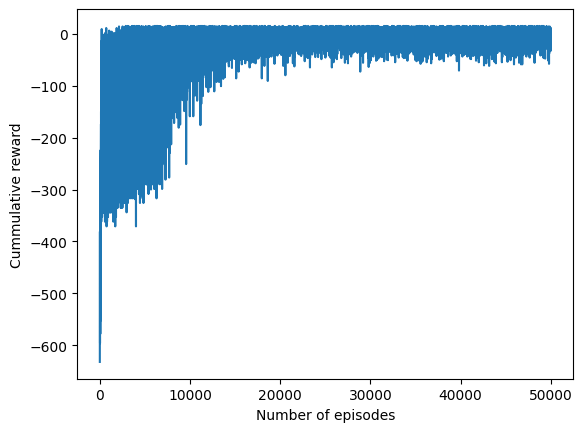

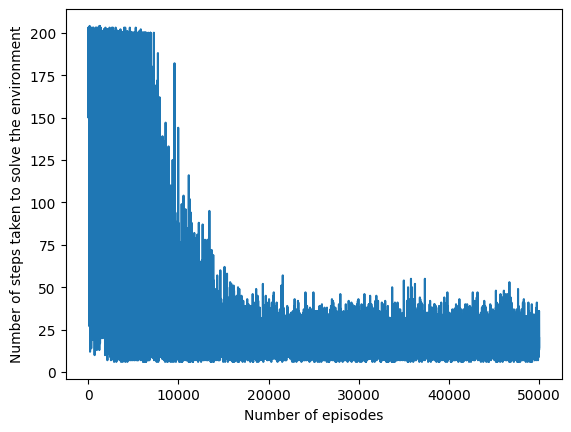

wandb: Agent Starting Run: ioi2cz4s with config:
wandb: 	EPS: 0.2928691281491568
wandb: 	LR: 0.2
wandb: 	NUM_EPISODES: 200000


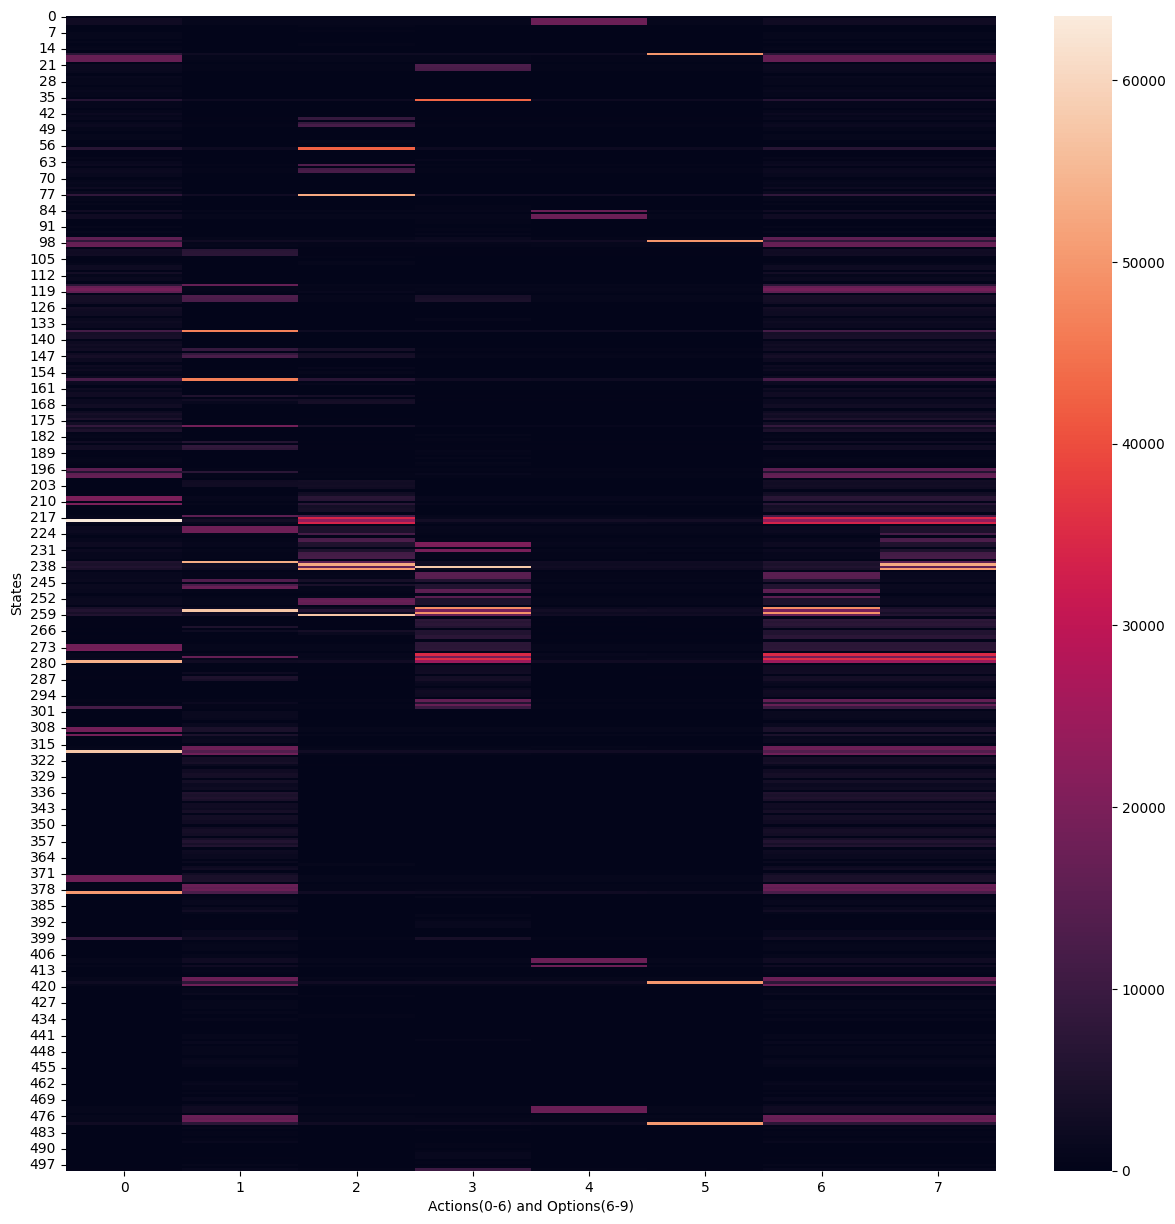

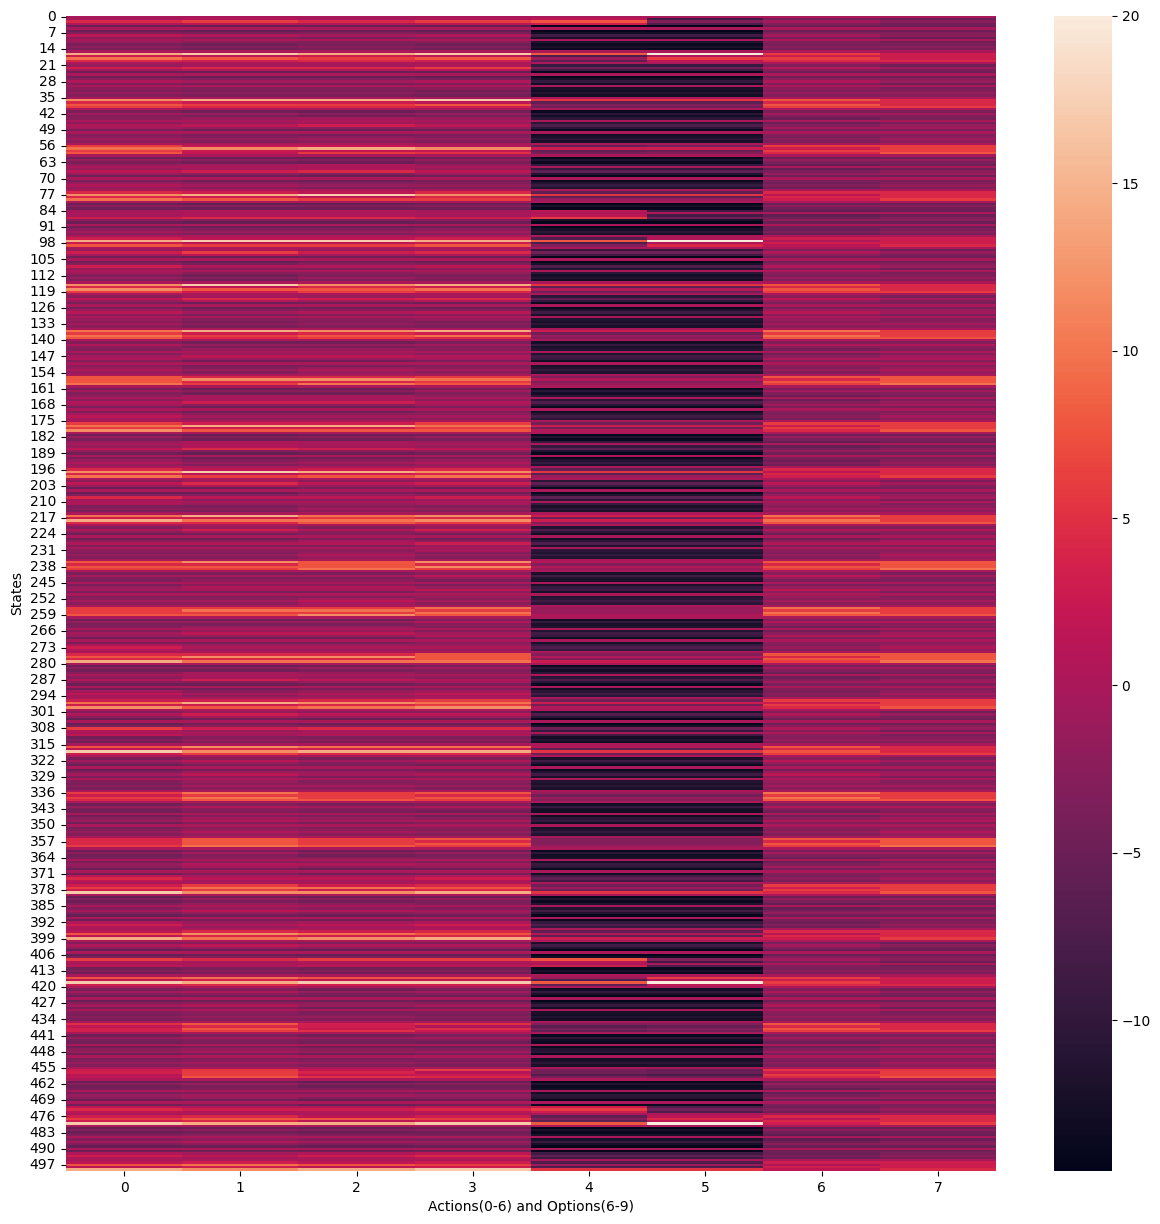

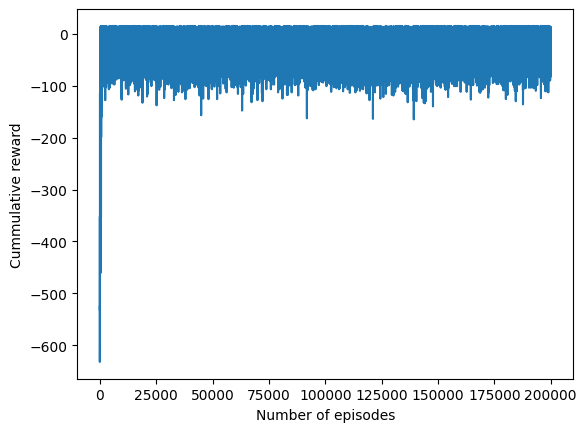

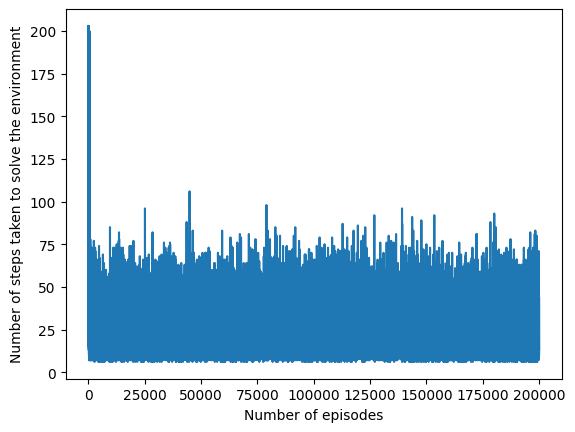

wandb: Agent Starting Run: 5c3mkec1 with config:
wandb: 	EPS: 0.2379659673134288
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 50000


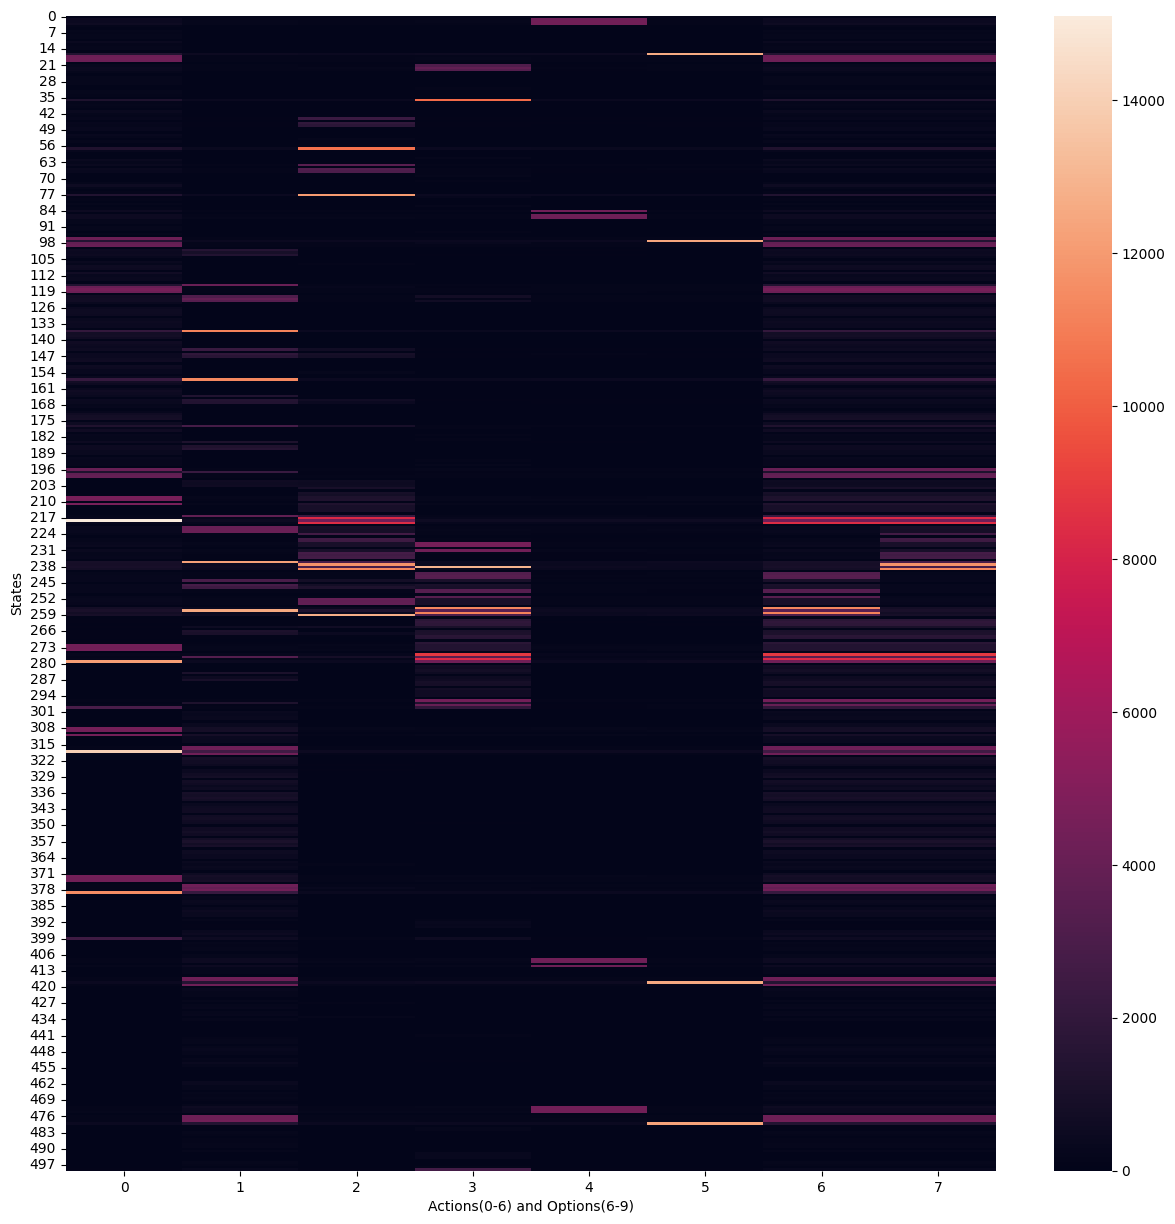

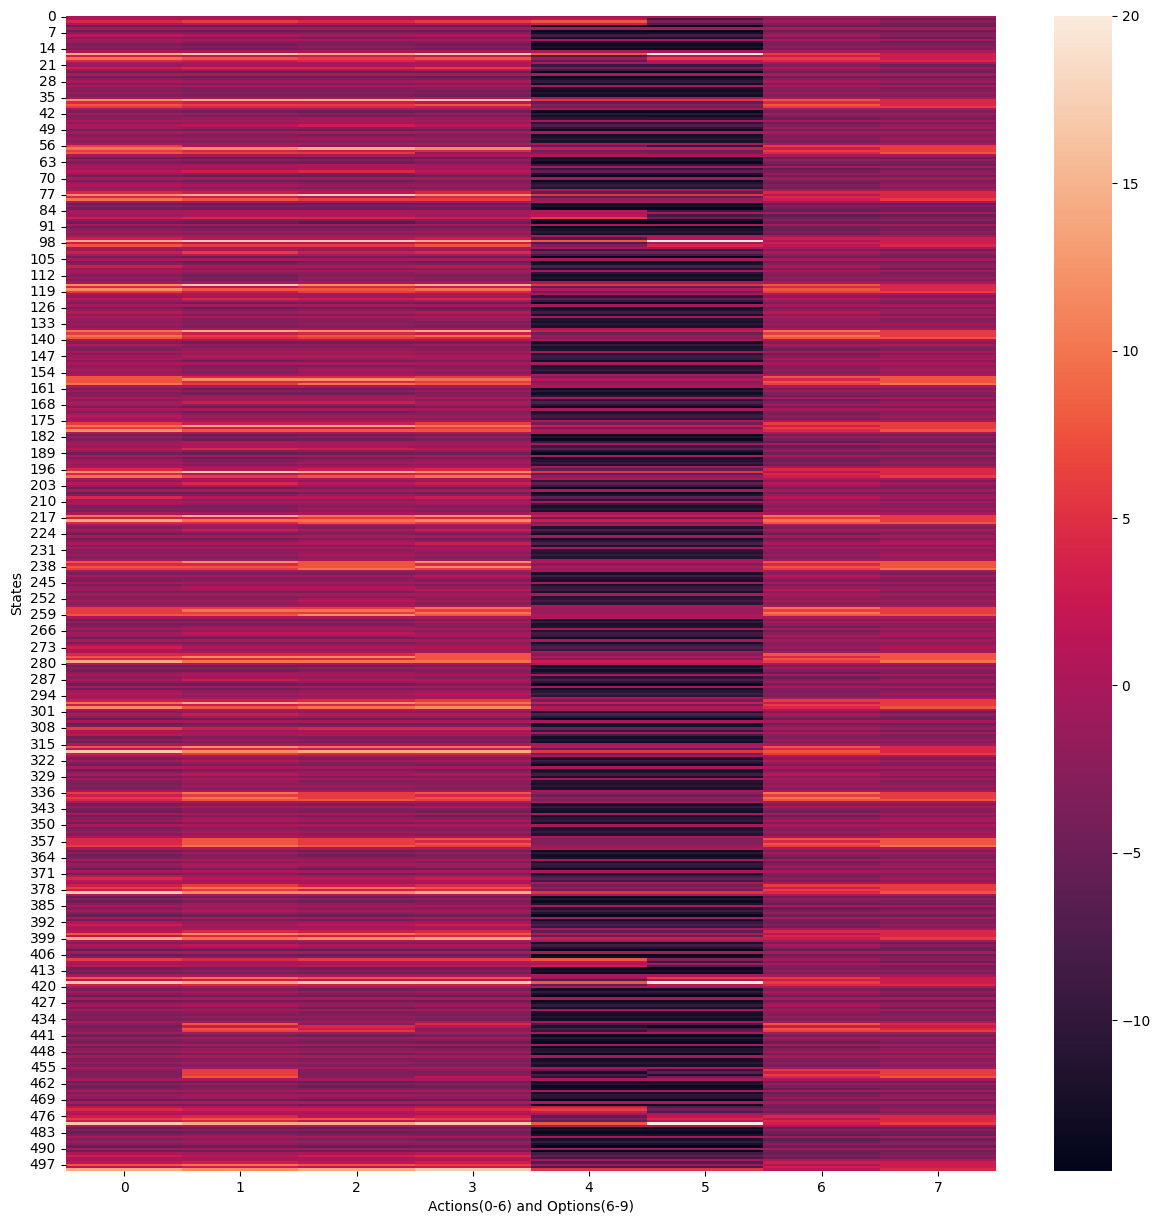

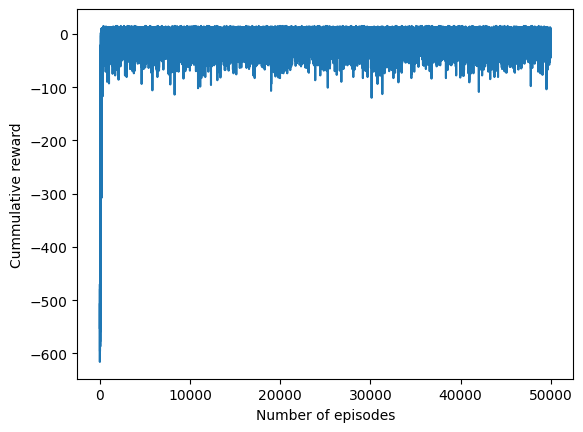

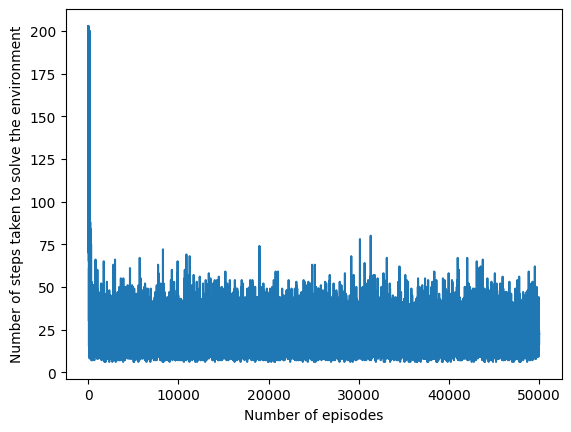

wandb: Agent Starting Run: 344psv6a with config:
wandb: 	EPS: 0.27210778002326363
wandb: 	LR: 0.1
wandb: 	NUM_EPISODES: 200000


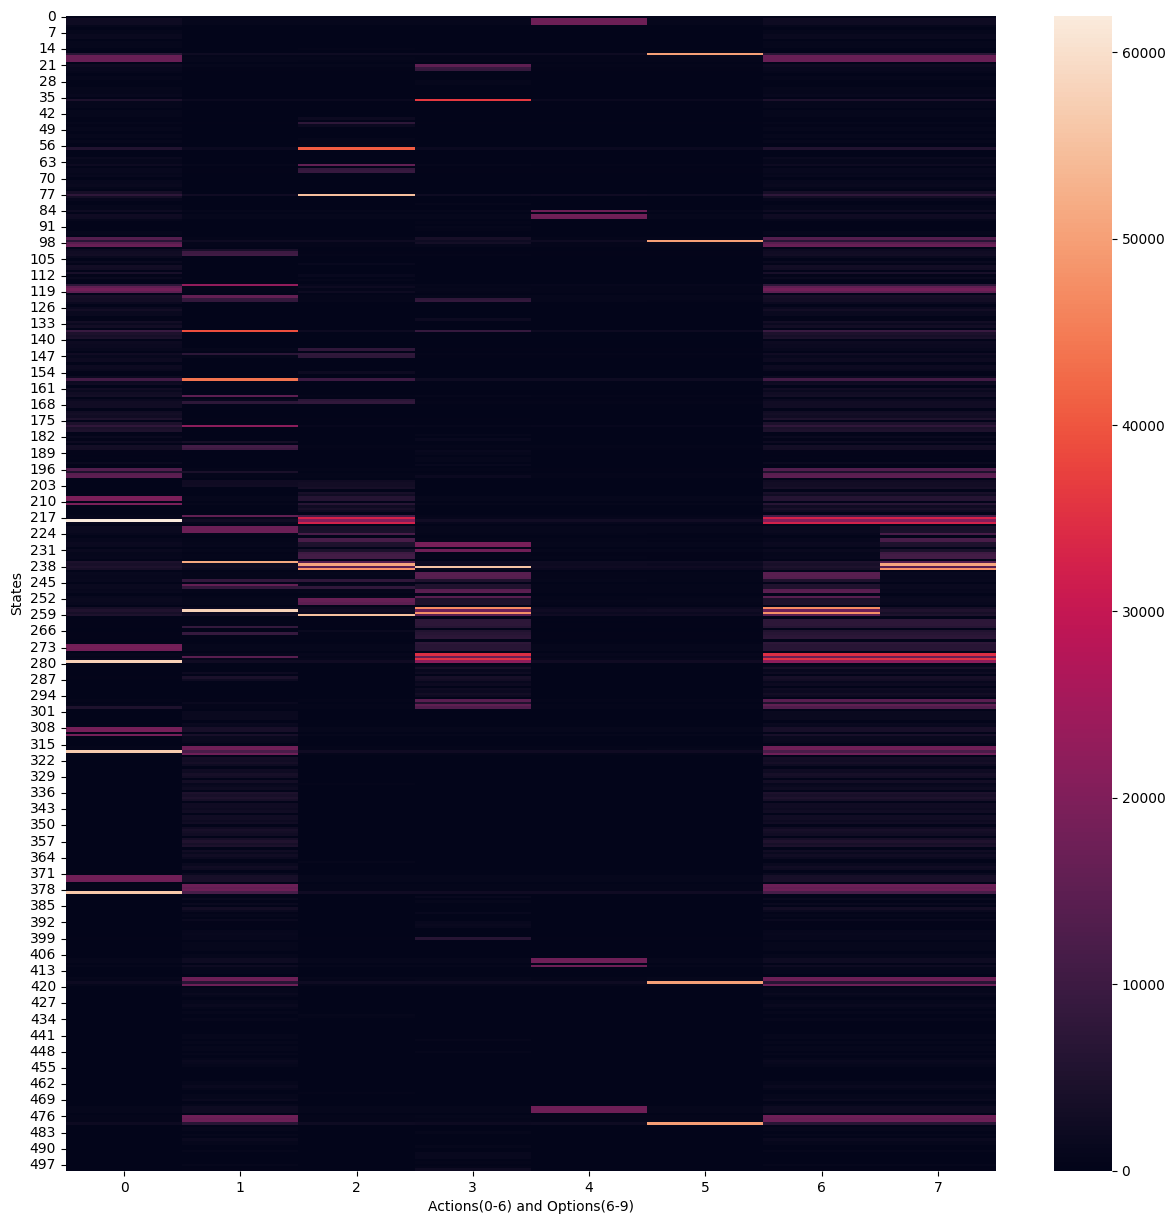

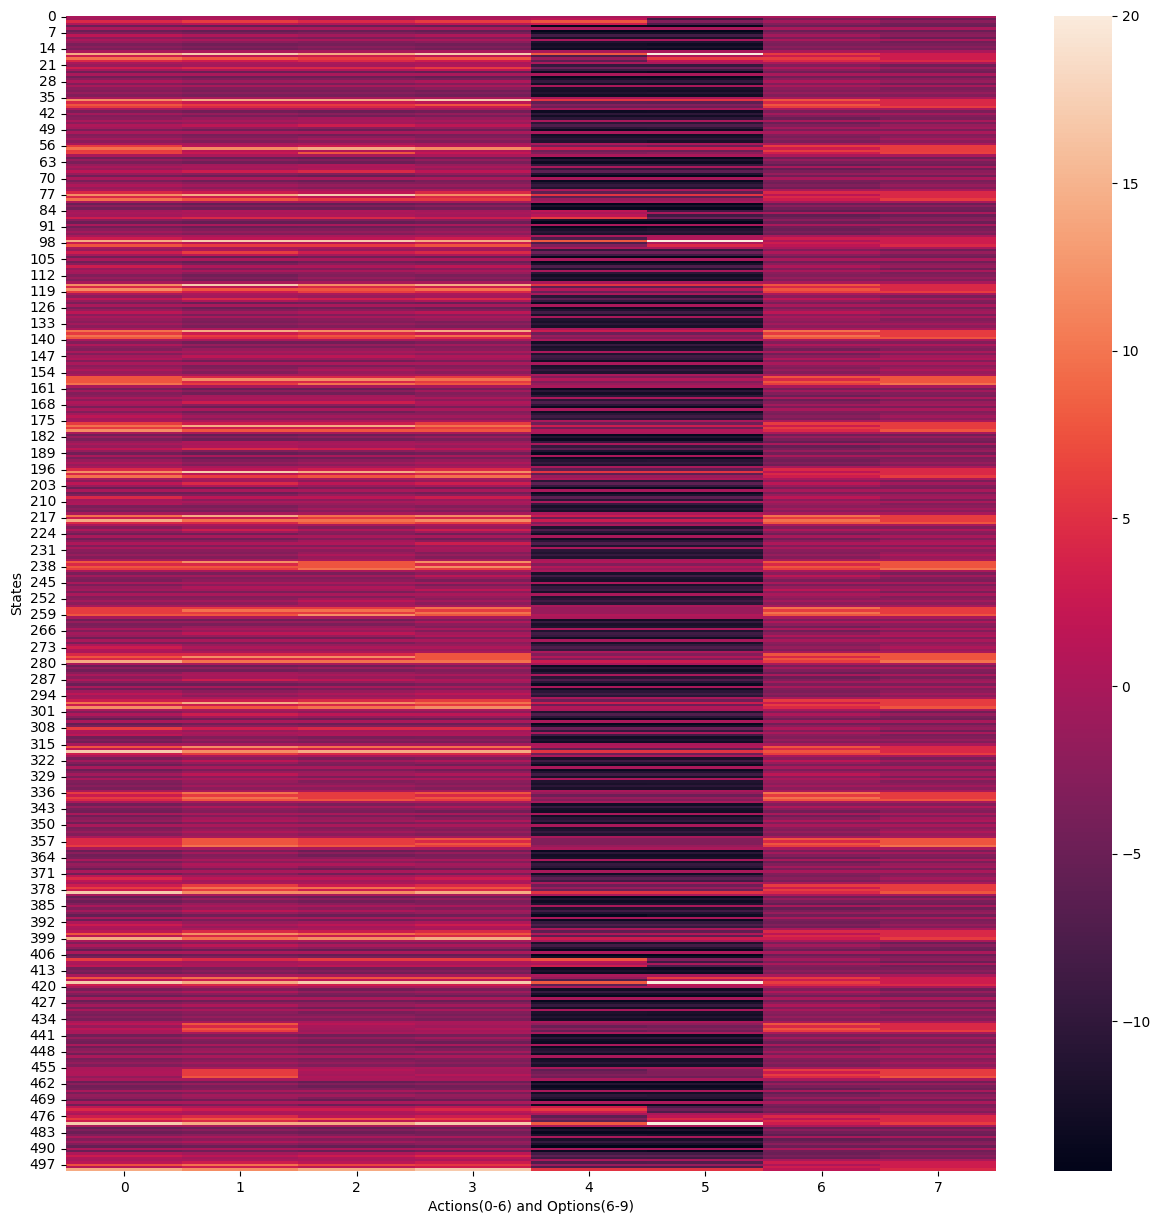

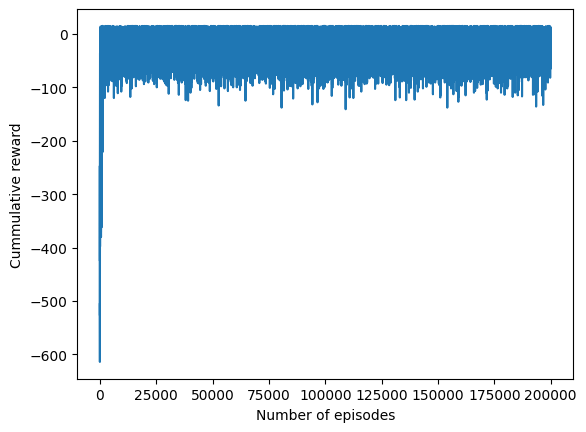

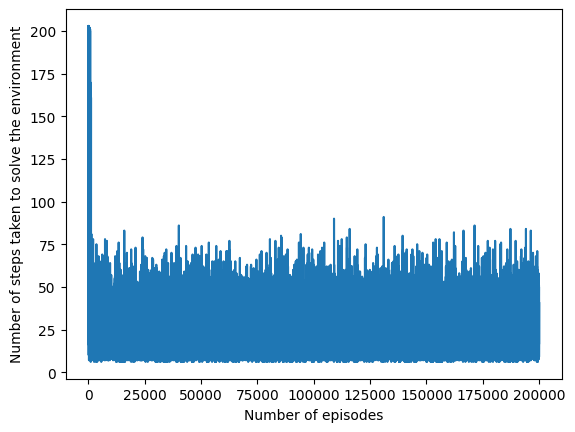

wandb: Agent Starting Run: er9lapv3 with config:
wandb: 	EPS: 0.2487309162064021
wandb: 	LR: 0.01
wandb: 	NUM_EPISODES: 50000


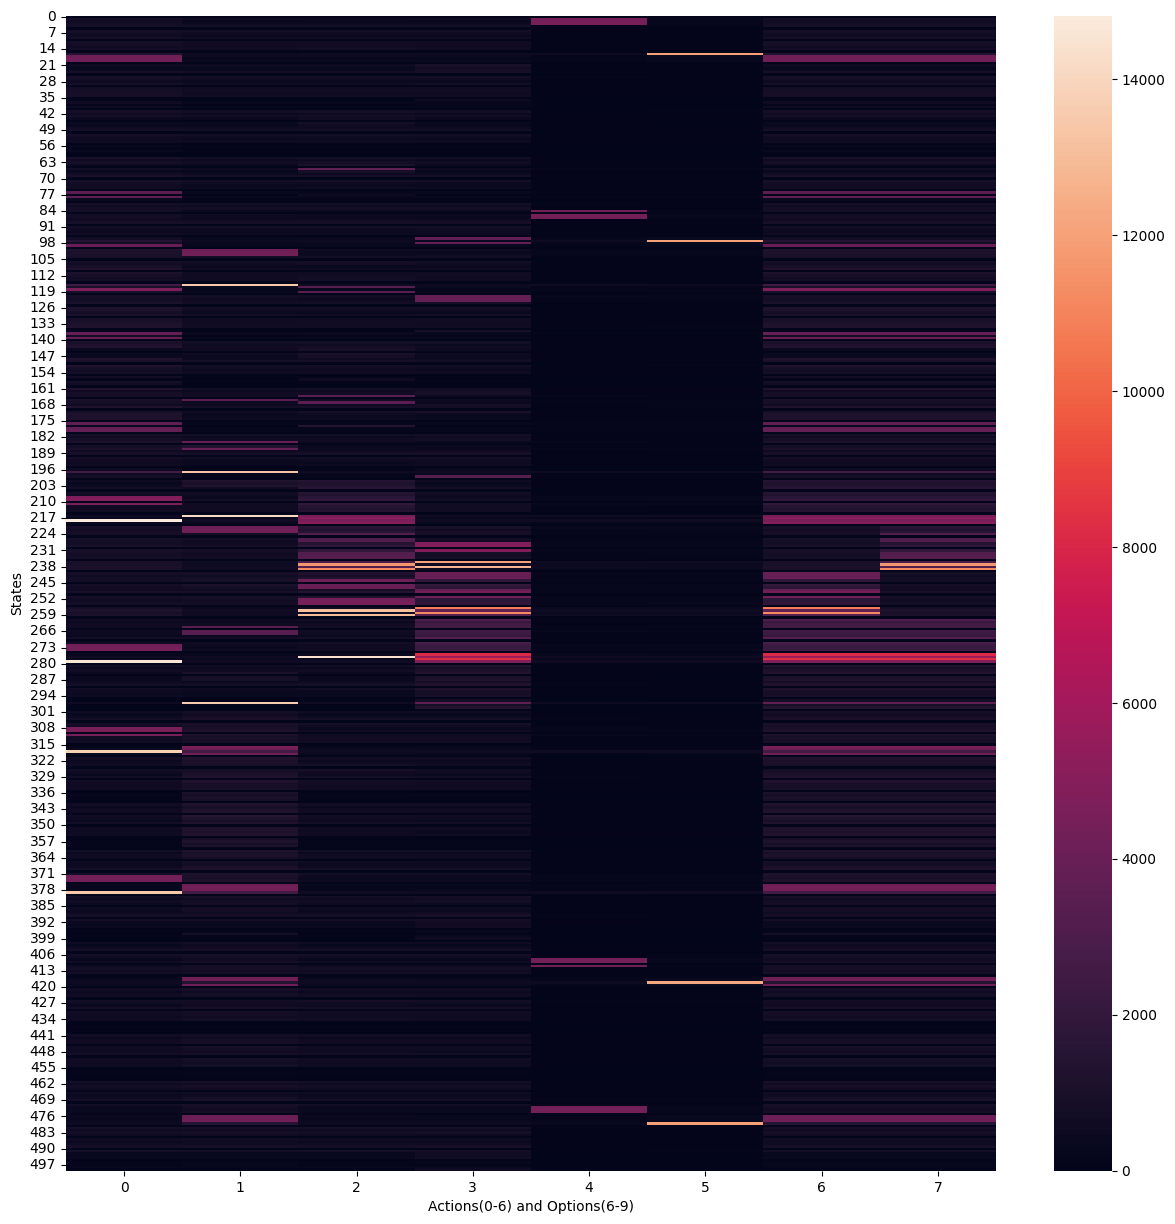

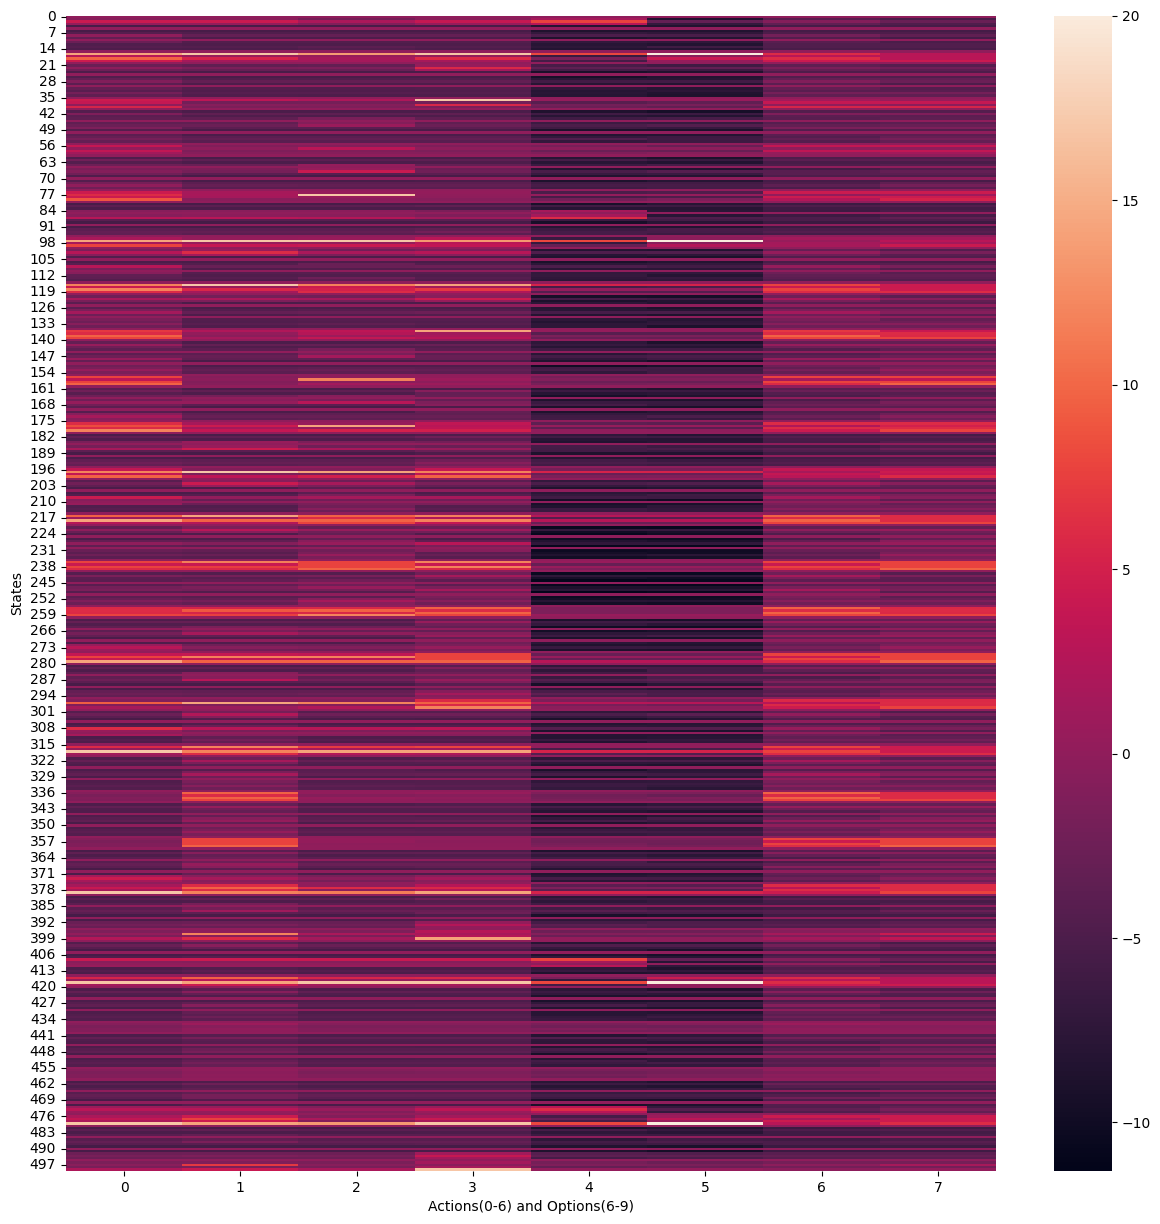

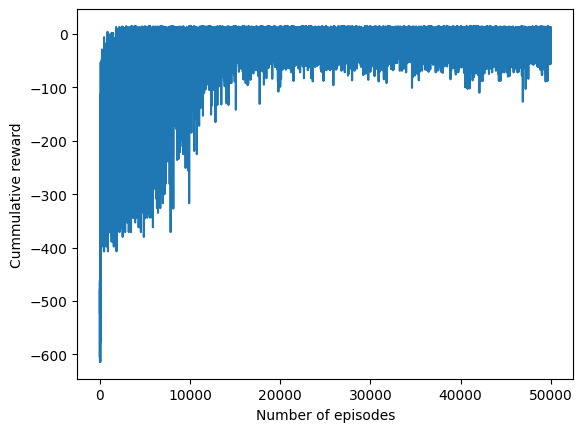

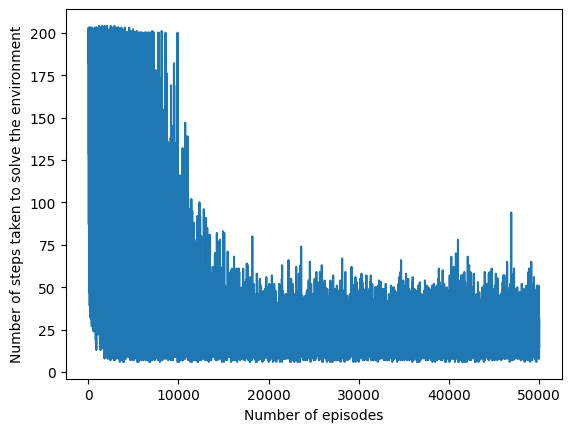

wandb: Agent Starting Run: uz05zzd7 with config:
wandb: 	EPS: 0.27026115237873755
wandb: 	LR: 0.2
wandb: 	NUM_EPISODES: 10000


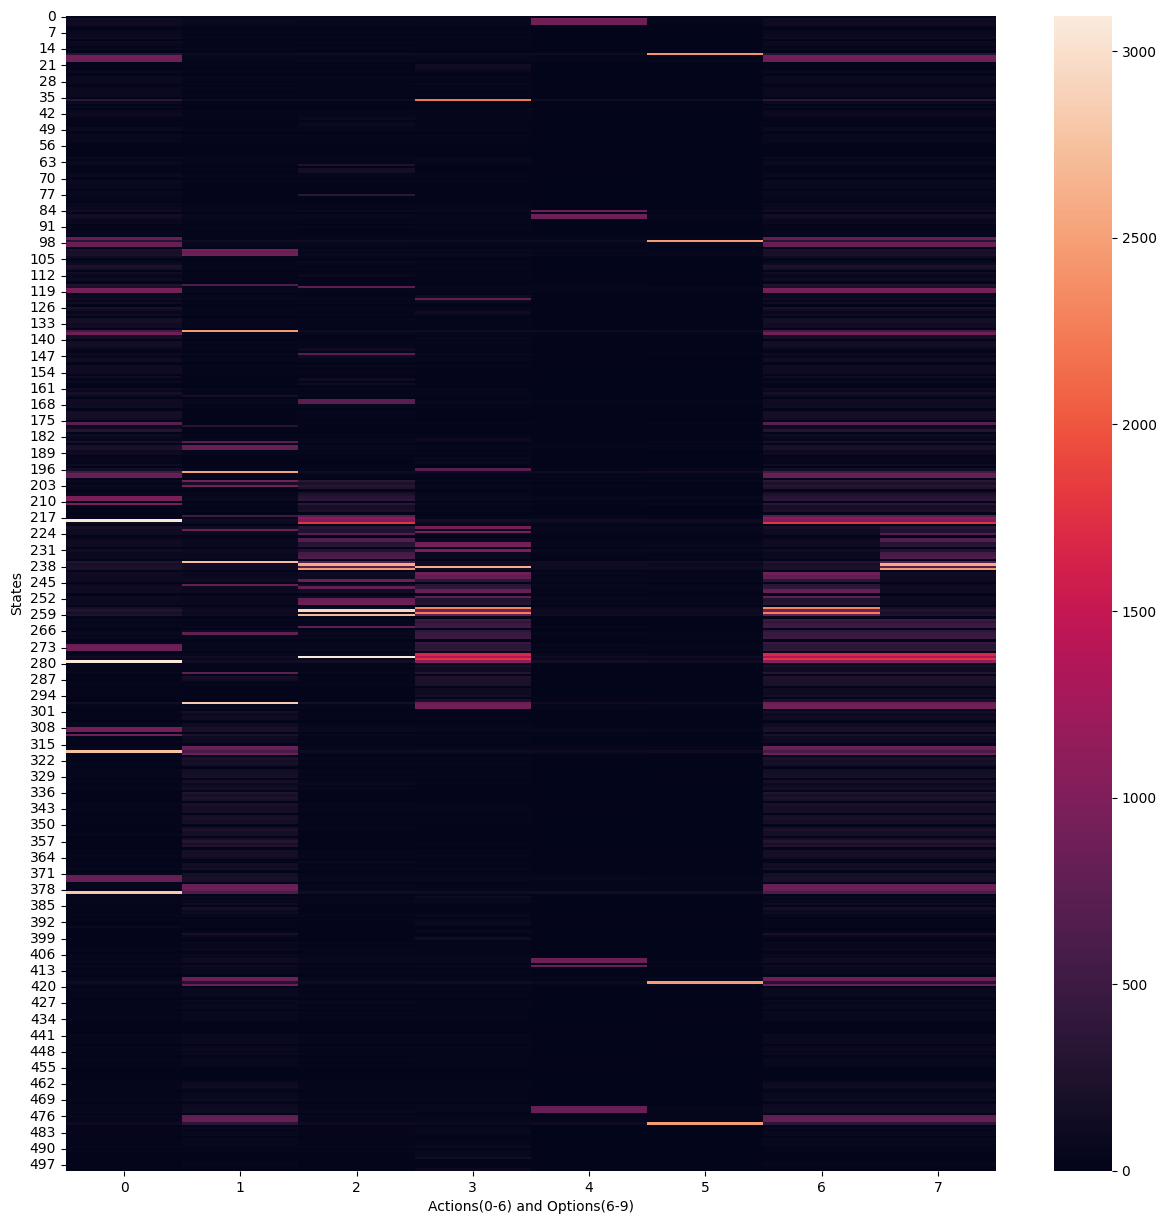

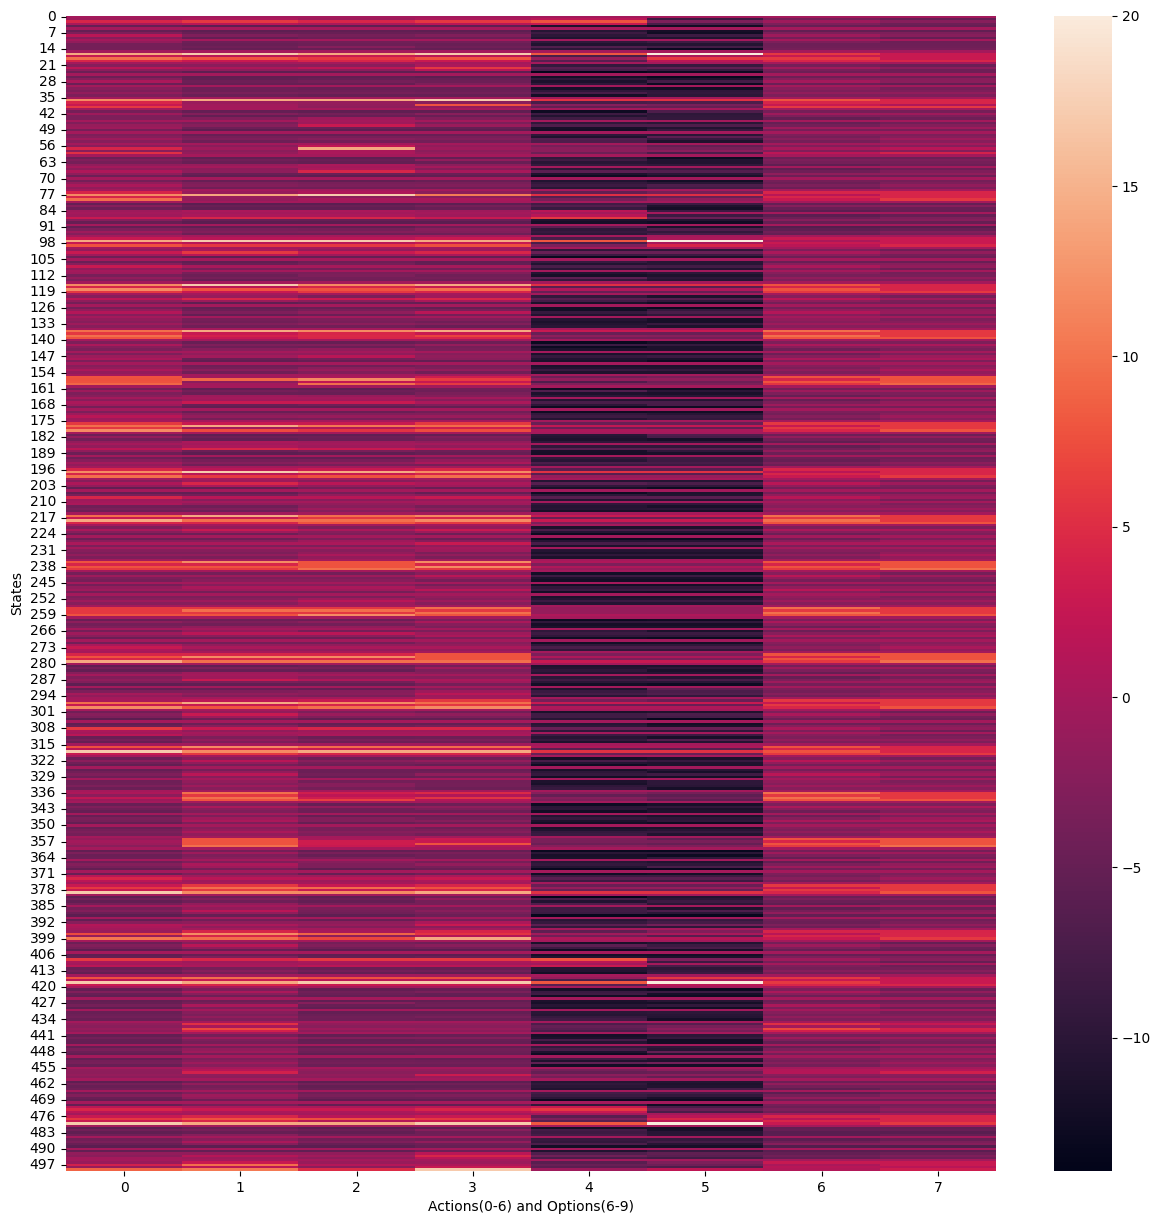

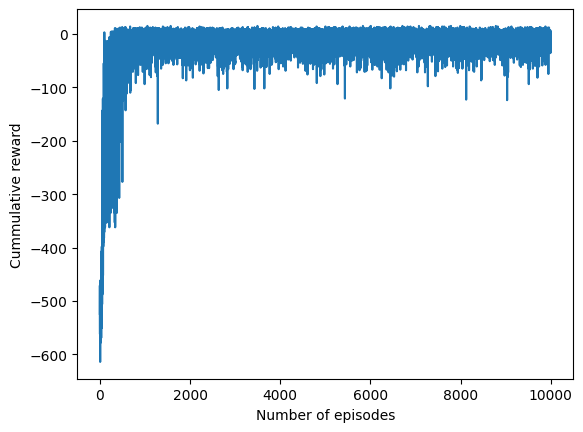

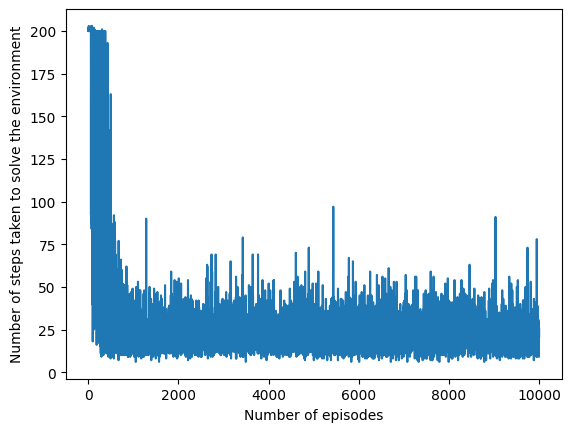

wandb: Agent Starting Run: odf9ilay with config:
wandb: 	EPS: 0.061779320029030346
wandb: 	LR: 0.5
wandb: 	NUM_EPISODES: 200000


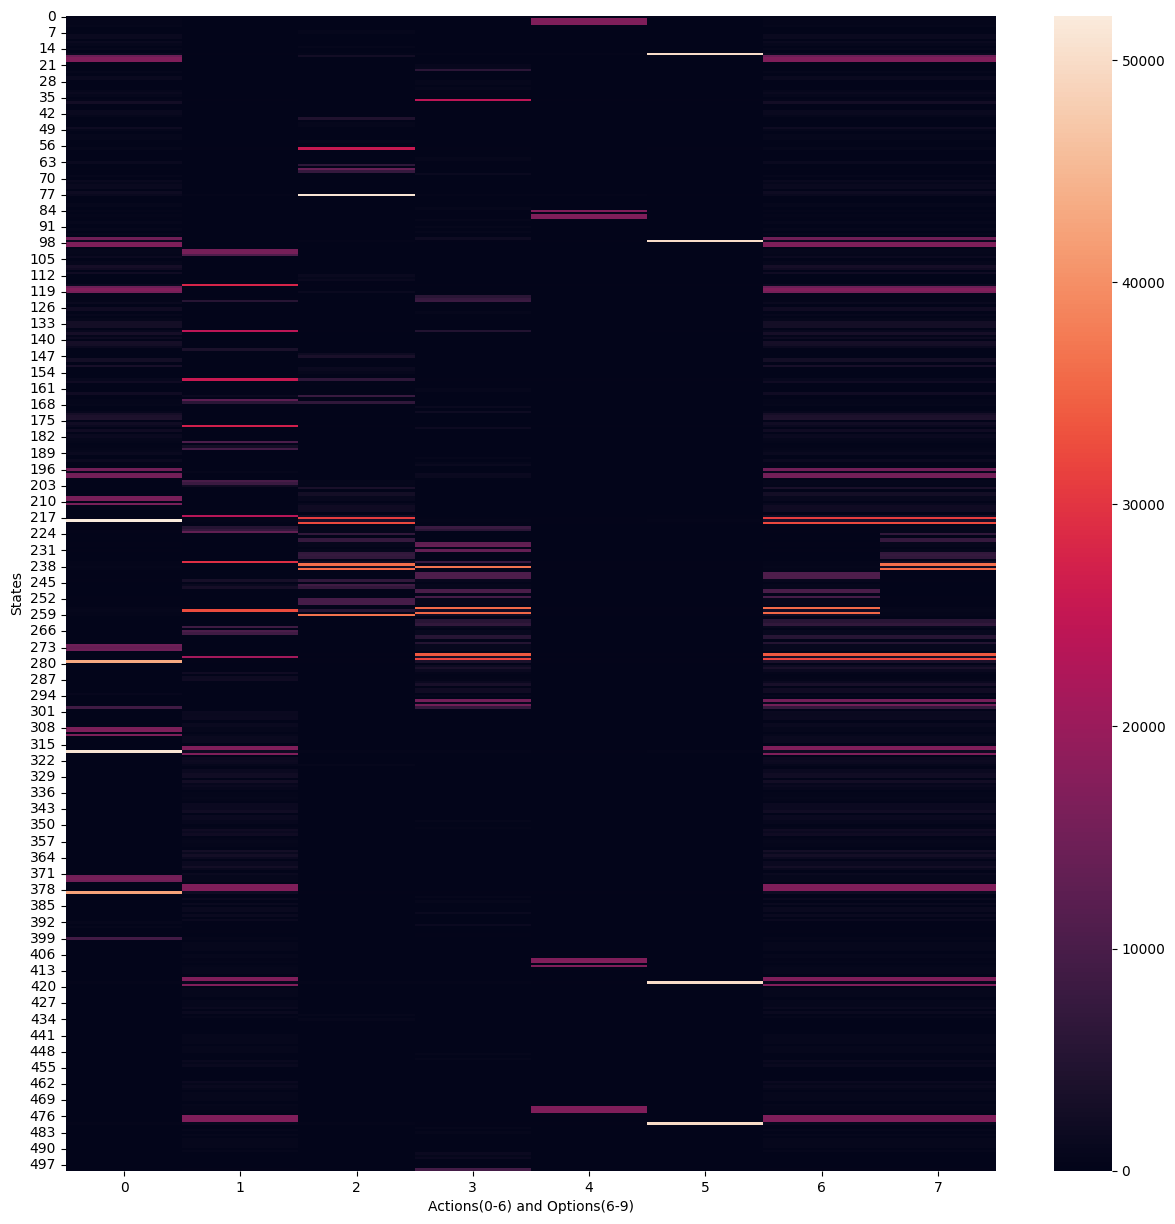

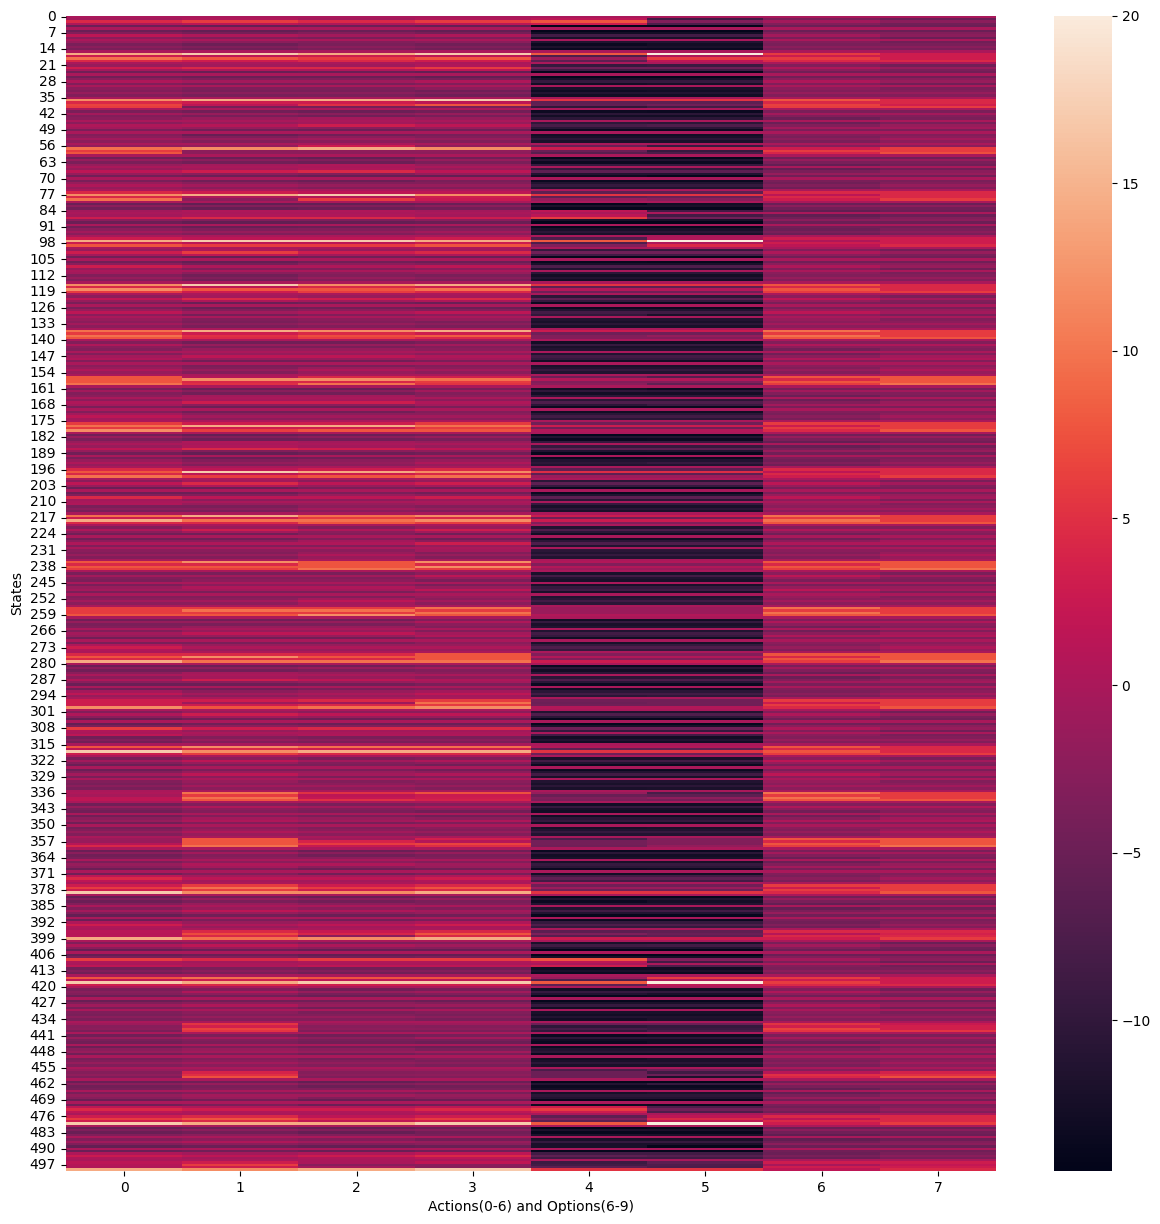

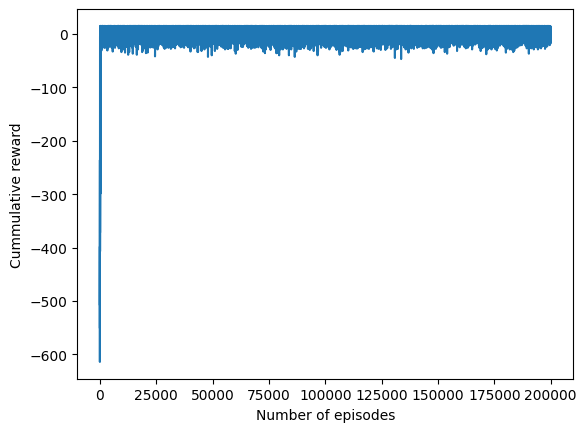

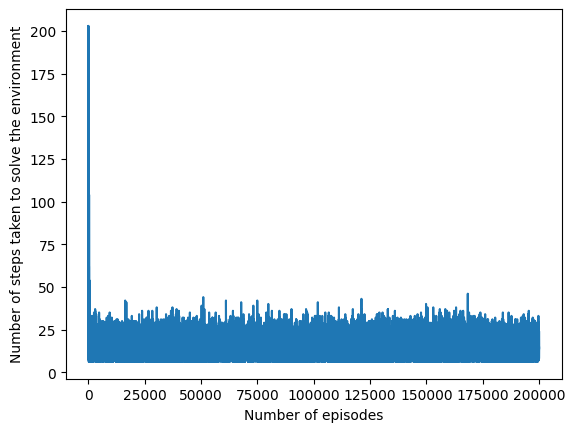

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vnd198ct with config:
wandb: 	EPS: 0.2988602958835014
wandb: 	LR: 0.3
wandb: 	NUM_EPISODES: 200000
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


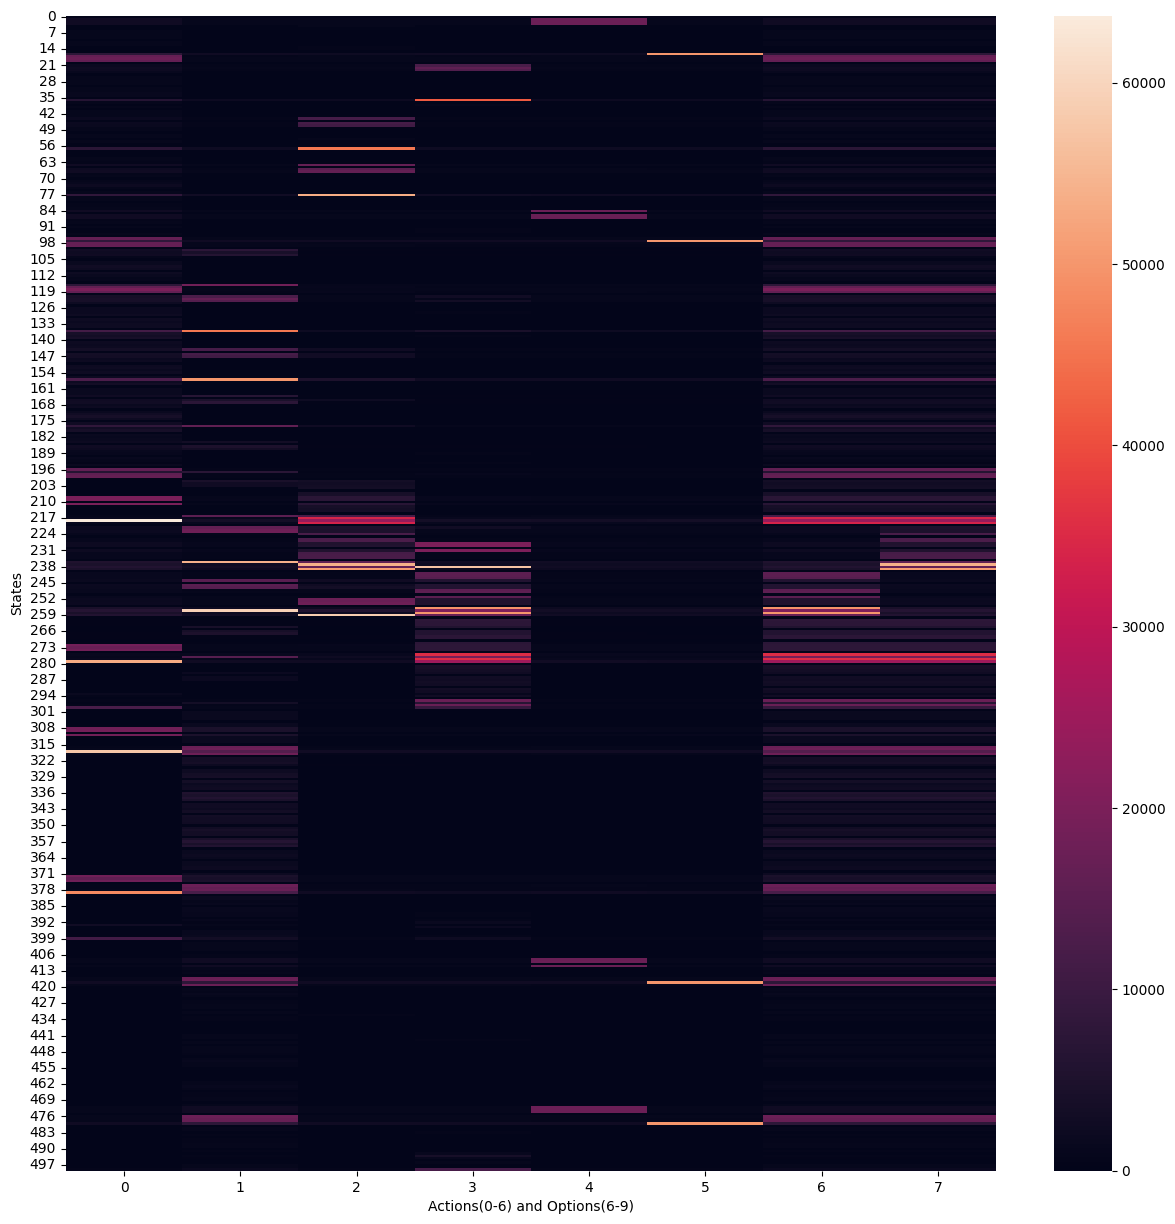

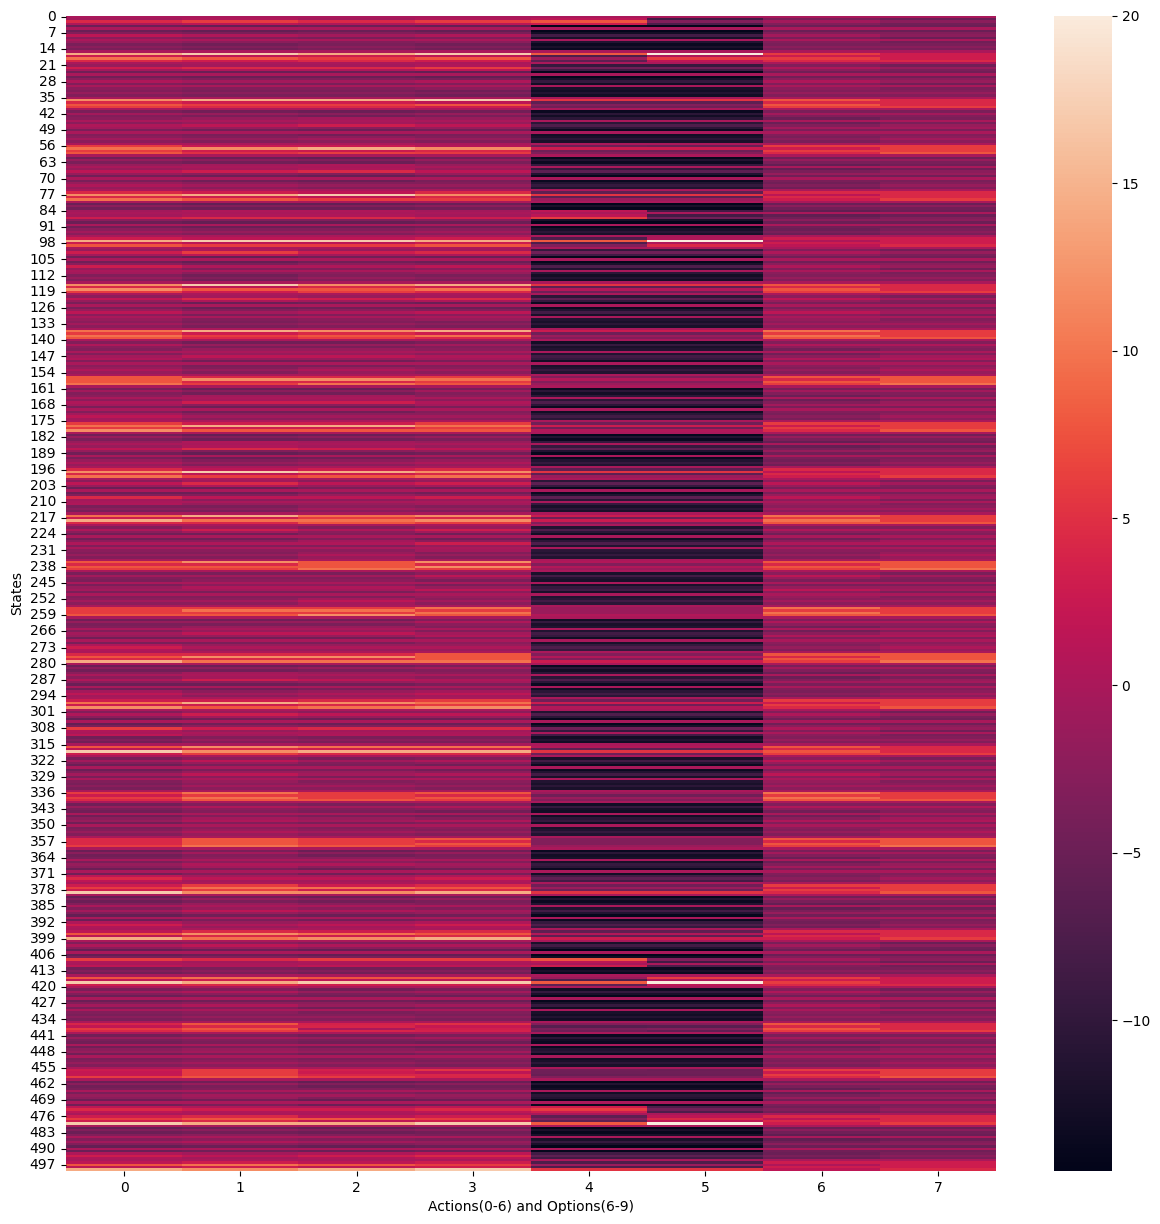

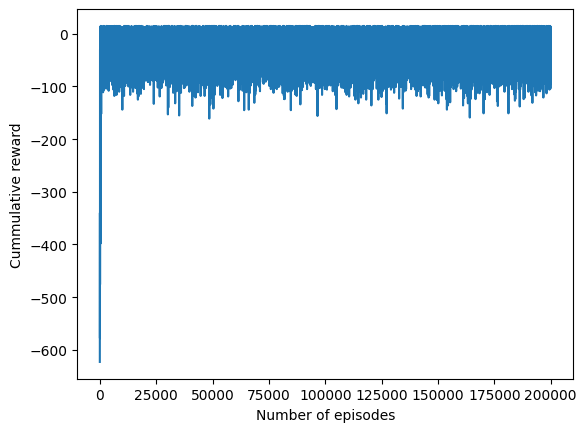

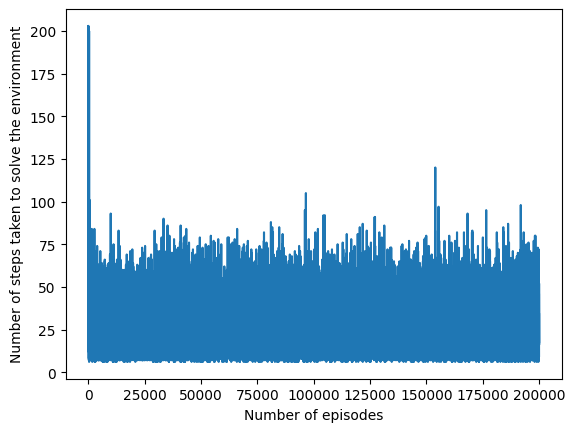

wandb: Agent Starting Run: jsbdniba with config:
wandb: 	EPS: 0.052585126486181424
wandb: 	LR: 0.01
wandb: 	NUM_EPISODES: 100000


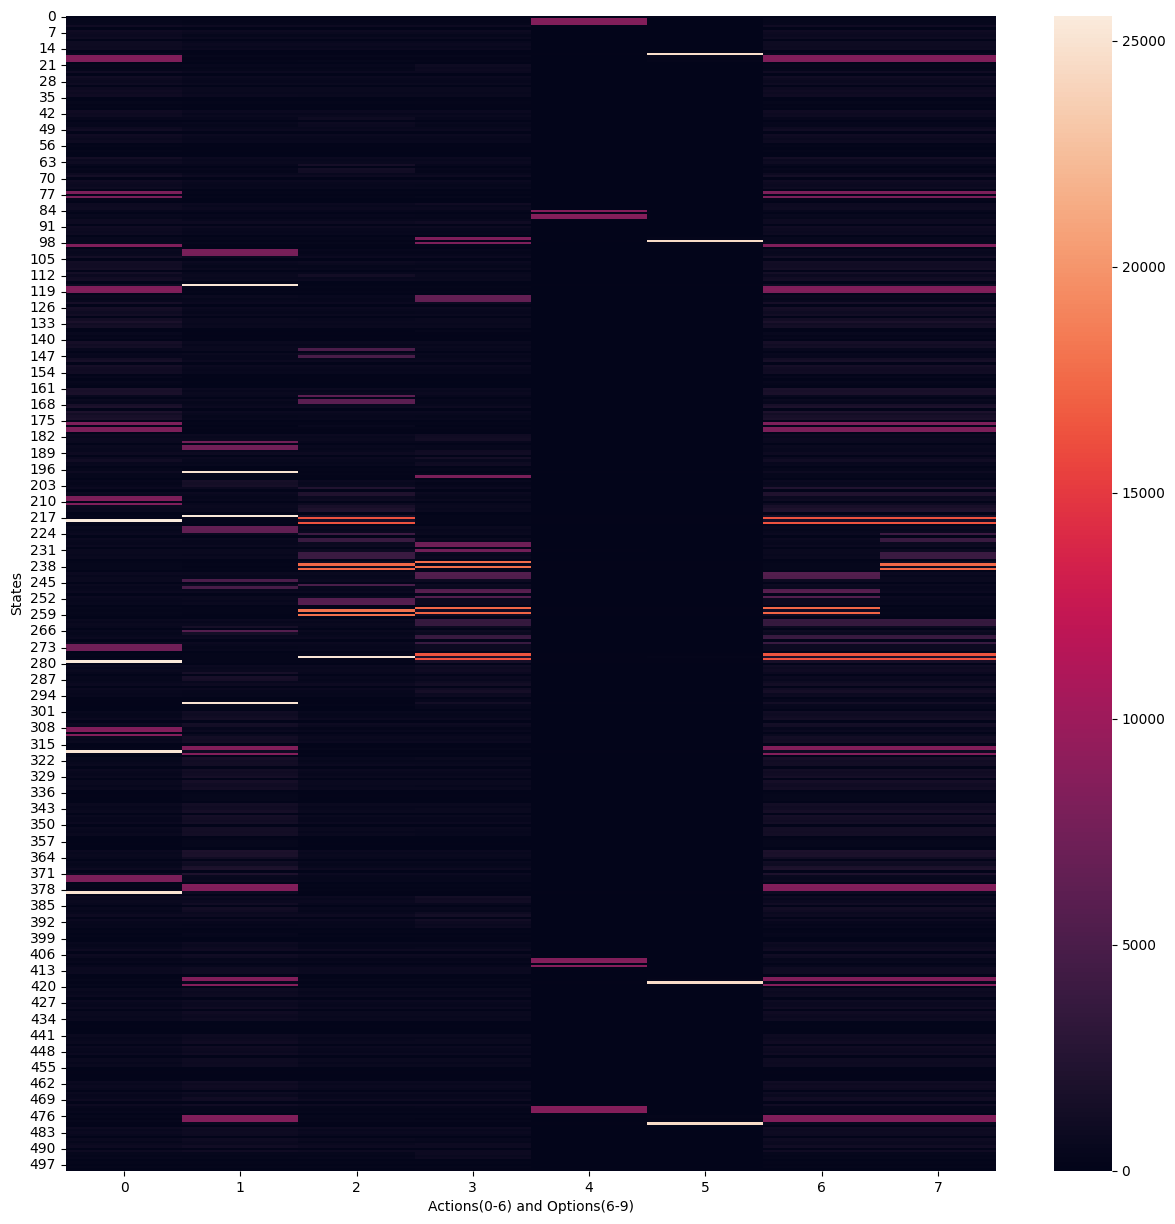

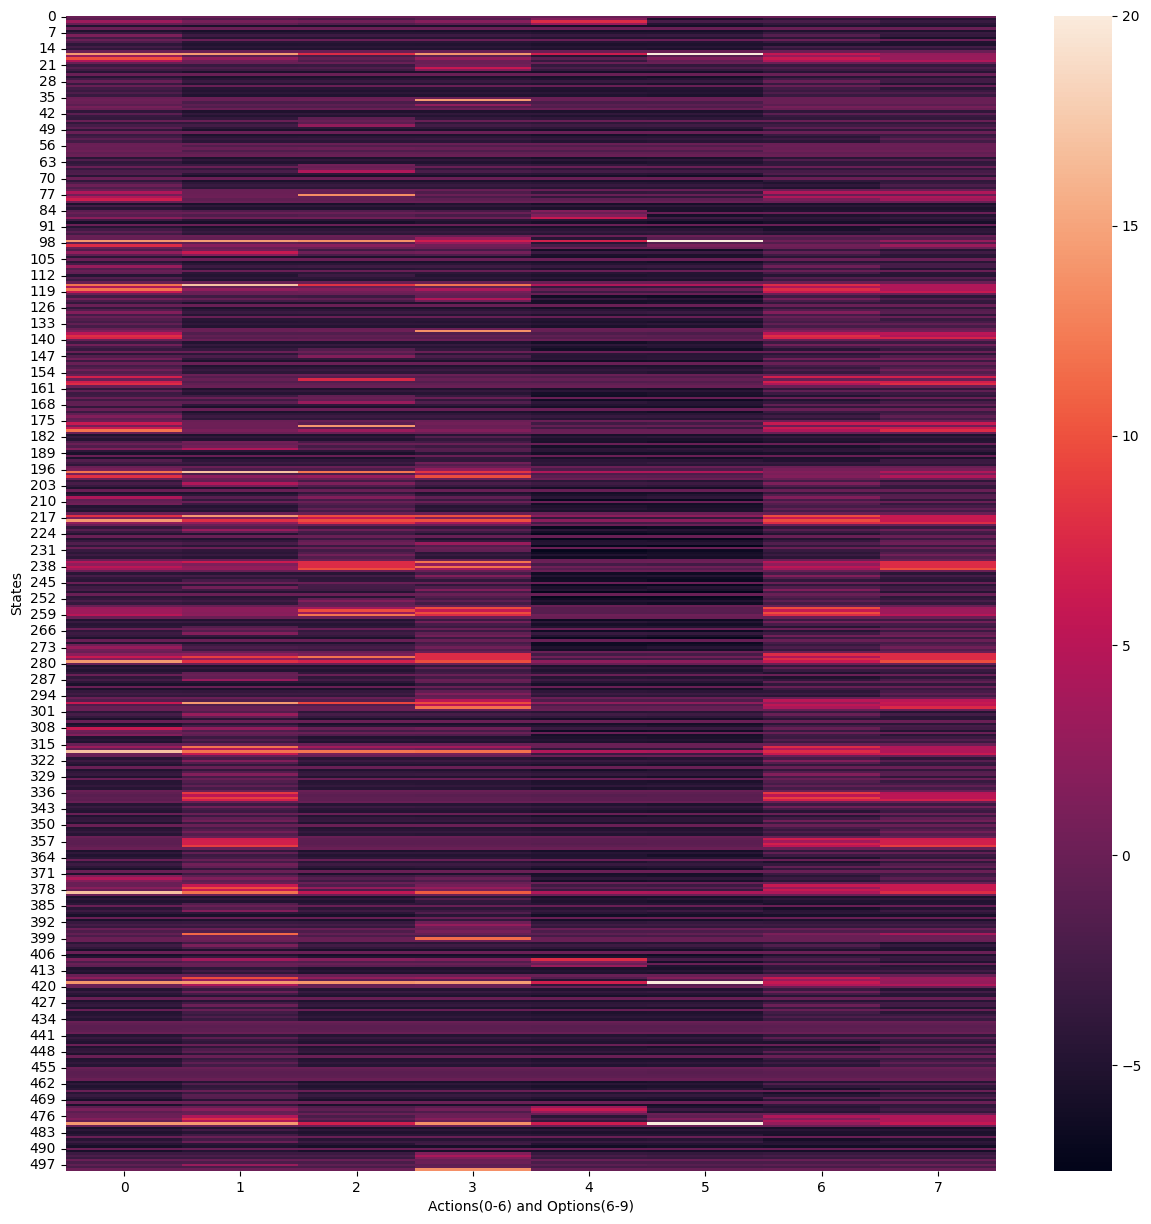

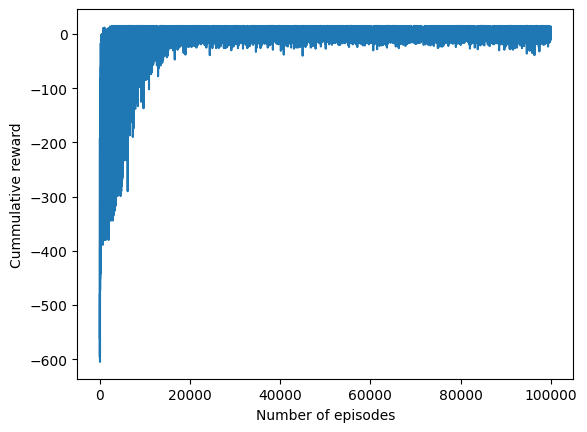

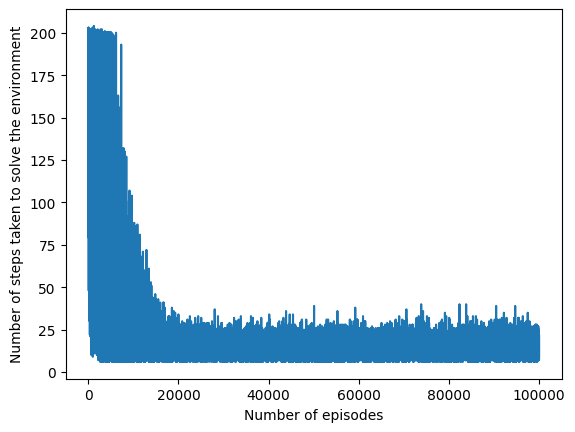

wandb: Agent Starting Run: 97gnqxq7 with config:
wandb: 	EPS: 0.2883201577177131
wandb: 	LR: 0.5
wandb: 	NUM_EPISODES: 200000


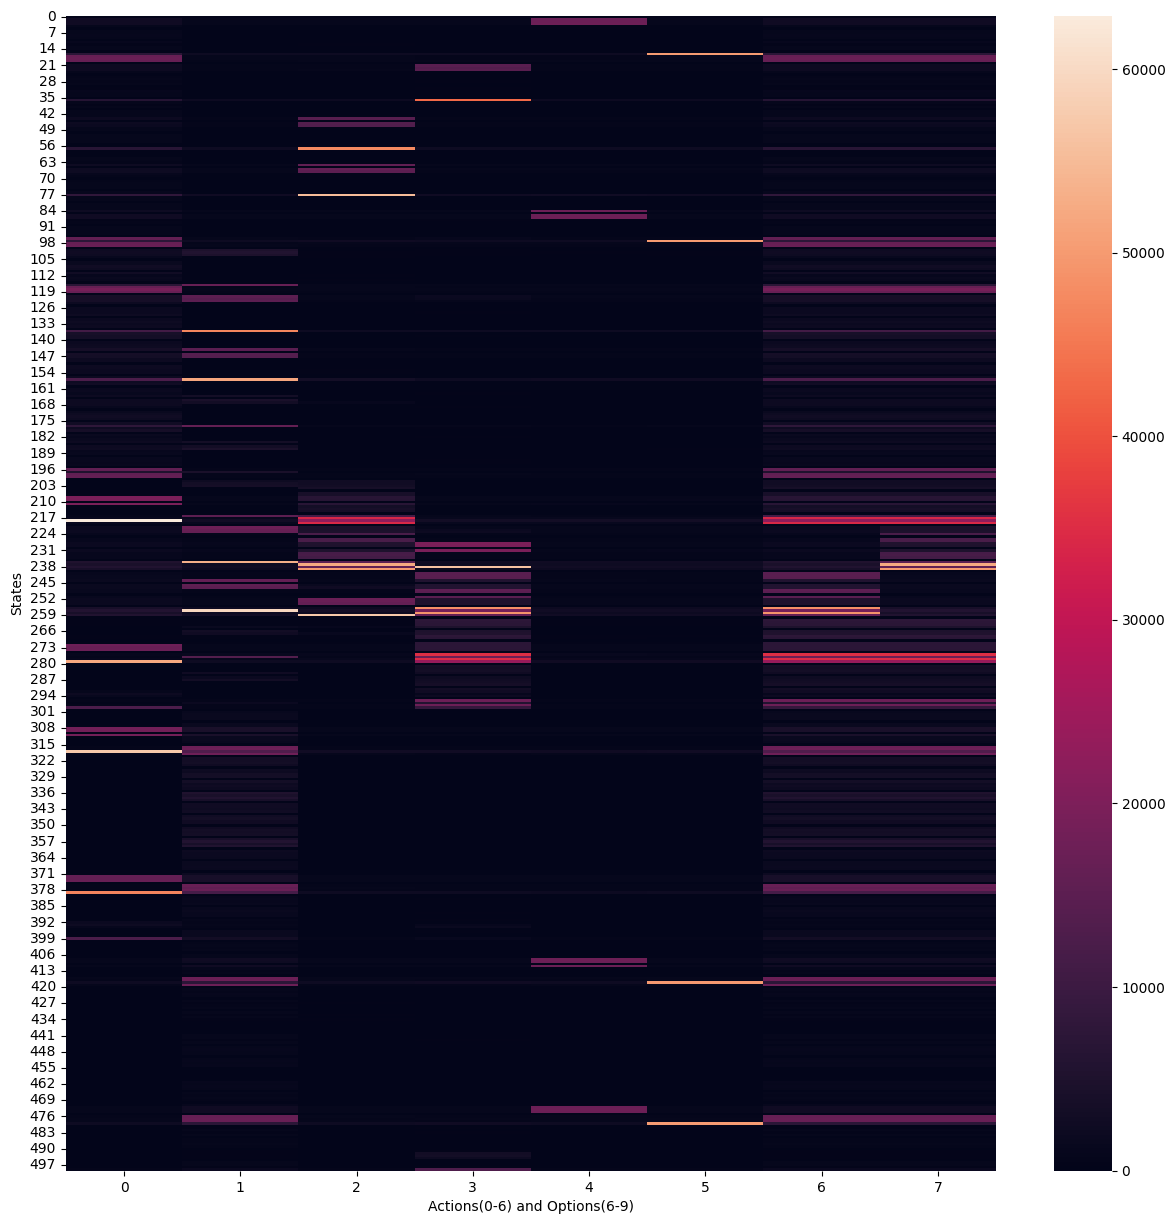

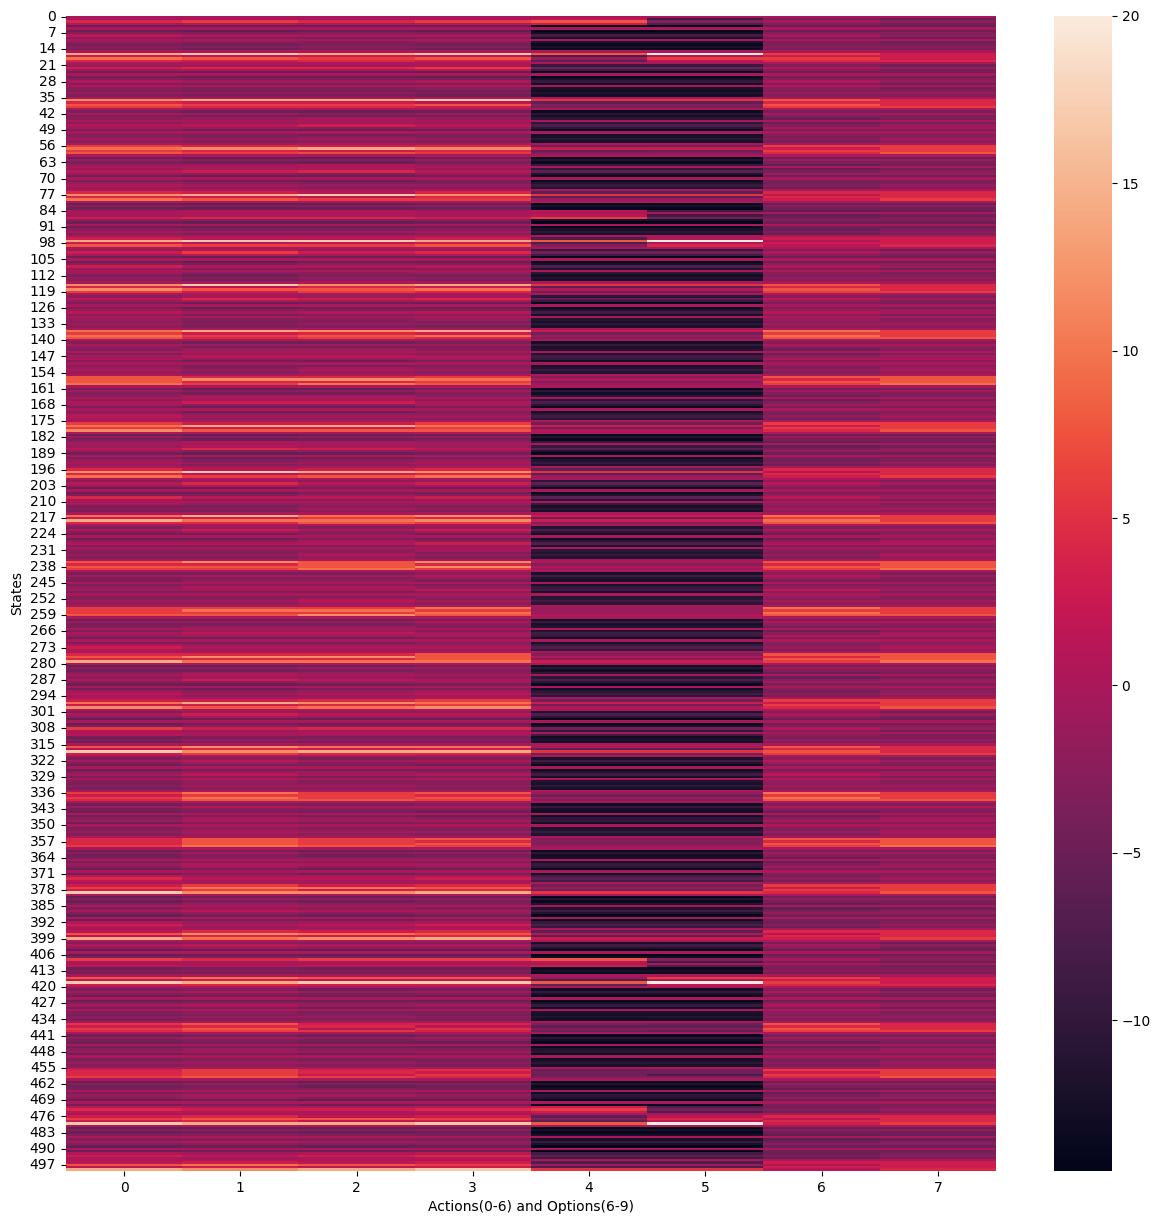

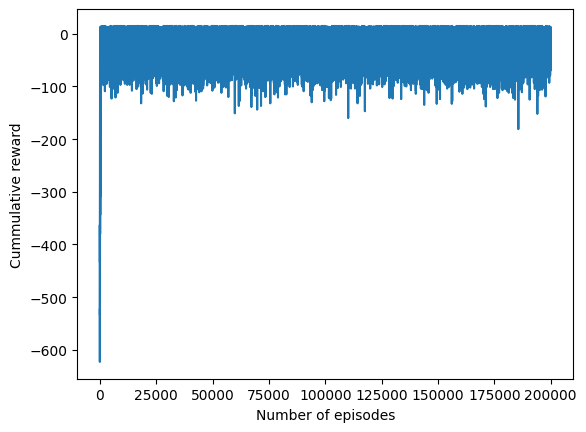

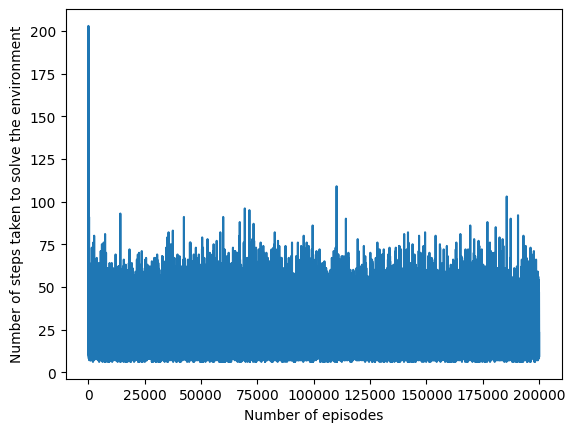

In [ ]:
wandb.agent(sweep_id, train_intra_Q, count=20)

In [ ]:
def Q_intra_option_Q_learning_(ALPHA,GAMMA,EPS,NUM_EPS):
  actions = [0,1,2,3,4,5,6,7]
  action_policy = {6:policy_11,7: policy_12}
  termination_dict = {6:11,7:12}
  Q_intra_option_Q = np.zeros((env.observation_space.n,len(actions))) 
  Update_Frequency_intra_q_learning = np.zeros((env.observation_space.n,len(actions)))
  alpha = ALPHA
  gamma = GAMMA
  cumul_reward_intra = []
  ep_steps = []

  def average_episode_time(Q):
    steps = []
    trajectories_ep = []
    for i in range(1000):
      state = env.reset()
      done = False
      t = 0
      trajectory = []
      while not done:
        action = np.argmax(Q[state])
        
        if action<6:
          next_state,reward,done,_ = env.step(action)
          trajectory.append([state,action,next_state,reward,False])
          state = next_state
          t+=1
        if action>=6:
          optdone = False
          while not optdone:

            row_t,col_t,_,_ = env.decode(state)
            optaction = action_policy[action][row_t][col_t] 
            next_state,reward,done,_ = env.step(optaction)
            trajectory.append([state,optaction,next_state,reward,True])
            t+=1
            state= next_state
            row_t_1,col_t_1,_,_ = env.decode(next_state)
            next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
            if next_state_is_terminal:
              optdone = True
            state = next_state
      steps.append(t)
      trajectories_ep.append(trajectory)
    return np.array(steps).mean(), steps,trajectories_ep
  def return_action(state,epsilon,Q):
    if np.random.rand()>epsilon:
      return np.argmax(Q[state])
    else:
      return np.random.choice(np.arange((len(actions))),1)[0]

  def update_intraoption_action(state,action,next_state,reward): #here action is a primitive action
    Q_intra_option_Q[state][action] += alpha*(reward + gamma*max(Q_intra_option_Q[next_state]) - Q_intra_option_Q[state][action])
    Update_Frequency_intra_q_learning[state][action] +=1 
    row_t,col_t,_,_ = env.decode(state)
    row_t_1,col_t_1,_,_ = env.decode(next_state)
    
    for option in range(6,8):
      #print(option,termination_dict[option])
      optaction_  = action_policy[option][row_t][col_t]
      next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[option] else False 
      if optaction_ == action:
        if next_state_is_terminal == False:
          Q_intra_option_Q[state][option] += alpha*(reward + (gamma * Q_intra_option_Q[next_state][option]) - Q_intra_option_Q[state][option])
          Update_Frequency_intra_q_learning[state][option] += 1  
        else:
          Q_intra_option_Q[state][option] += alpha*(reward + gamma * max(Q_intra_option_Q[next_state]) - Q_intra_option_Q[state][option])
          Update_Frequency_intra_q_learning[state][option] += 1  

  for ep in range(int(NUM_EPS)):
    state = env.reset()
    done = False
    t = 0
    r = 0
    while not done:
      eps = max((0.99**ep)*0.9,EPS)
      action = return_action(state,eps,Q_intra_option_Q)
      #print(state,action)
      if action <6:
        next_state,reward,done,_ = env.step(action)
        r+=  reward
        t+=1
        update_intraoption_action(state,action,next_state,reward)
        state = next_state
        #print(state,action,next_state,reward)
      if action>=6:
        #print("current_option: ",action)
        optdone = False
        while not optdone:

          row_t,col_t,_,_ = env.decode(state)
          optaction = action_policy[action][row_t][col_t] 
          next_state,reward,done,_ = env.step(optaction) 
          r+= reward
          t+=1
          update_intraoption_action(state,optaction,next_state,reward)
          state= next_state
          row_t_1,col_t_1,_,_ = env.decode(next_state)
          next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
          #print(state,optaction,next_state,reward,termination_dict[action])
          if next_state_is_terminal:
            optdone = True
    cumul_reward_intra.append(r)
    ep_steps.append(t)

  plt.figure(figsize = (15,15))
  sns.heatmap(Update_Frequency_intra_q_learning,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Update_frequency_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  plt.figure(figsize = (15,15))
  sns.heatmap(Q_intra_option_Q,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Intra_option ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(cumul_reward_intra)
  plt.xlabel("Number of episodes")
  plt.ylabel("Cummulative reward")
  plt.savefig(str("Reward_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(ep_steps)
  plt.xlabel("Number of episodes")
  plt.ylabel("Number of steps taken to solve the environment")
  plt.savefig(str("time_steps_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()

  mean_steps,_,_ =  average_episode_time(Q_intra_option_Q)
  return mean_steps,Q_intra_option_Q


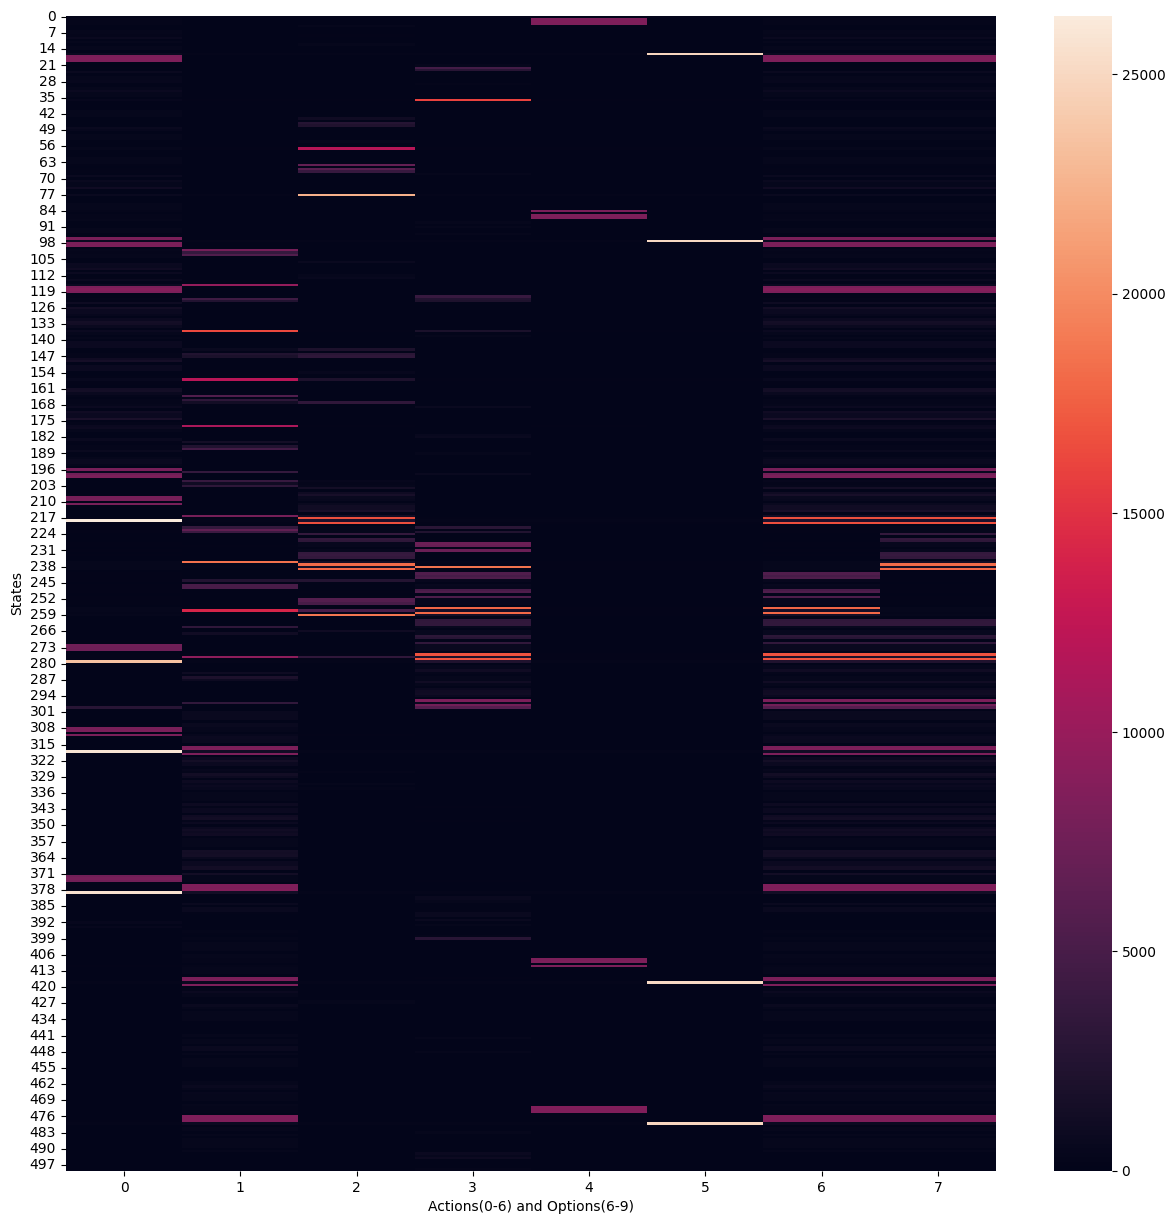

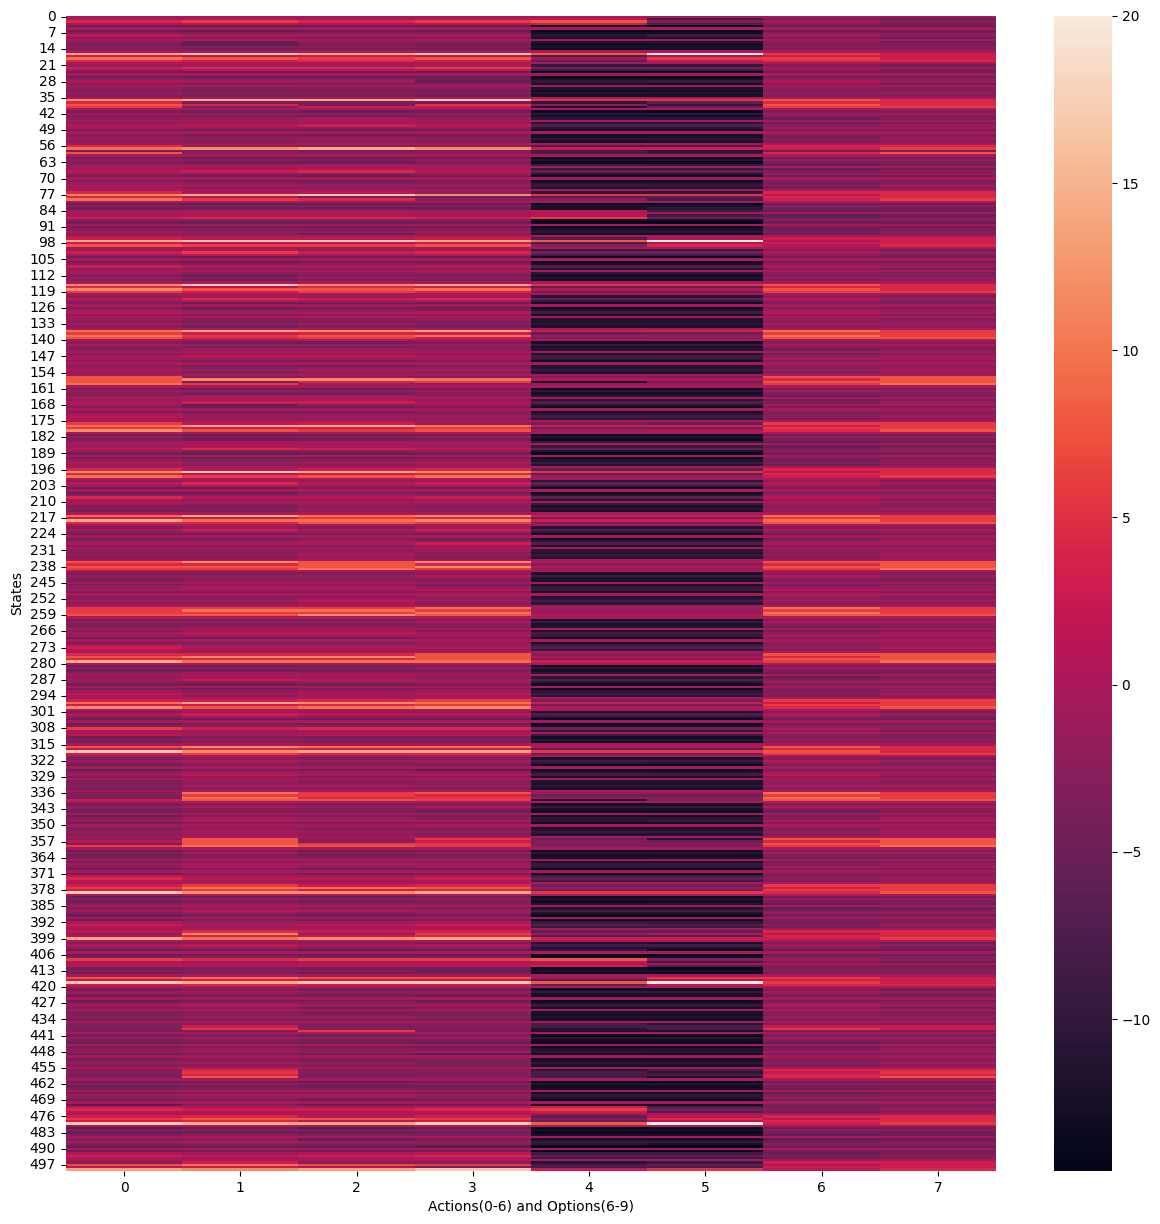

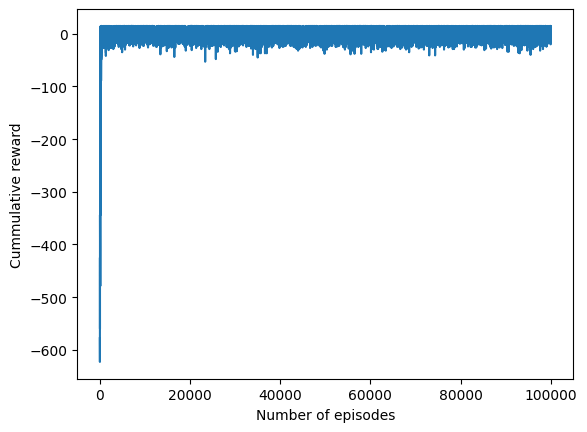

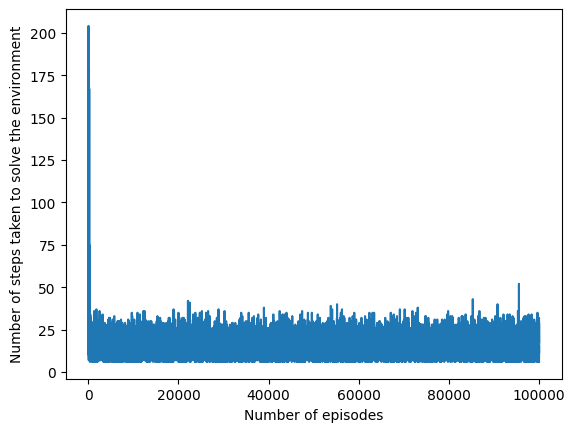

0    42
1    37
3    18
4     3
Name: 0, dtype: int64
1    45
0    36
2    16
4     3
Name: 1, dtype: int64
0    56
1    21
3    20
4     3
Name: 2, dtype: int64
0    58
1    18
2    13
3     8
4     3
Name: 3, dtype: int64
Destination
1    13
0     6
3     5
5     1
Name: 0, dtype: int64
1    16
0     4
2     4
5     1
Name: 1, dtype: int64
0    10
1     8
3     6
5     1
Name: 2, dtype: int64
0    13
1     5
2     4
3     2
5     1
Name: 3, dtype: int64


In [ ]:
EPS: 0.07094425713152018
LR: 0.8
NUM_EPISODES: 100000
import pandas as pd
mean_steps,Q = Q_intra_option_Q_learning_(LR,0.9,EPS,NUM_EPISODES)


arr = Q.argmax(-1)
actions = [0,1,2,3,4,5,6,7,8,9] #6-9 options in the order -> y,g,r,b
termination_dict = {6:20,7:4,8:0,9:23}
passenger_dest = {0:0, 1:4, 2:20, 3:23}

action_count_passenger = {0:[],1:[],2:[],3:[]}
action_count_destination = {0:[],1:[],2:[],3:[]}
notintaxi = []
intaxi = []
for i in range(len(arr)):
  action = arr[i]
  r,c,passenger_ind,destination = env.decode(i)
  if passenger_ind!=4:
    action_count_passenger[passenger_ind].append(action)
  if passenger_ind == 4:
    action_count_destination[destination].append(action)

  
    
df1 = pd.DataFrame(action_count_passenger)

for i in df1.columns:
  print(df1[i].value_counts())



print("Destination")

df2 = pd.DataFrame(action_count_destination)

for i in df2.columns:
  print(df2[i].value_counts())


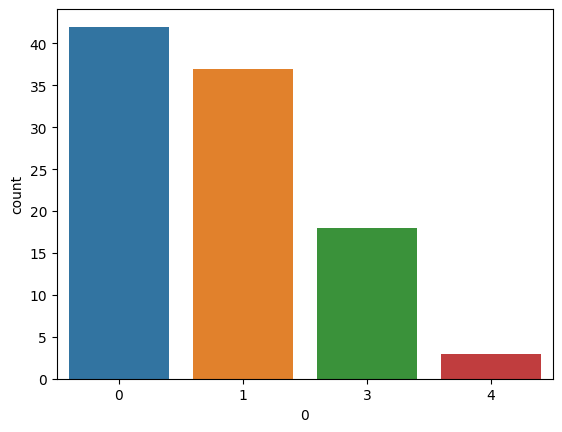

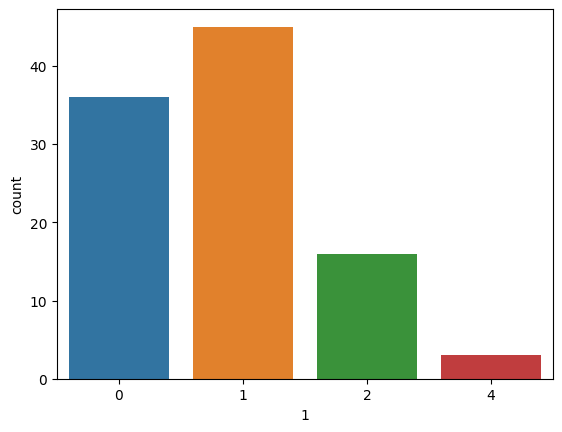

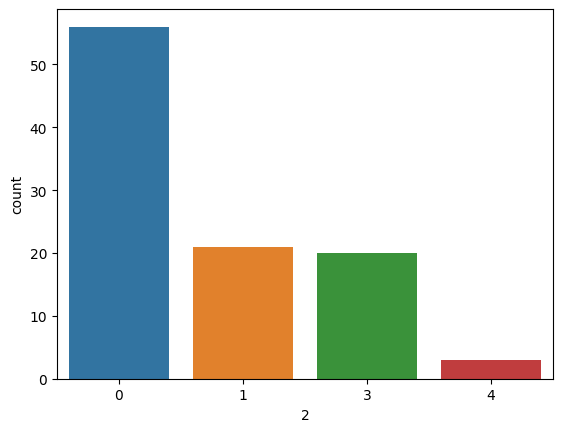

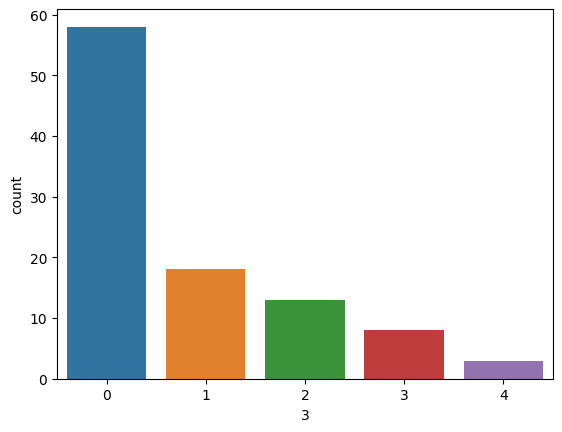

-------------DESTIN-----------------


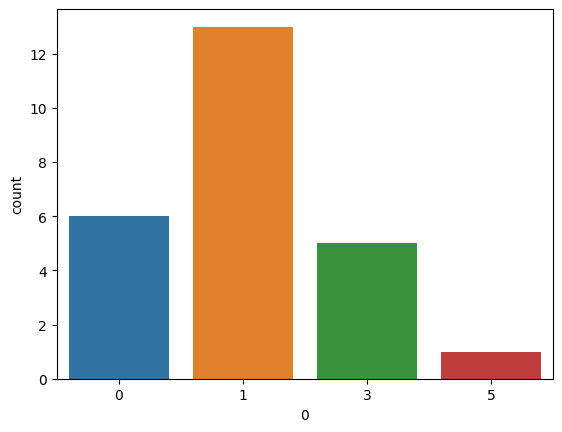

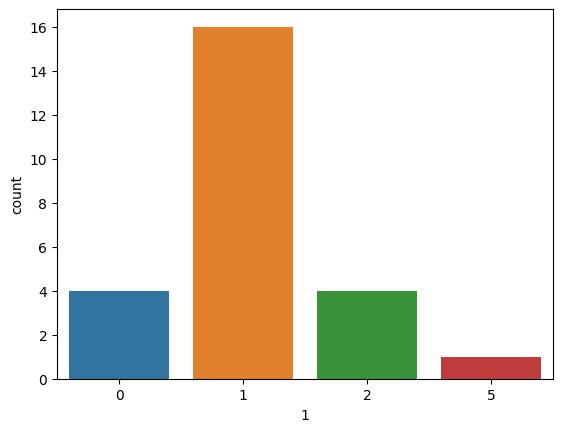

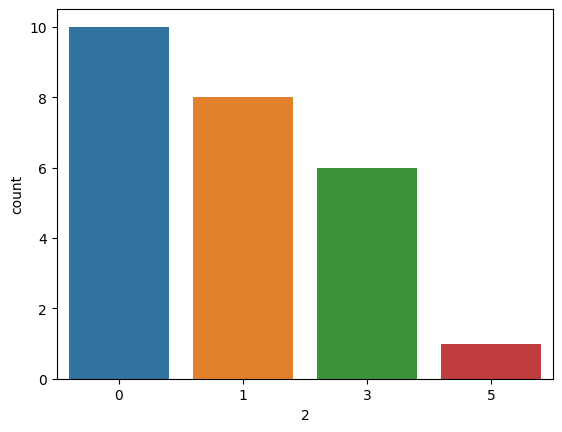

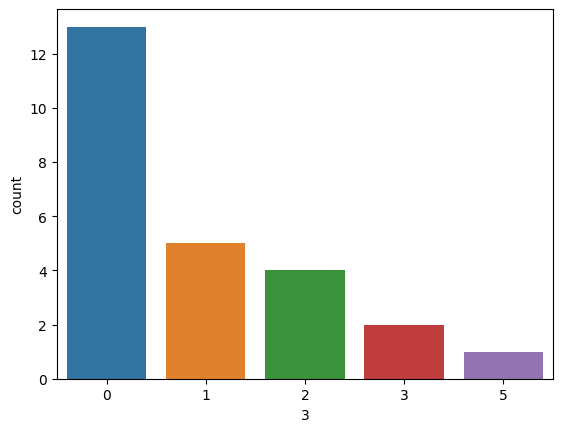

In [ ]:
df1 = pd.DataFrame(action_count_passenger)

for i in df1.columns:
  sns.countplot(x = (df1[i]))
  plt.show()



print("-------------DESTIN-----------------")
df2 = pd.DataFrame(action_count_destination)

for i in df2.columns:
  sns.countplot(x = (df2[i]))
  plt.show()
